**Name**

Yu-Chih (Wisdom) Chen

Jessy Hu

Boya Zeng

Yuqing Wu

**Date**

04/31/2024

## **Forecasting Bike Share Usage in Chicago**

### Introduction

The primary objective of this project is to accurately predict the demand for Divvy bikes in Chicago using historical trip data provided by the company. By analyzing patterns in bike usage, the project aims to enhance the availability and efficiency of bike-sharing services for Divvy customers. The project will employ various time series forecasting models, including SARIMA, Prophet, Orbit, and LSTM, to predict the demand for both classic and electronic bikes. This predictive analysis will enable Divvy to optimize its bike stock management across different periods, thereby reducing operational costs and improving customer access to bikes during peak demand times.


### Project Content

* [Chicago Divvy Bicycle Dataset](#Chicago-Divvy-Bicycle-Dataset)
* [1. Load Packages](#Load-Packages)
* [2. Clean up Divvy Bicycle Data](#Clean-up-Divvy-Bicycle-Data)
* [3. Load Divvy Bicyle Dataset](#Load-Divvy-Bicyle-Dataset)
* [4. Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [5. Data Transformation](#Data-Transformation)
* [6. Build Time Series Model & Evaluation](#Build-Time-Series-Model-&-Evaluation)
* [7. Prediction Result Comparison](#Prediction-Result-Comparison)

In [ ]:
!pip install keras_tuner
!pip install orbit-ml
!pip install bayesian-optimization
!pip install pmdarima
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/129.1 kB ? eta -:--:--
     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/129.1 kB 1.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━ 122.9/129.1 kB 2.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.4 MB/s eta 0:00:00


<a name="Chicago-Divvy-Bicycle-Dataset"></a>
## Chicago Divvy Bicycle Dataset

The dataset provided by Divvy includes historical trip data that is publicly available for various uses, including analysis and forecasting. The data is released on a monthly schedule and adheres to the Divvy Data License Agreement. Each record in the dataset is anonymized for privacy and includes several key features:

 - **Trip Start Day and Time:** The date and time when the bike trip started.
 - **Trip End Day and Time:** The date and time when the bike trip ended.
 - **Trip Start Station:** The station where the bike trip began.
 - **Trip End Station:** The station where the bike trip concluded.
 - **Rider Type:** The category of the rider, which includes Member, Single Ride, and Day Pass.


Download the data directly from: https://divvybikes.com/system-data

<a name="Load-Packages"></a>
## 1. Load Packages

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import scipy.stats
from scipy.stats import norm
import matplotlib.dates as mdates
import os

from math import sqrt
import scipy.stats as stats
from scipy.stats import randint, uniform

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator

import torch
from tensorflow import keras
import kerastuner as kt
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from bayes_opt import BayesianOptimization


from pmdarima import auto_arima

#from orbit.models import DLT
#from orbit.diagnostics.plot import plot_predicted_data
#from orbit.utils.params_tuning import grid_search_orbit
#from orbit.utils.features import make_fourier_series_df
#from orbit.utils.params_tuning import generate_param_args_list

# from prophet import Prophet

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="Clean-up-Divvy-Bicycle-Data"></a>
## 2. Clean up Divvy Bicycle Data


#### Check 2020 Q1

In [ ]:
df_2020_Q1 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/Divvy_Trips_2020_Q1.csv")

df_2020_Q1.head()

ride_id rideable_type           started_at             ended_at  \
0  EACB19130B0CDA4A   docked_bike  2020-01-21 20:06:59  2020-01-21 20:14:30   
1  8FED874C809DC021   docked_bike  2020-01-30 14:22:39  2020-01-30 14:26:22   
2  789F3C21E472CA96   docked_bike  2020-01-09 19:29:26  2020-01-09 19:32:17   
3  C9A388DAC6ABF313   docked_bike  2020-01-06 16:17:07  2020-01-06 16:25:56   
4  943BC3CBECCFD662   docked_bike  2020-01-30 08:37:16  2020-01-30 08:42:48   

         start_station_name  start_station_id                end_station_name  \
0  Western Ave & Leland Ave               239           Clark St & Leland Ave   
1   Clark St & Montrose Ave               234  Southport Ave & Irving Park Rd   
2    Broadway & Belmont Ave               296        Wilton Ave & Belmont Ave   
3    Clark St & Randolph St                51        Fairbanks Ct & Grand Ave   
4      Clinton St & Lake St                66           Wells St & Hubbard St   

   end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  
0           326.0    41.9665   -87.6884  41.9671 -87.6674        member  
1           318.0    41.9616   -87.6660  41.9542 -87.6644        member  
2           117.0    41.9401   -87.6455  41.9402 -87.6530        member  
3            24.0    41.8846   -87.6319  41.8918 -87.6206        member  
4           212.0    41.8856   -87.6418  41.8899 -87.6343        member

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Check 04/2020

In [ ]:
df_2020_04 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202004-divvy-tripdata.csv")
df_2020_04.head()

ride_id rideable_type           started_at             ended_at  \
0  A847FADBBC638E45   docked_bike  2020-04-26 17:45:14  2020-04-26 18:12:03   
1  5405B80E996FF60D   docked_bike  2020-04-17 17:08:54  2020-04-17 17:17:03   
2  5DD24A79A4E006F4   docked_bike  2020-04-01 17:54:13  2020-04-01 18:08:36   
3  2A59BBDF5CDBA725   docked_bike  2020-04-07 12:50:19  2020-04-07 13:02:31   
4  27AD306C119C6158   docked_bike  2020-04-18 10:22:59  2020-04-18 11:15:54   

             start_station_name  start_station_id  \
0                  Eckhart Park                86   
1     Drake Ave & Fullerton Ave               503   
2          McClurg Ct & Erie St               142   
3  California Ave & Division St               216   
4          Rush St & Hubbard St               125   

              end_station_name  end_station_id  start_lat  start_lng  end_lat  \
0  Lincoln Ave & Diversey Pkwy           152.0    41.8964   -87.6610  41.9322   
1              Kosciuszko Park           499.0    41.9244   -87.7154  41.9306   
2   Indiana Ave & Roosevelt Rd           255.0    41.8945   -87.6179  41.8679   
3       Wood St & Augusta Blvd           657.0    41.9030   -87.6975  41.8992   
4   Sheridan Rd & Lawrence Ave           323.0    41.8902   -87.6262  41.9695   

   end_lng member_casual  
0 -87.6586        member  
1 -87.7238        member  
2 -87.6230        member  
3 -87.6722        member  
4 -87.6547        casual

#### Check 05/2020

In [ ]:
df_2020_05 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202005-divvy-tripdata.csv")
df_2020_05.head()

ride_id rideable_type           started_at             ended_at  \
0  02668AD35674B983   docked_bike  2020-05-27 10:03:52  2020-05-27 10:16:49   
1  7A50CCAF1EDDB28F   docked_bike  2020-05-25 10:47:11  2020-05-25 11:05:40   
2  2FFCDFDB91FE9A52   docked_bike  2020-05-02 14:11:03  2020-05-02 15:48:21   
3  58991CF1DB75BA84   docked_bike  2020-05-02 16:25:36  2020-05-02 16:39:28   
4  A79651EFECC268CD   docked_bike  2020-05-29 12:49:54  2020-05-29 13:27:11   

           start_station_name  start_station_id  \
0  Franklin St & Jackson Blvd                36   
1   Clark St & Wrightwood Ave               340   
2  Kedzie Ave & Milwaukee Ave               260   
3  Clarendon Ave & Leland Ave               251   
4     Hermitage Ave & Polk St               261   

                 end_station_name  end_station_id  start_lat  start_lng  \
0          Wabash Ave & Grand Ave           199.0    41.8777   -87.6353   
1           Clark St & Leland Ave           326.0    41.9295   -87.6431   
2      Kedzie Ave & Milwaukee Ave           260.0    41.9296   -87.7079   
3  Lake Shore Dr & Wellington Ave           157.0    41.9680   -87.6500   
4         Halsted St & Archer Ave           206.0    41.8715   -87.6699   

   end_lat  end_lng member_casual  
0  41.8915 -87.6268        member  
1  41.9671 -87.6674        casual  
2  41.9296 -87.7079        casual  
3  41.9367 -87.6368        casual  
4  41.8472 -87.6468        member

#### Check 06/2020

In [ ]:
df_2020_06 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202006-divvy-tripdata.csv")
df_2020_06.head()

#### Check 07/2020

In [ ]:
df_2020_07 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202007-divvy-tripdata.csv")
df_2020_07.head()

#### Check 08/2020

In [ ]:
df_2020_08 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202008-divvy-tripdata.csv")
df_2020_08.head()

#### Check 09/2020

In [ ]:
df_2020_09 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202009-divvy-tripdata.csv")
df_2020_09.head()

#### Check 10/2020

In [ ]:
df_2020_10 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202010-divvy-tripdata.csv")
df_2020_10.head()

#### Check 11/2020

In [ ]:
df_2020_11 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202011-divvy-tripdata.csv")
df_2020_11.head()

#### Check 12/2020

In [ ]:
df_2020_12 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202012-divvy-tripdata.csv")
df_2020_12.head()

#### Check 01/2021

In [ ]:
df_2021_01 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202101-divvy-tripdata.csv")
df_2021_01.head()

#### Check 02/2021

In [ ]:
df_2021_02 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202102-divvy-tripdata.csv")
df_2021_02.head()

#### Check 03/2021

In [ ]:
df_2021_03 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202103-divvy-tripdata.csv")
df_2021_03.head()

#### Check 04/2021

In [ ]:
df_2021_04 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202104-divvy-tripdata.csv")
df_2021_04.head()

#### Check 05/2021

In [ ]:
df_2021_05 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202105-divvy-tripdata.csv")
df_2021_05.head()

#### Check 06/2021

In [ ]:
df_2021_06 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202106-divvy-tripdata.csv")
df_2021_06.head()

#### Check 07/2021

In [ ]:
df_2021_07 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202107-divvy-tripdata.csv")
df_2021_07.head()

#### Check 08/2021

In [ ]:
df_2021_08 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202108-divvy-tripdata.csv")
df_2021_08.head()

#### Check 09/2021

In [ ]:
df_2021_09 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202109-divvy-tripdata.csv")
df_2021_09.head()

#### Check 10/2021

In [ ]:
df_2021_10 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202110-divvy-tripdata.csv")
df_2021_10.head()

#### Check 11/2021

In [ ]:
df_2021_11 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202111-divvy-tripdata.csv")
df_2021_11.head()

#### Check 12/2021

In [ ]:
df_2021_12 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202112-divvy-tripdata.csv")
df_2021_12.head()

#### Check 01/2022

In [ ]:
df_2022_01 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202201-divvy-tripdata.csv")
df_2022_01.head()

### Check 02/2022

In [ ]:
df_2022_02 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202202-divvy-tripdata.csv")
df_2022_02.head()

### Check 03/2022

In [ ]:
df_2022_03 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202203-divvy-tripdata.csv")
df_2022_03.head()

### Check 04/2022

In [ ]:
df_2022_04 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202204-divvy-tripdata.csv")
df_2022_04.head()

### Check 05/2022

In [ ]:
df_2022_05 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202205-divvy-tripdata.csv")
df_2022_05.head()

### Check 06/2022

In [ ]:
df_2022_06 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202206-divvy-tripdata.csv")
df_2022_06.head()

### Check 07/2022

In [ ]:
df_2022_07 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202207-divvy-tripdata.csv")
df_2022_07.head()

### Check 08/2022

In [ ]:
df_2022_08 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202208-divvy-tripdata.csv")
df_2022_08.head()

### Check 09/2022

In [ ]:
df_2022_09 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202209-divvy-publictripdata.csv")
df_2022_09.head()

### Check 10/2022

In [ ]:
df_2022_10 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202210-divvy-tripdata.csv")
df_2022_10.head()

### Check 11/2022

In [ ]:
df_2022_11 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202211-divvy-tripdata.csv")
df_2022_11.head()

### Check 12/2022

In [ ]:
df_2022_12 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202212-divvy-tripdata.csv")
df_2022_12.head()

### Check 01/2023

In [ ]:
df_2023_01 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202301-divvy-tripdata.csv")
df_2023_01.head()

### Check 02/2023

In [ ]:
df_2023_02 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202302-divvy-tripdata.csv")
df_2023_02.head()

### Check 03/2023

In [ ]:
df_2023_03 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202303-divvy-tripdata.csv")
df_2023_03.head()

### Check 04/2023

In [ ]:
df_2023_04 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202304-divvy-tripdata.csv")
df_2023_04.head()

### Check 05/2023

In [ ]:
df_2023_05 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202305-divvy-tripdata.csv")
df_2023_05.head()

### Check 06/2023

In [ ]:
df_2023_06 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202306-divvy-tripdata.csv")
df_2023_06.head()

### Check 07/2023

In [ ]:
df_2023_07 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202307-divvy-tripdata.csv")
df_2023_07.head()

### Check 08/2023

In [ ]:
df_2023_08 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202308-divvy-tripdata.csv")
df_2023_08.head()

### Check 09/2023

In [ ]:
df_2023_09 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202309-divvy-tripdata.csv")
df_2023_09.head()

### Check 10/2023

In [ ]:
df_2023_10 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202310-divvy-tripdata.csv")
df_2023_10.head()

### Check 11/2023


In [ ]:
df_2023_11 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202311-divvy-tripdata.csv")
df_2023_11.head()

### Check 12/2023


In [ ]:
df_2023_12 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202312-divvy-tripdata.csv")
df_2023_12.head()

### Check 01/2024


In [ ]:
df_2024_01 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202401-divvy-tripdata.csv")
df_2024_01.head()

### Check 02/2024


In [ ]:
df_2024_02 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202402-divvy-tripdata.csv")
df_2024_02.head()

### Check 03/2024


In [ ]:
df_2024_03 = pd.read_csv("/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/202403-divvy-tripdata.csv")
df_2024_03.head()

### Bike Data (01/01/2020 - 03/31/2024)

In [ ]:
df_bike = pd.concat([df_2020_Q1, df_2020_04, df_2020_05,
                         df_2020_06, df_2020_07, df_2020_08,
                         df_2020_09, df_2020_10, df_2020_11,
                         df_2020_12, df_2021_01, df_2021_02,
                         df_2021_03, df_2021_04, df_2021_05,
                         df_2021_06, df_2021_07, df_2021_08,
                         df_2021_09, df_2021_10, df_2021_11,
                         df_2021_12, df_2022_01, df_2022_02,
                         df_2022_03, df_2022_04, df_2022_05,
                         df_2022_06, df_2022_07, df_2022_08,
                         df_2022_09, df_2022_10, df_2022_11,
                         df_2022_12, df_2023_01, df_2023_02,
                         df_2023_03, df_2023_04, df_2023_05,
                         df_2023_06, df_2023_07, df_2023_08,
                         df_2023_09, df_2023_10, df_2023_11,
                         df_2023_12, df_2024_01, df_2024_02,
                         df_2024_03], ignore_index=True)

In [ ]:
# Assuming 'df_bike' is the DataFrame you want to save
df_bike.to_csv('/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/bike_data.csv', index=False)

In [ ]:
df_bike = pd.read_csv('/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/bike_data_cleaned.csv')
df_bike.head()

In [ ]:
df_bike['started_at'] = pd.to_datetime(df_bike['started_at'])
df_bike['ended_at'] = pd.to_datetime(df_bike['ended_at'])

### Keep where 'started_at' is between '2020-03-01' and '2024-03-31'

In [ ]:
df_bike = df_bike[(df_bike['started_at'] >= '2020-03-01') & (df_bike['started_at'] <= '2024-03-31')]

#### Categorical Rideable Type

In [ ]:
class_df = df_bike.loc[df_bike['rideable_type'] == 'classic_bike']
elect_df = df_bike.loc[df_bike['rideable_type'] == 'electric_bike']
dock_df = df_bike.loc[df_bike['rideable_type'] == 'docked_bike']

#### Check Missing Value

In [ ]:
class_df.isnull().sum()

In [ ]:
elect_df.isnull().sum()

In [ ]:
dock_df.isnull().sum()

#### Create a time series of bike trip counts

In [ ]:
class_df.head()

In [ ]:
## Classic Bike
class_bike_demand = class_df.resample('D', on='started_at')['ride_id'].count()
class_bike_demand = class_bike_demand.to_frame(name='classic_bike_rentals')

# Electric Bike
elect_bike_demand = elect_df.resample('D', on='started_at')['ride_id'].count()
elect_bike_demand = elect_bike_demand.to_frame(name='elect_bike_rentals')

# Docked Bike
dock_bike_demand = dock_df.resample('D', on='started_at')['ride_id'].count()
dock_bike_demand = dock_bike_demand.to_frame(name='dock_bike_rentals')

# class_bike_demand.to_csv('/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/classic_bike_data.csv', index=True)
# elect_bike_demand.to_csv('/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/electric_bike_data.csv', index=True)
# dock_bike_demand.to_csv('/content/drive/MyDrive/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/docked_bike_data.csv', index=True)

<a name="Load-Divvy-Bicyle-Dataset"></a>
## 3. Load Divvy Bicyle Dataset

In [ ]:
class_df = pd.read_csv('//content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/classic_bike_data.csv')
elect_df = pd.read_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Divvy CSV/electric_bike_data.csv')

In [ ]:
class_df['started_at']=pd.to_datetime(class_df['started_at'])
class_df['day']=class_df['started_at'].dt.day_name()

elect_df['started_at']=pd.to_datetime(elect_df['started_at'])
elect_df['day']=elect_df['started_at'].dt.day_name()

In [ ]:
class_df = class_df.set_index('started_at')
elect_df = elect_df.set_index('started_at')

<a name="Exploratory-Data-Analysis"></a>
## 4. Exploratory Data Analysis

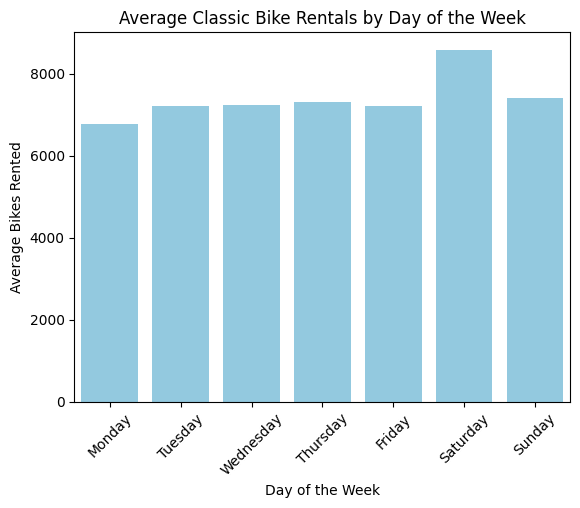

In [ ]:
average_rentals_classic = class_df.groupby('day')['classic_bike_rentals'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
sns.barplot(x=average_rentals_classic.index, y=average_rentals_classic.values, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Bikes Rented')
plt.title('Average Classic Bike Rentals by Day of the Week')
plt.xticks(rotation=45)
plt.show()


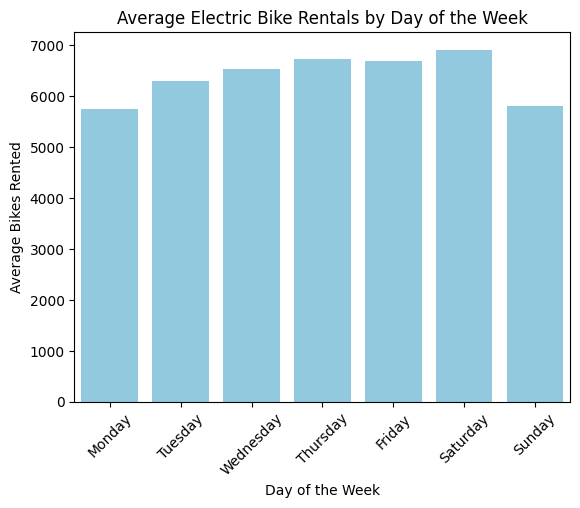

In [ ]:
average_rentals_e = elect_df.groupby('day')['elect_bike_rentals'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
sns.barplot(x=average_rentals_e.index, y=average_rentals_e.values, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Bikes Rented')
plt.title('Average Electric Bike Rentals by Day of the Week')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.show()

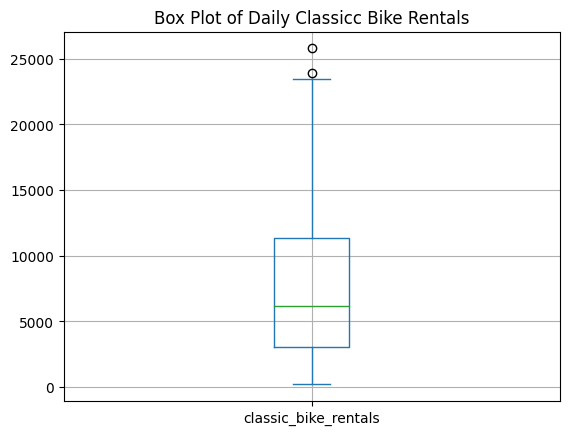

In [ ]:
# Displaying basic plots to visualize any obvious patterns and trends
class_df['classic_bike_rentals'].plot(kind='box')
plt.title('Box Plot of Daily Classicc Bike Rentals')
plt.grid(True)
plt.show()

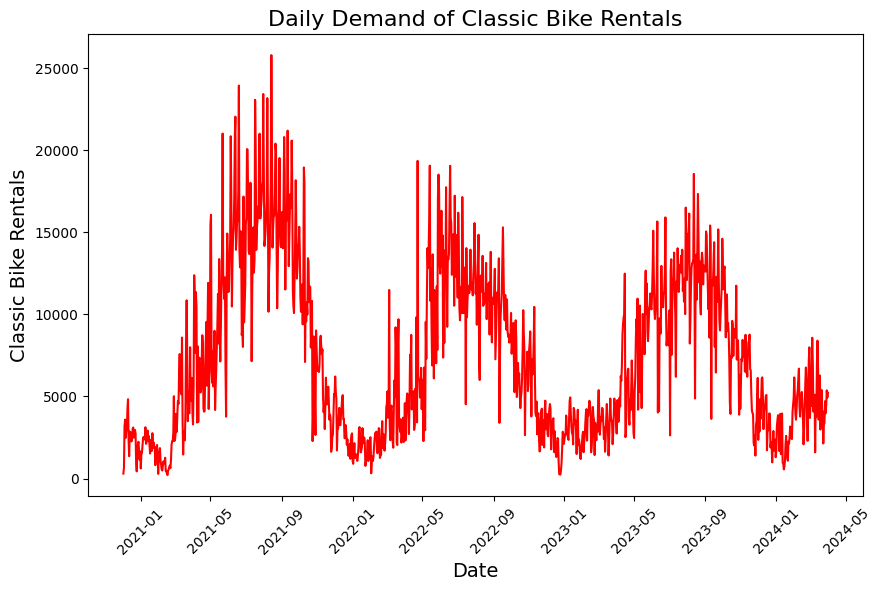

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(class_df.index, class_df['classic_bike_rentals'], color = 'red')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Classic Bike Rentals', fontsize=14)
plt.title('Daily Demand of Classic Bike Rentals', fontsize=16)

plt.xticks(rotation=45)
plt.show()

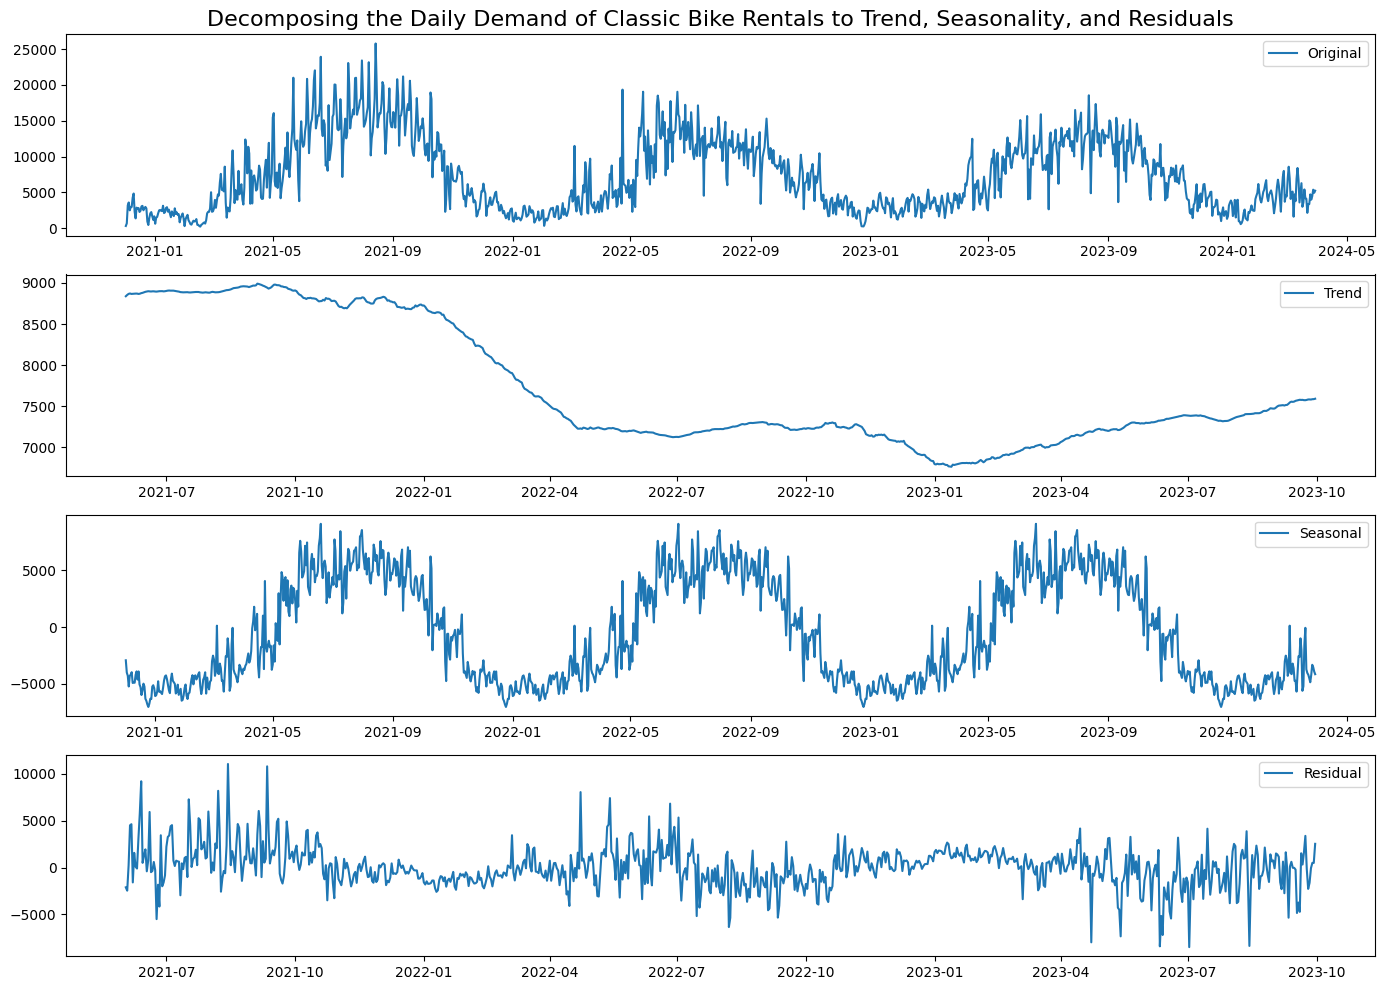

In [ ]:
# Decomposing the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(class_df['classic_bike_rentals'], model='additive', period=365)

# Plotting the decomposed components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.title('Decomposing the Daily Demand of Classic Bike Rentals to Trend, Seasonality, and Residuals', fontsize=16)
plt.plot(decomposition.observed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


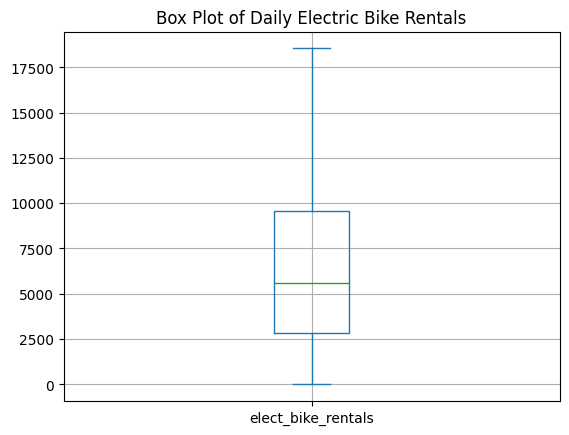

In [ ]:
# Displaying basic plots to visualize any obvious patterns and trends
elect_df['elect_bike_rentals'].plot(kind='box')
plt.title('Box Plot of Daily Electric Bike Rentals')
plt.grid(True)
plt.show()

The box plot provides a summary of the distribution of daily rentals. The presence of outliers indicates days with exceptionally high or low rentals compared to typical days. The median value is lower than the mean, suggesting a right-skewed distribution.

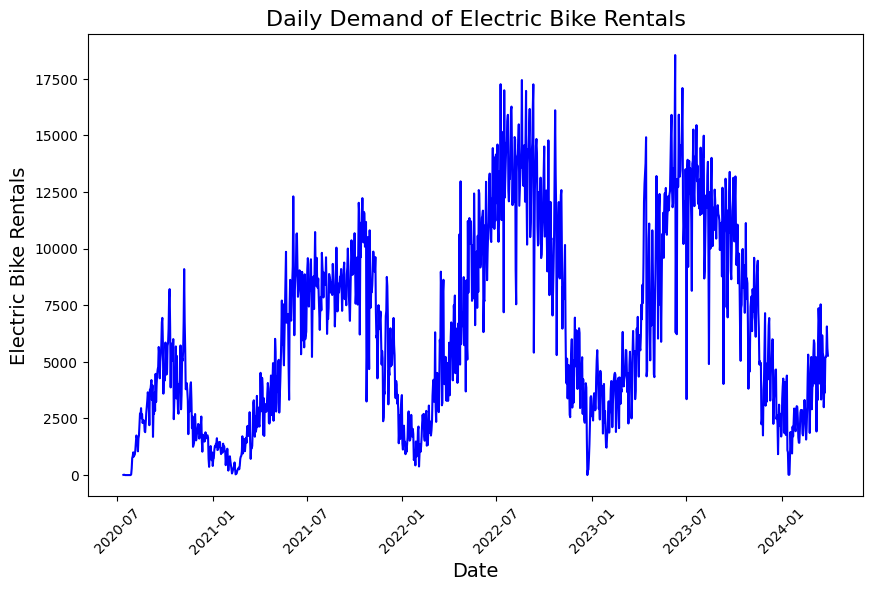

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(elect_df.index, elect_df['elect_bike_rentals'], color = 'blue')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Electric Bike Rentals', fontsize=14)
plt.title('Daily Demand of Electric Bike Rentals', fontsize=16)

plt.xticks(rotation=45)

plt.show()

The time series plot shows significant variations in the number of daily rentals over time. There appears to be some seasonal trends, with peaks possibly indicating higher demand during certain times of the year. Also, there are some sharp spikes and drops which could be influenced by external factors or data anomalies.

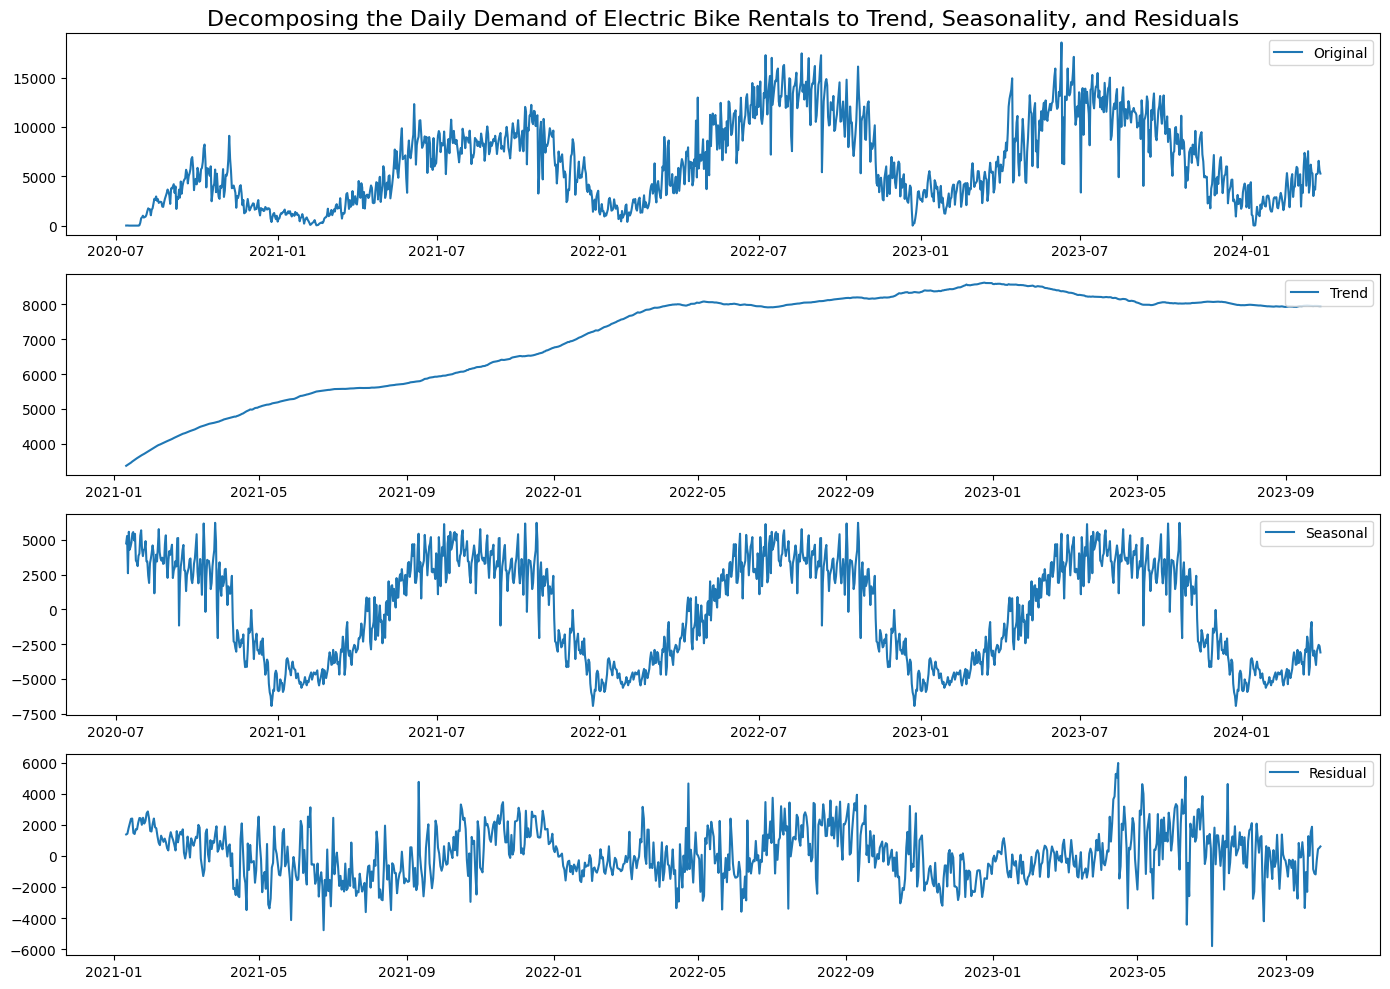

In [ ]:
# Decomposing the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(elect_df['elect_bike_rentals'], model='additive', period=365)

# Plotting the decomposed components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.title('Decomposing the Daily Demand of Electric Bike Rentals to Trend, Seasonality, and Residuals', fontsize=16)
plt.plot(decomposition.observed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The decomposition of the electric bike rentals time series into its components—trend, seasonality, and residuals—provides the following insights:

* Original Series: As previously observed, the original data shows substantial fluctuations over time.
* Trend Component: There appears to be a somewhat consistent upward or stable trend in bike rentals over time, indicating an increase or stability in usage as time progresses.
* Seasonal Component: The seasonal plot clearly exhibits strong seasonality. This pattern is likely annual, reflecting changes in bike rental demand across different seasons.
* Residual Component: The residuals, which represent the irregularities that are not explained by the trend or seasonality, show some random fluctuations. However, there are periods where these residuals are particularly high, suggesting additional unexplained variance on those days.

<a name="Data-Transformation"></a>
## 5. Data Transformation

1. [Classic Bike Transformation](#Classic-Bike-Transformation)
  * [Classic Bike Log Transformation](#Classic-Bike-Log-Transformation)
  * [Classic Bike Difference Transformation](#Classic-Bike-Difference-Transformation)

2. [Electric Bike Transformation](#Electric-Bike-Transformation)
  * [Electric Bike Log Transformation](#Electric-Bike-Log-Transformation)
  * [Electric Bike Difference Transformation](#Electric-Bike-Difference-Transformation)

<a name="Classic-Bike-Transformation"></a>
### 5.1 Classic Bike Transformation

<a name="Classic-Bike-Log-Transformation"></a>
#### a. Classic Bike Log Transformation

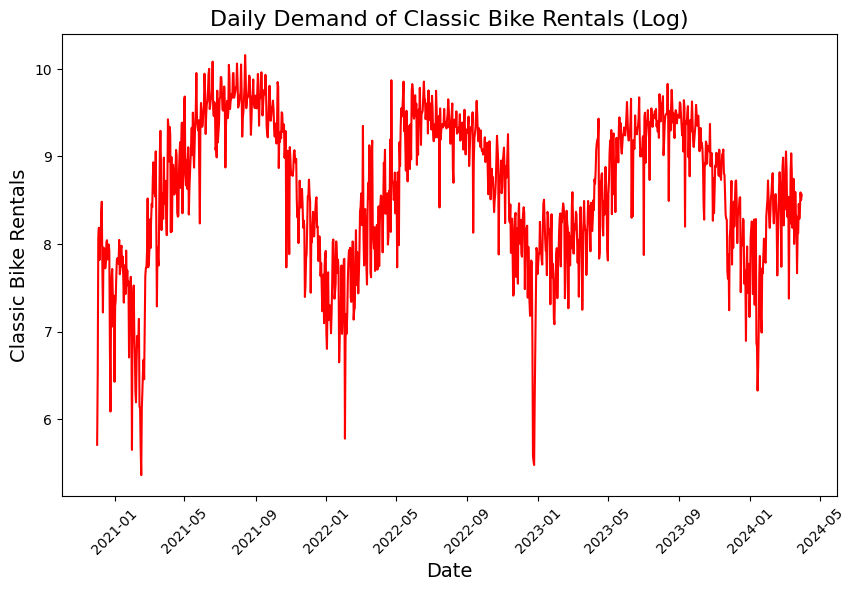

In [ ]:
class_df['log_classic_bike_rentals'] = np.log(class_df['classic_bike_rentals'])
plt.figure(figsize=(10, 6))
plt.plot(class_df.index, class_df['log_classic_bike_rentals'], color = 'red')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Classic Bike Rentals', fontsize=14)
plt.title('Daily Demand of Classic Bike Rentals (Log)', fontsize=16)

plt.xticks(rotation=45)

plt.show()

In [ ]:
## test stationary
adf_result = adfuller(class_df[class_df.columns[-1]])
adf_result

(-2.467954921769883,
 0.12346716809436559,
 22,
 1192,
 {'1%': -3.4358478507713777,
  '5%': -2.863967751840151,
  '10%': -2.568062580992973},
 905.6029861325433)

Based on the ADF result, the p value is larger than 0.05, reject null hypthesis, so we need to take difference transformation

<a name="Classic-Bike-Difference-Transformation"></a>
#### b. Classic-Bike-Difference Transformation

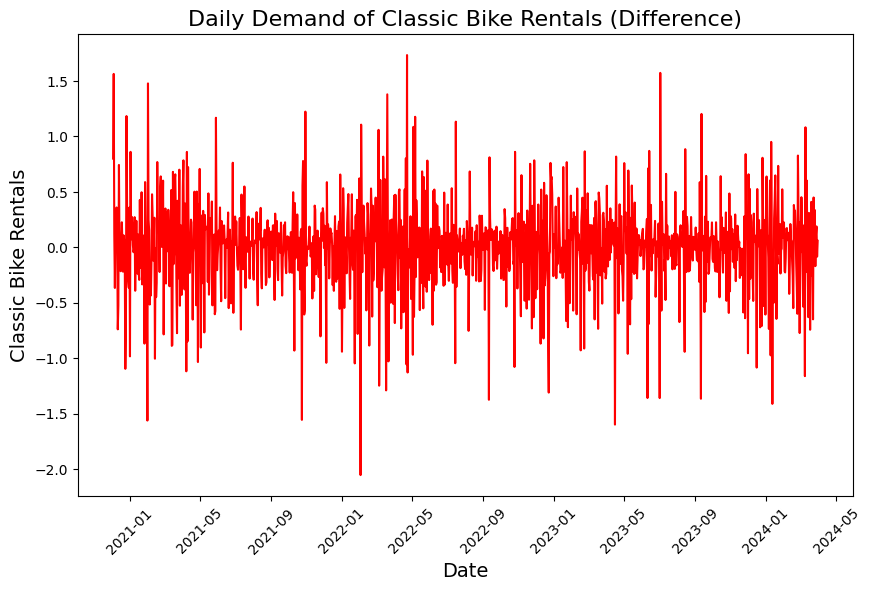

In [ ]:
# Differencing the series
class_df['Differenced'] = class_df[class_df.columns[-1]].diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(class_df.index, class_df['Differenced'], color = 'red')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Classic Bike Rentals', fontsize=14)
plt.title('Daily Demand of Classic Bike Rentals (Difference)', fontsize=16)

plt.xticks(rotation=45)
plt.show()


In [ ]:
# Perform the Augmented Dickey-Fuller test on the differenced data
adf_result_diff = adfuller(class_df['Differenced'].dropna())
adf_result_diff

(-10.859590757061333,
 1.4578526370040222e-19,
 19,
 1194,
 {'1%': -3.4358386217286885,
  '5%': -2.8639636801920956,
  '10%': -2.5680604125597277},
 908.2749670259309)

p value<0.05, close to 0, data is stationary

In [ ]:
class_df = class_df[class_df['Differenced'].notna()]

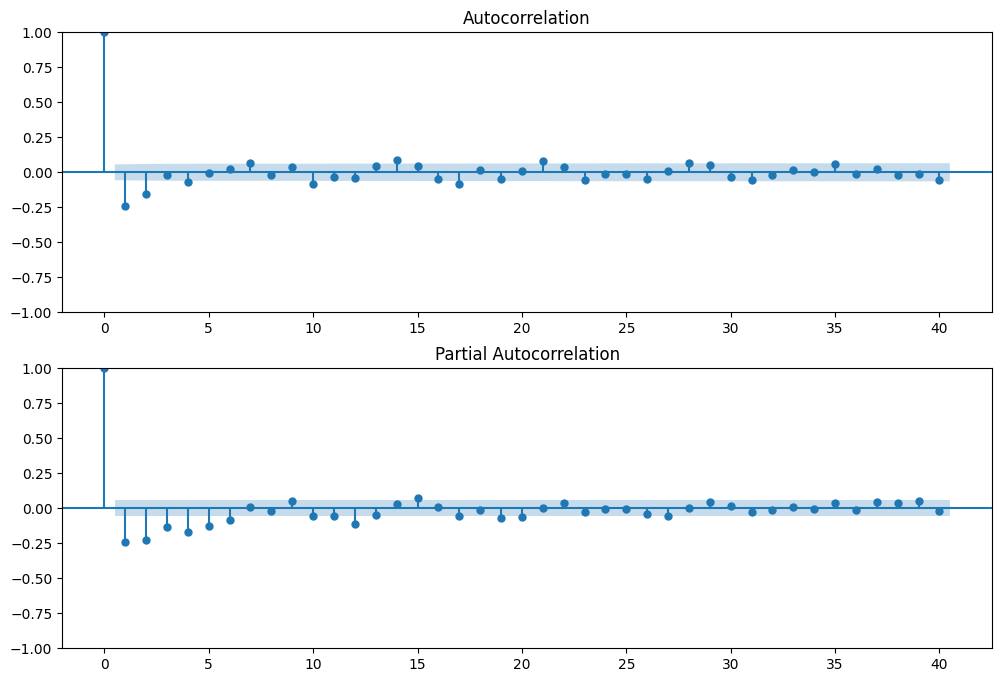

In [ ]:
# identify potential parameters by trying ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the Autocorrelation Function (ACF)
plot_acf(class_df['Differenced'].dropna(), lags=40, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(class_df['Differenced'].dropna(), lags=40, ax=ax2)
plt.show()

<a name="Electric-Bike-Transformation"></a>
### 5.2 Electric Bike Transformation

In [ ]:
elect_df

elect_bike_rentals        day
started_at                               
2020-07-13                   8     Monday
2020-07-14                  14    Tuesday
2020-07-15                  13  Wednesday
2020-07-16                   0   Thursday
2020-07-17                   0     Friday
...                        ...        ...
2024-03-26                5208    Tuesday
2024-03-27                5312  Wednesday
2024-03-28                6564   Thursday
2024-03-29                5585     Friday
2024-03-30                5273   Saturday

[1357 rows x 2 columns]

<a name="Electric-Bike-Log-Transformation"></a>
#### a. Electric Bike Log Transformation

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


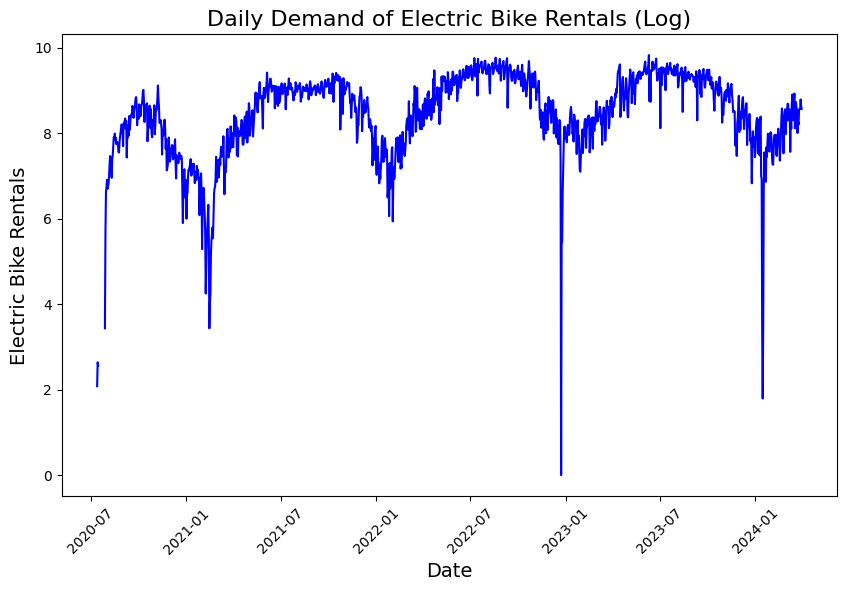

In [ ]:
elect_df['log_elect_bike_rentals'] = np.log(elect_df['elect_bike_rentals'])
plt.figure(figsize=(10, 6))
plt.plot(elect_df.index, elect_df['log_elect_bike_rentals'], color = 'blue')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Electric Bike Rentals', fontsize=14)
plt.title('Daily Demand of Electric Bike Rentals (Log)', fontsize=16)

plt.xticks(rotation=45)

plt.show()

In [ ]:
elect_df = elect_df[elect_df['log_elect_bike_rentals'] != float('-inf')]
elect_df

elect_bike_rentals        day  log_elect_bike_rentals
started_at                                                       
2020-07-13                   8     Monday                2.079442
2020-07-14                  14    Tuesday                2.639057
2020-07-15                  13  Wednesday                2.564949
2020-07-28                  31    Tuesday                3.433987
2020-07-29                 287  Wednesday                5.659482
...                        ...        ...                     ...
2024-03-26                5208    Tuesday                8.557951
2024-03-27                5312  Wednesday                8.577724
2024-03-28                6564   Thursday                8.789355
2024-03-29                5585     Friday                8.627840
2024-03-30                5273   Saturday                8.570355

[1345 rows x 3 columns]

In [ ]:
## test stationary
adf_result = adfuller(elect_df['log_elect_bike_rentals'])
adf_result

(-2.8839979459818124,
 0.047240713585156066,
 19,
 1325,
 {'1%': -3.435294916169133,
  '5%': -2.863723787379918,
  '10%': -2.5679326566037735},
 1353.1334161865007)


Interpretation:
* The p-value is less than 0.05.This suggests that the series is stationary.

In [ ]:
kpss_stats=kpss(elect_df[elect_df.columns[-1]], 'c')
kpss_stats

<ipython-input-95-32e14d2bb934>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stats=kpss(elect_df[elect_df.columns[-1]], 'c')


(1.1480004388301237,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

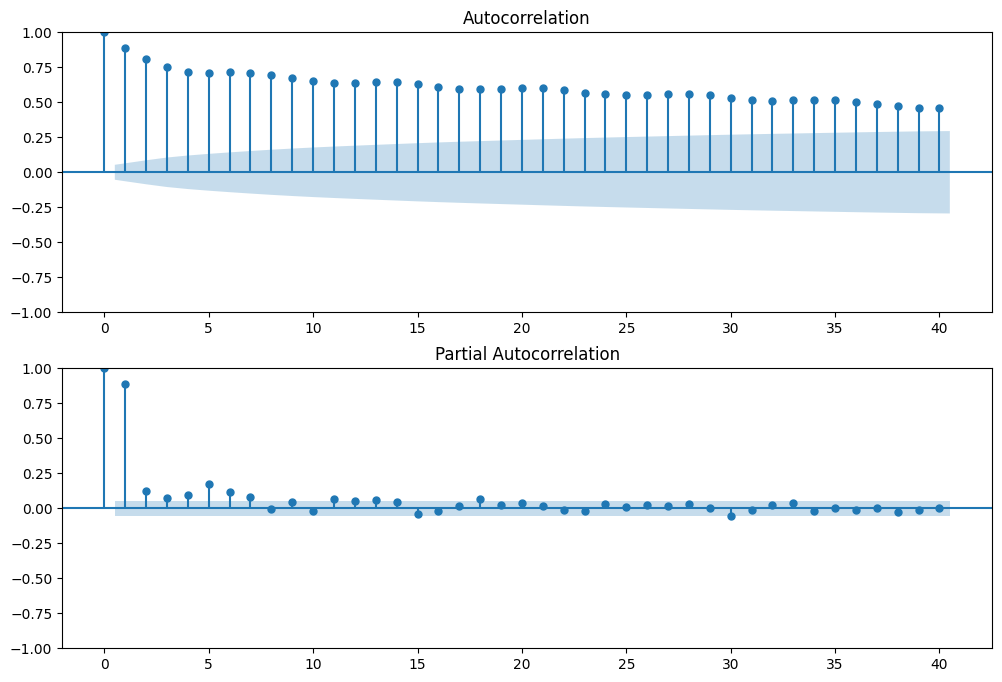

In [ ]:

# identify potential parameters by trying ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the Autocorrelation Function (ACF)
plot_acf(elect_df['log_elect_bike_rentals'].dropna(), lags=40, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(elect_df['log_elect_bike_rentals'].dropna(), lags=40, ax=ax2)

plt.show()

Both ADF and KPSS indicates the log-transformed data is stationary. but acf plot shows the data is still non-stationary. then try differencing

<a name="Electric-Bike-Difference-Transformation"></a>
#### b. Electric Bike Difference Transformation

<ipython-input-97-f311b1f68697>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elect_df['Differenced'] = elect_df[elect_df.columns[-1]].diff().dropna()


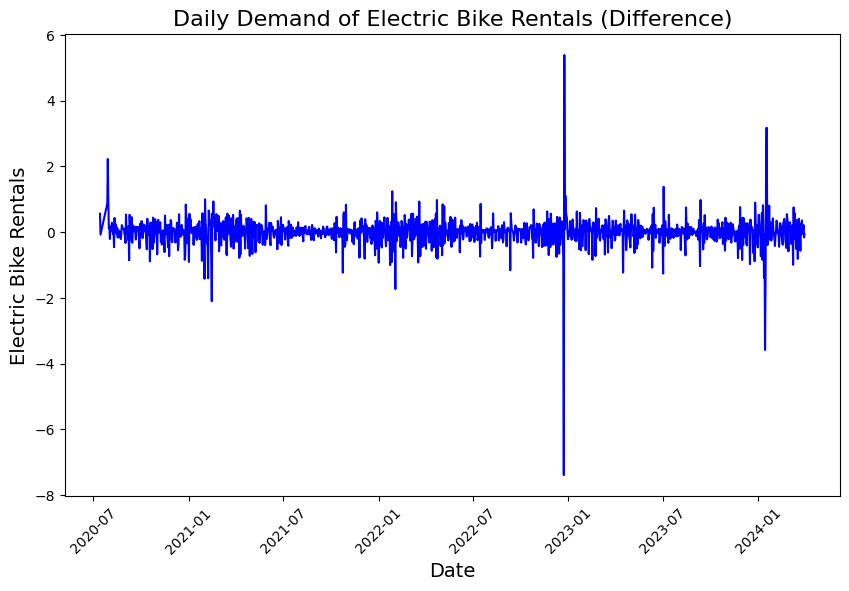

(-11.562302061590916,
 3.2480762955317108e-21,
 18,
 1325,
 {'1%': -3.435294916169133,
  '5%': -2.863723787379918,
  '10%': -2.5679326566037735},
 1357.5456802509739)

In [ ]:
# Differencing the series
elect_df['Differenced'] = elect_df[elect_df.columns[-1]].diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(elect_df.index, elect_df['Differenced'], color = 'blue')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Electric Bike Rentals', fontsize=14)
plt.title('Daily Demand of Electric Bike Rentals (Difference)', fontsize=16)

plt.xticks(rotation=45)

plt.show()
# Perform the Augmented Dickey-Fuller test on the differenced data
adf_result_diff = adfuller(elect_df['Differenced'].dropna())

adf_result_diff

<ipython-input-98-6f5834308715>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elect_df['diff_elect_bike_rentals'] = elect_df['elect_bike_rentals'].diff()


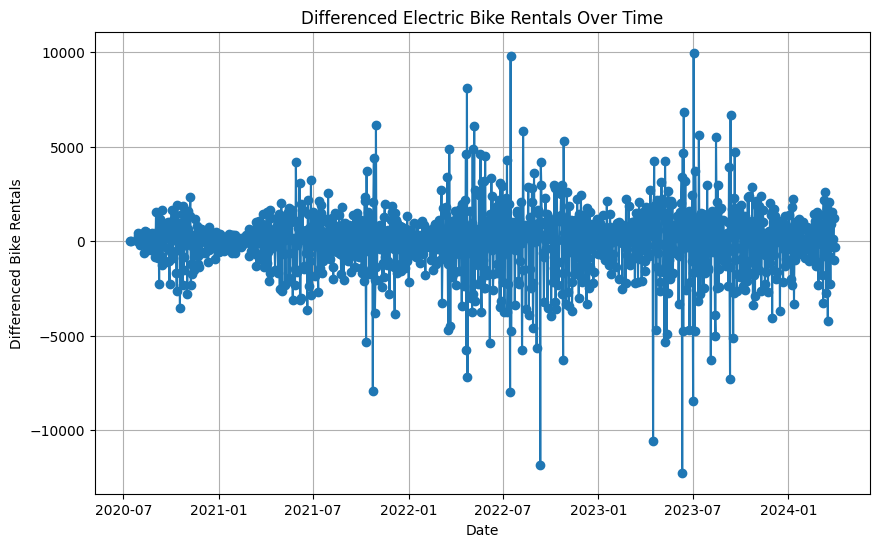

(-9.471577896980115,
 4.092750264125932e-16,
 {'1%': -3.4353061595148073,
  '5%': -2.863728748588099,
  '10%': -2.567935298646666})

In [ ]:
# Differencing the series to achieve stationarity
elect_df['diff_elect_bike_rentals'] = elect_df['elect_bike_rentals'].diff()

# Dropping any NaN values that result from differencing
bike_data_diff = elect_df.dropna()

# Plotting the differenced data
plt.figure(figsize=(10, 6))
plt.plot(bike_data_diff.index, bike_data_diff['diff_elect_bike_rentals'], marker='o', linestyle='-')
plt.title('Differenced Electric Bike Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Bike Rentals')
plt.grid(True)
plt.show()

# Re-running the Augmented Dickey-Fuller test on the differenced data
adf_result_diff = adfuller(bike_data_diff['diff_elect_bike_rentals'])
adf_statistic_diff, adf_p_value_diff, adf_critical_values_diff = adf_result_diff[0], adf_result_diff[1], adf_result_diff[4]

adf_statistic_diff, adf_p_value_diff, adf_critical_values_diff


Plot of Differenced Data:
The plot shows that differencing has removed much of the trend, resulting in a series that looks more stationary than the original. There are no long-term upward or downward trends visible, and the series seems to fluctuate around a mean of zero.


Interpretation:
* The ADF statistic is significantly below the critical values, and the p-value is practically zero, strongly suggesting that the differenced series is stationary.
* With the series now stationary, it's suitable for ARIMA or SARIMA modeling, which requires this condition for effective forecasting.

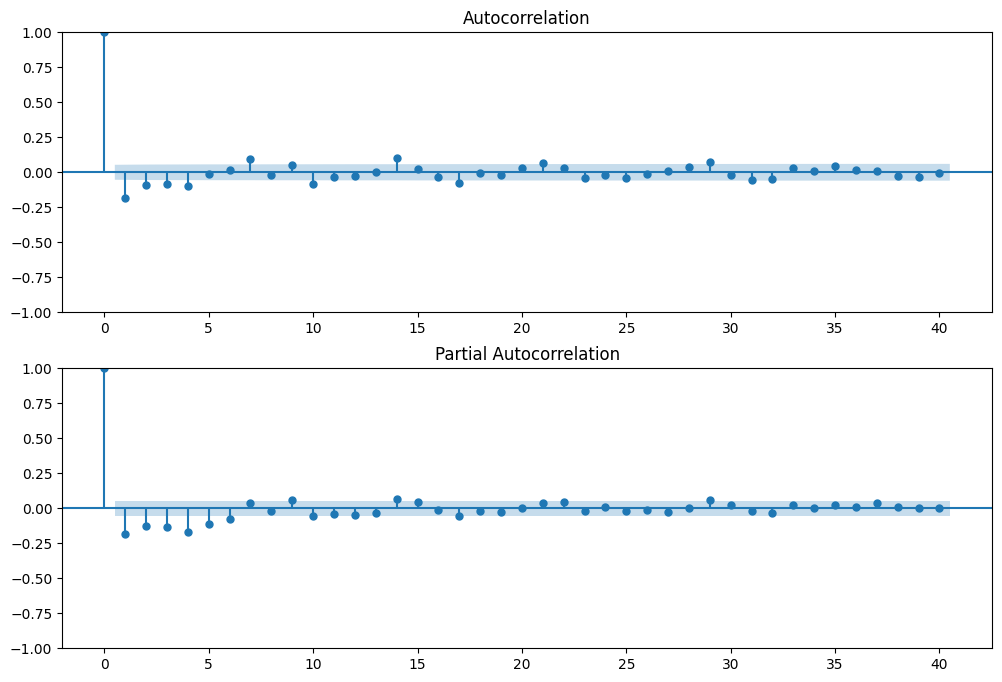

In [ ]:
# identify potential parameters by trying ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the Autocorrelation Function (ACF)
plot_acf(elect_df['Differenced'].dropna(), lags=40, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(elect_df['Differenced'].dropna(), lags=40, ax=ax2)
plt.show()

<a name="Build-Time-Series-Model-&-Evaluation"></a>
## 6. Build Time Series Model & Evaluation

1. [Calculate Cutoff Date](#Calculate-Cutoff-Date)
2. [Training Testing Data](#Training-Testing-Data)
3. [Long Short Term Memory](#Long-Short-Term-Memory)
  * [LSTMs Classic Bike](#LSTMs-Classic-Bike)
  * [LSTMs Electric Bike](#LSTMs-Electric-Bike)
4. [SARIMA & ARIMA](#SARIMA-&-ARIMA)
  * [SARIMA & ARIMA Classic Bike](#SARIMA-&-ARIMA-Classic-Bike)
  * [SARIMA & ARIMA Electric Bike](#SARIMA-&-ARIMA-Electric-Bike)
5. [Uber Orbit Damped Local Trend](#Uber-Orbit-Damped-Local-Trend)
  * [Orbit Damped Local Trend Classic Bike](#Orbit-Damped-Local-Trend-Classic-Bike)
  * [Orbit Damped Local Trend Electric Bike](#Orbit-Damped-Local-Trend-Electric-Bike)
6. [Facebook Prophet](#Facebook-Prophet)
  * [Prophet Classic Bike](#Prophet-Classic-Bike)
  * [Prophet Electric Bike](#Prophet-Electric-Bike)

<a name="Calculate-Cutoff-Date"></a>
### 6.1 Calculate Cutoff Date

#### Classic Bike Cutoff Date

In [ ]:
total_days_class = (class_df.index.max() - class_df.index.min()).days + 1
print(f"Total number of days of Classic Bike Data: {total_days_class}")

Total number of days of Classic Bike Data: 1214


In [ ]:
training_days_class = int(total_days_class * 0.8)
cutoff_date_class = class_df.index.min() + pd.Timedelta(days=training_days_class)
print(f"Cutoff date for training set Classic Bike Data: {cutoff_date_class}")

Cutoff date for training set Classic Bike Data: 2023-08-01 00:00:00


#### Electric Bike Cutoff Date

In [ ]:
total_days_elect = (elect_df.index.max() - elect_df.index.min()).days + 1
print(f"Total number of days of Electric Bike Data: {total_days_elect}")

Total number of days of Electric Bike Data: 1357


In [ ]:
training_days_elect = int(total_days_elect * 0.8)
cutoff_date_elect = elect_df.index.min() + pd.Timedelta(days=training_days_elect)
print(f"Cutoff date for training set Electric Bike Data: {cutoff_date_elect}")

Cutoff date for training set Electric Bike Data: 2023-07-03 00:00:00


<a name="Training-Testing-Data"></a>
### 6.2 Training Testing Data

#### Classic Bike Split

In [ ]:
# Split the data into training and test sets
class_train_df = class_df.loc[class_df.index < cutoff_date_class]
class_test_df = class_df.loc[class_df.index >= cutoff_date_class]

print(f"Shape of class_train_df: {class_train_df.shape}")
print(f"Shape of class_test_df: {class_test_df.shape}")

Shape of class_train_df: (971, 4)
Shape of class_test_df: (243, 4)


#### Electric Bike Split

In [ ]:
elect_train_df = elect_df.loc[elect_df.index < cutoff_date_elect]
elect_test_df = elect_df.loc[elect_df.index >= cutoff_date_elect]

print(f"Shape of elect_train_df: {elect_train_df.shape}")
print(f"Shape of celect_test_df: {elect_test_df.shape}")

Shape of elect_train_df: (1073, 5)
Shape of celect_test_df: (272, 5)


<a name="Long-Short-Term-Memory"></a>
### 6.3 Long Short Term Memory

<a name="LSTMs-Classic-Bike"></a>
#### (a) LSTMs Classic Bike

In [ ]:
class_train_df.dropna(subset=['classic_bike_rentals'], inplace=True)
class_test_df.dropna(subset=['classic_bike_rentals'], inplace=True)

<ipython-input-39-c94de804c9af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_train_df.dropna(subset=['classic_bike_rentals'], inplace=True)
<ipython-input-39-c94de804c9af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_test_df.dropna(subset=['classic_bike_rentals'], inplace=True)


In [ ]:
class_training_set = class_train_df['classic_bike_rentals'].values.reshape(-1, 1)
class_validation_set = class_test_df['classic_bike_rentals'].values.reshape(-1, 1)
# Combine training and validation sets
combined_set = np.concatenate((class_training_set, class_validation_set), axis=0)

In [ ]:
# Fit the scaler to the training data
sc = MinMaxScaler(feature_range=(0, 1))

combined_set_scaled = sc.fit_transform(combined_set)

# Split the scaled data into training and validation sets
class_training_set_scaled = combined_set_scaled[:len(class_training_set), :]
class_validation_set_scaled = combined_set_scaled[len(class_training_set):, :]

In [ ]:
def create_sequences_class(data, seq_length=30, n_lags=2):
    X = []
    y = []
    for i in range(seq_length + n_lags, len(data)):
        X.append(np.concatenate([data[i-seq_length-n_lags:i-n_lags, 0], data[i-n_lags:i, 0]], axis=0))
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train_class, y_train_class = create_sequences_class(class_training_set_scaled)
X_validation_class, y_validation_class = create_sequences_class(class_validation_set_scaled)

# Reshape inputs for LSTM model
X_train_class = np.reshape(X_train_class, (X_train_class.shape[0], X_train_class.shape[1], 1))
X_validation_class = np.reshape(X_validation_class, (X_validation_class.shape[0], X_validation_class.shape[1], 1))

In [ ]:
%%time

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        input_shape=(X_train_class.shape[1], 1)
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(keras.layers.LSTM(
            units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32),
            return_sequences=True if i < hp.Int('num_layers', 1, 5) - 1 else False
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        ),
        loss='mean_squared_error'
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning',
    overwrite=True
)

tuner.search_space_summary()


tuner.search(
    X_train_class, y_train_class,
    epochs=100,
    batch_size=64,
    validation_data=(X_validation_class, y_validation_class),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model_lstm_class = tuner.hypermodel.build(best_hps)

model_lstm_class.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_class = model_lstm_class.fit(
    X_train_class, y_train_class,
    epochs=100, batch_size=64,
    validation_data=(X_validation_class, y_validation_class)
)

Trial 20 Complete [00h 03m 47s]
val_loss: 0.01859133690595627

Best val_loss So Far: 0.005138479173183441
Total elapsed time: 00h 45m 35s
Epoch 1/100
15/15 [==============================] - 14s 721ms/step - loss: 0.0334 - val_loss: 0.0060
Epoch 2/100
15/15 [==============================] - 8s 508ms/step - loss: 0.0123 - val_loss: 0.0054
Epoch 3/100
15/15 [==============================] - 10s 681ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 4/100
15/15 [==============================] - 8s 515ms/step - loss: 0.0116 - val_loss: 0.0054
Epoch 5/100
15/15 [==============================] - 10s 652ms/step - loss: 0.0114 - val_loss: 0.0071
Epoch 6/100
15/15 [==============================] - 9s 585ms/step - loss: 0.0107 - val_loss: 0.0062
Epoch 7/100
15/15 [==============================] - 9s 578ms/step - loss: 0.0109 - val_loss: 0.0060
Epoch 8/100
15/15 [==============================] - 10s 689ms/step - loss: 0.0111 - val_loss: 0.0052
Epoch 9/100
15/15 [==============================]

##### Learning Curve (Classic Bike LSTM Model)

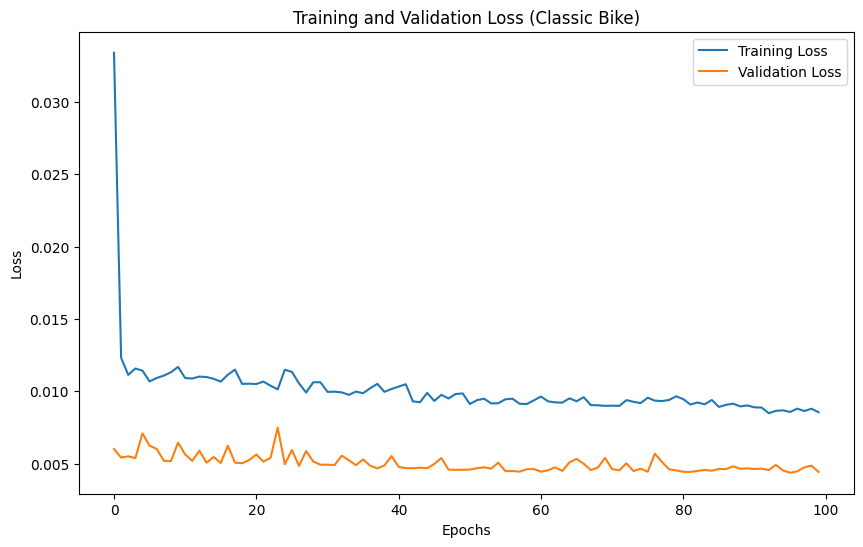

In [ ]:
# Get the training and validation loss histories
training_loss_class = history_lstm_class.history['loss']
validation_loss_class = history_lstm_class.history['val_loss']

# Create a plot for the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss_class, label='Training Loss')
plt.plot(validation_loss_class, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Classic Bike)')
plt.legend()
plt.show()

##### Evaluation Metrics (Classic Bike LSTM Model)

In [ ]:
# Make predictions
y_pred_class = model_lstm_class.predict(X_validation_class)

# Invert scaling to compare with original prices
y_pred_rescaled_class = sc.inverse_transform(y_pred_class)
y_validation_rescaled_class = sc.inverse_transform(y_validation_class.reshape(-1, 1))

# Calculate the errors
mse_class = mean_squared_error(y_validation_rescaled_class, y_pred_rescaled_class)
rmse_class = np.sqrt(mse_class)
mae_class = mean_absolute_error(y_validation_rescaled_class, y_pred_rescaled_class)
mpe_class = np.mean((y_validation_rescaled_class - y_pred_rescaled_class) / y_validation_rescaled_class) * 100
mape_class = np.mean(np.abs((y_validation_rescaled_class - y_pred_rescaled_class) / y_validation_rescaled_class)) * 100

# Create a dataframe for the metrics
metrics_df_class = pd.DataFrame({
    'MSE': [mse_class],
    'RMSE': [rmse_class],
    'MAE': [mae_class],
    'MPE': [mpe_class],
    'MAPE': [mape_class]
})

print("\nLSTM Model of Evaluation (Classic Bike)\n")
metrics_df_class

7/7 [==============================] - 1s 88ms/step

LSTM Model of Evaluation (Classic Bike)



MSE         RMSE          MAE       MPE       MAPE
0  2.900162e+06  1702.986226  1268.284666 -8.744441  30.254967

##### Residual plot (Classic Bike)

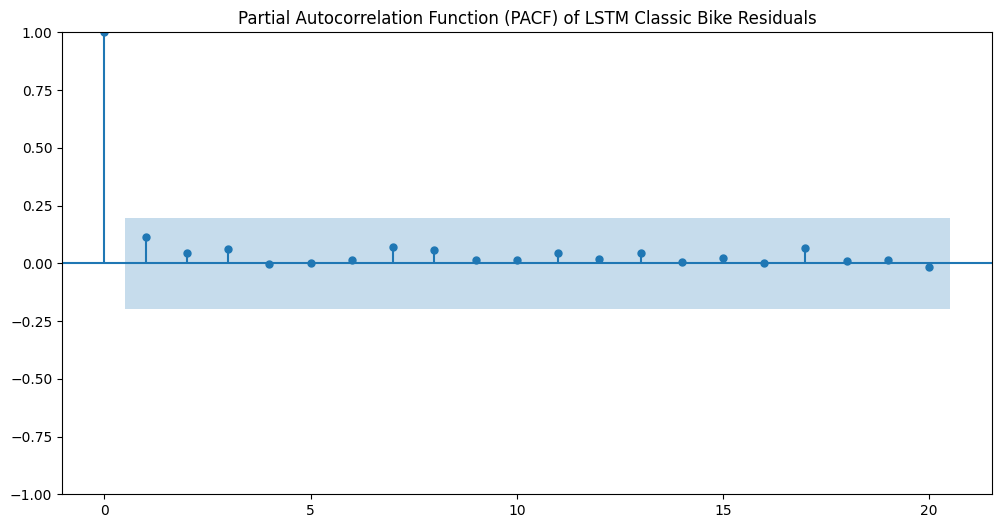

In [ ]:
# Get the model residuals
val_loss_class = np.array(history_lstm_class.history['val_loss'])
loss_class = np.array(history_lstm_class.history['loss'])
residuals_class = val_loss_class - loss_class

# Plot the PACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(residuals_class, lags=20, ax=ax)
plt.title('Partial Autocorrelation Function (PACF) of LSTM Classic Bike Residuals')
plt.show()

##### Ljung-Box test (Classic Bike)

In [ ]:
# Perform Ljung-Box test
lb_class_results = acorr_ljungbox(residuals_class, lags=[5, 10, 15, 20], return_df=True)
lb_class_results

lb_stat  lb_pvalue
5   2.224862   0.817237
10  3.700074   0.959865
15  4.896029   0.992971
20  5.979182   0.998925

##### Prediction Classic Bike

In [ ]:
# Scale the test data
class_test_df_scaled = sc.transform(class_test_df['classic_bike_rentals'].values.reshape(-1, 1))
X_test_class, y_test_class = create_sequences_class(class_test_df_scaled)
X_test_class = np.reshape(X_test_class, (X_test_class.shape[0], X_test_class.shape[1], 1))

y_pred_class = model_lstm_class.predict(X_test_class)

y_pred_class = sc.inverse_transform(y_pred_class)
y_test_class = sc.inverse_transform(y_test_class.reshape(-1, 1))

# Create a datetime index for the test data
test_dates_class = pd.date_range(start=class_test_df.index.min(), end=class_test_df.index.max(), freq='D')

# Get the length of y_test_class
y_test_len_class = y_test_class.shape[0]

# Slice test_dates to match y_test_class length
test_dates_class  = test_dates_class [-y_test_len_class:]


# Calculate the 95% confidence intervals
confidence_level_test_class = 0.95
residuals_class = y_test_class - y_pred_class
residual_std_class = np.std(residuals_class)
z_score_class = norm.ppf((1 + confidence_level_test_class) / 2)
lower_ci_class = y_pred_class - z_score_class * residual_std_class
upper_ci_class = y_pred_class + z_score_class * residual_std_class

# Flatten the confidence intervals to 1-dimensional arrays
lower_ci_class = lower_ci_class.ravel()
upper_ci_class = upper_ci_class.ravel()

# Create a datetime index for the training data
train_dates_class = pd.date_range(start=class_train_df.index.min(), end=class_train_df.index.max(), freq='D')

predicted_df_class = pd.DataFrame({
    'Start_Test_Date': test_dates_class,
    'Classic_Actual_Value': y_test_class.ravel(),
    'Classic_Predicted_Value': y_pred_class.ravel(),
    'Lower CI': lower_ci_class,
    'Upper CI': upper_ci_class
})

# Display the DataFrame
predicted_df_class.head()

7/7 [==============================] - 1s 190ms/step


Start_Test_Date  Classic_Actual_Value  Classic_Predicted_Value  \
0      2023-09-02               15042.0             13020.050781   
1      2023-09-03               14795.0             13566.754883   
2      2023-09-04               13181.0             12405.963867   
3      2023-09-05               11716.0             11316.838867   
4      2023-09-06               10307.0             10956.805664   

       Lower CI      Upper CI  
0   9699.286133  16340.815430  
1  10245.990234  16887.519531  
2   9085.199219  15726.728516  
3   7996.074219  14637.603516  
4   7636.041016  14277.570312

In [ ]:
# Save LSTMs Model prediction of classic bike result

predicted_df_class.to_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/predicted_df_classic_lstms.csv", index=False)

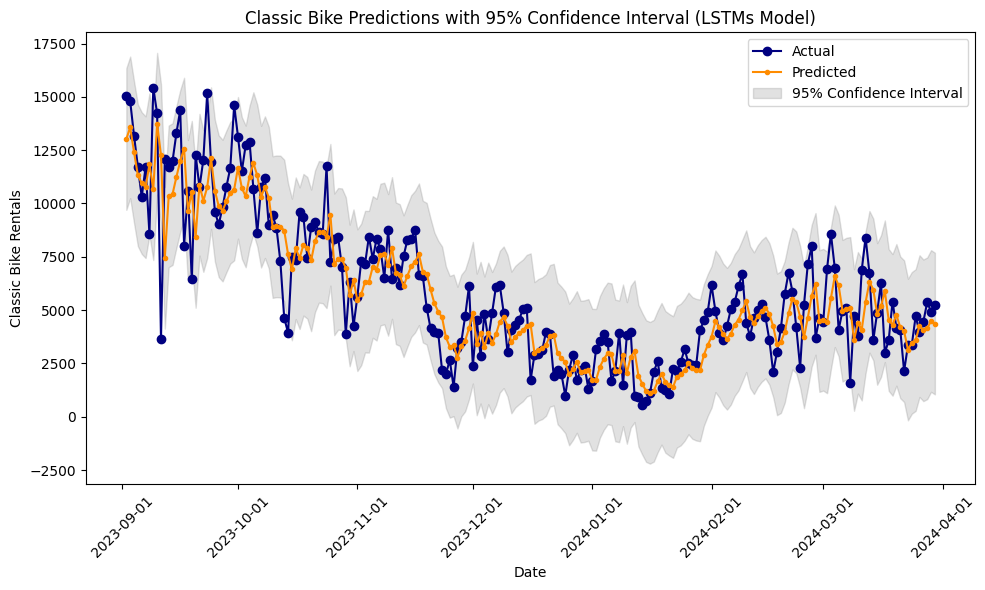

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_dates_class, y_test_class, label='Actual', marker='o', color = 'navy')
ax.plot(test_dates_class, y_pred_class, label='Predicted', marker = '.', color = 'darkorange')
ax.fill_between(test_dates_class, lower_ci_class, upper_ci_class, alpha=0.2, label='95% Confidence Interval', color='dimgray')
ax.set_xlabel('Date')
ax.set_ylabel('Classic Bike Rentals')
ax.set_title('Classic Bike Predictions with 95% Confidence Interval (LSTMs Model)')

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.legend()
plt.tight_layout()
plt.show()

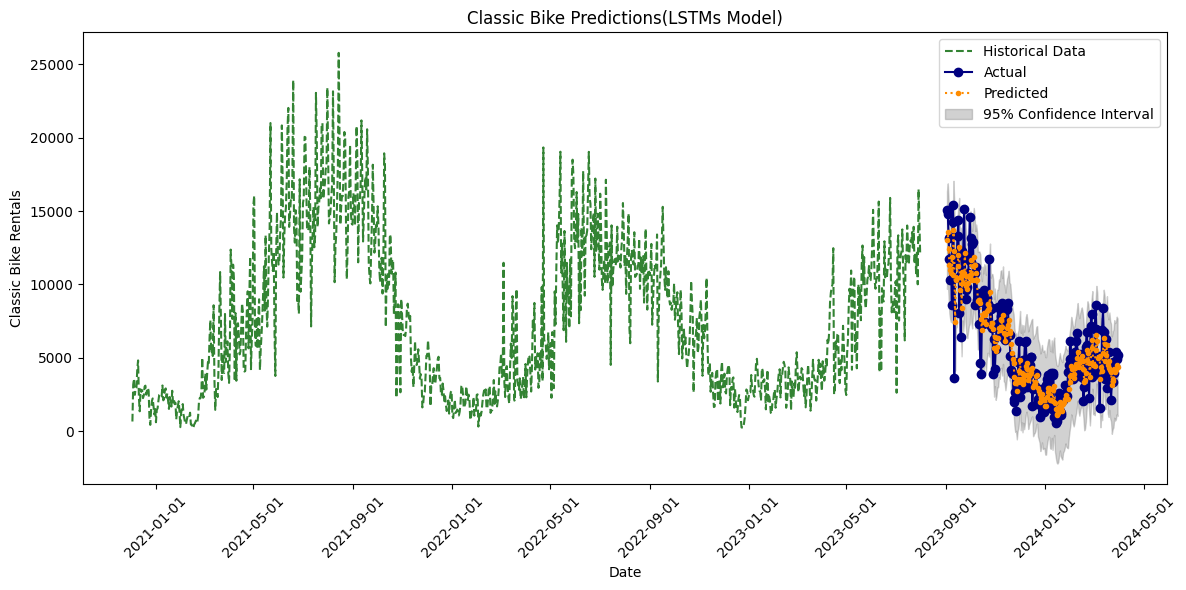

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_dates_class, class_train_df['classic_bike_rentals'], label='Historical Data', alpha=0.8, color='darkgreen', linestyle='--')
ax.plot(test_dates_class, y_test_class, label='Actual', marker='o', color='navy', linestyle='-')
ax.plot(test_dates_class, y_pred_class, label='Predicted', marker='.', color='darkorange', linestyle=':')
ax.fill_between(test_dates_class, lower_ci_class, upper_ci_class, alpha=0.3, label='95% Confidence Interval', color='dimgray')
ax.set_xlabel('Date')
ax.set_ylabel('Classic Bike Rentals')
ax.set_title('Classic Bike Predictions(LSTMs Model)')
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.legend()
plt.tight_layout()
plt.show()

<a name="LSTMs-Electric-Bike"></a>
#### (b) LSTMs Electric Bike

In [ ]:
elect_train_df.dropna(subset=['elect_bike_rentals'], inplace=True)
elect_test_df.dropna(subset=['elect_bike_rentals'], inplace=True)

<ipython-input-63-4cb917406275>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elect_train_df.dropna(subset=['elect_bike_rentals'], inplace=True)
<ipython-input-63-4cb917406275>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elect_test_df.dropna(subset=['elect_bike_rentals'], inplace=True)


In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))

elect_training_set = elect_train_df['elect_bike_rentals'].values.reshape(-1, 1)
elect_validation_set = elect_test_df['elect_bike_rentals'].values.reshape(-1, 1)
elect_combined_set = np.concatenate((elect_training_set, elect_validation_set), axis=0)

# Fit the scaler to the training data
elect_combined_set_scaled = sc.fit_transform(elect_combined_set)

# Split the scaled data into training and validation sets
elect_training_set_scaled = elect_combined_set_scaled[:len(elect_training_set), :]
elect_validation_set_scaled = elect_combined_set_scaled[len(elect_training_set):, :]

In [ ]:
def create_sequences_elect(data, seq_length=60, n_lags=2):
    X = []
    y = []
    for i in range(seq_length + n_lags, len(data)):
        X.append(np.concatenate([data[i-seq_length-n_lags:i-n_lags, 0], data[i-n_lags:i, 0]], axis=0))
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train_elect, y_train_elect = create_sequences_elect(elect_training_set_scaled)
X_validation_elect, y_validation_elect = create_sequences_elect(elect_validation_set_scaled)

# Reshape inputs for LSTM model
X_train_elect = np.reshape(X_train_elect, (X_train_elect.shape[0], X_train_elect.shape[1], 1))
X_validation_elect = np.reshape(X_validation_elect, (X_validation_elect.shape[0], X_validation_elect.shape[1], 1))

In [ ]:
%%time

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        input_shape=(X_train_elect.shape[1], 1)
    ))
    model.add(keras.layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(keras.layers.LSTM(
            units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32),
            return_sequences=True if i < hp.Int('num_layers', 1, 5) - 1 else False
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        ),
        loss='mean_squared_error'
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning',
    overwrite=True
)

tuner.search_space_summary()


tuner.search(
    X_train_elect, y_train_elect,
    epochs=100,
    batch_size=64,
    validation_data=(X_validation_elect, y_validation_elect),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model_lstm_elect = tuner.hypermodel.build(best_hps)

model_lstm_elect.compile(optimizer = 'adam', loss = 'mean_squared_error')

history_lstm_elect = model_lstm_elect.fit(
    X_train_elect, y_train_elect,
    epochs=100, batch_size=64,
    validation_data=(X_validation_elect, y_validation_elect)
)

Trial 20 Complete [00h 01m 38s]
val_loss: 0.03181834891438484

Best val_loss So Far: 0.007478794548660517
Total elapsed time: 01h 11m 34s
Epoch 1/100
16/16 [==============================] - 22s 1s/step - loss: 0.0500 - val_loss: 0.0087
Epoch 2/100
16/16 [==============================] - 18s 1s/step - loss: 0.0125 - val_loss: 0.0079
Epoch 3/100
16/16 [==============================] - 18s 1s/step - loss: 0.0117 - val_loss: 0.0080
Epoch 4/100
16/16 [==============================] - 18s 1s/step - loss: 0.0109 - val_loss: 0.0094
Epoch 5/100
16/16 [==============================] - 18s 1s/step - loss: 0.0100 - val_loss: 0.0089
Epoch 6/100
16/16 [==============================] - 17s 1s/step - loss: 0.0106 - val_loss: 0.0077
Epoch 7/100
16/16 [==============================] - 18s 1s/step - loss: 0.0101 - val_loss: 0.0077
Epoch 8/100
16/16 [==============================] - 19s 1s/step - loss: 0.0099 - val_loss: 0.0083
Epoch 9/100
16/16 [==============================] - 21s 1s/step - los

In [ ]:
print(model_lstm_elect.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 62, 448)           806400    
                                                                 
 dropout_2 (Dropout)         (None, 62, 448)           0         
                                                                 
 lstm_3 (LSTM)               (None, 192)               492288    
                                                                 
 dropout_3 (Dropout)         (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                                 
Total params: 1298881 (4.95 MB)
Trainable params: 1298881 (4.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


##### Learning Curve (Classic Electric LSTM Model)

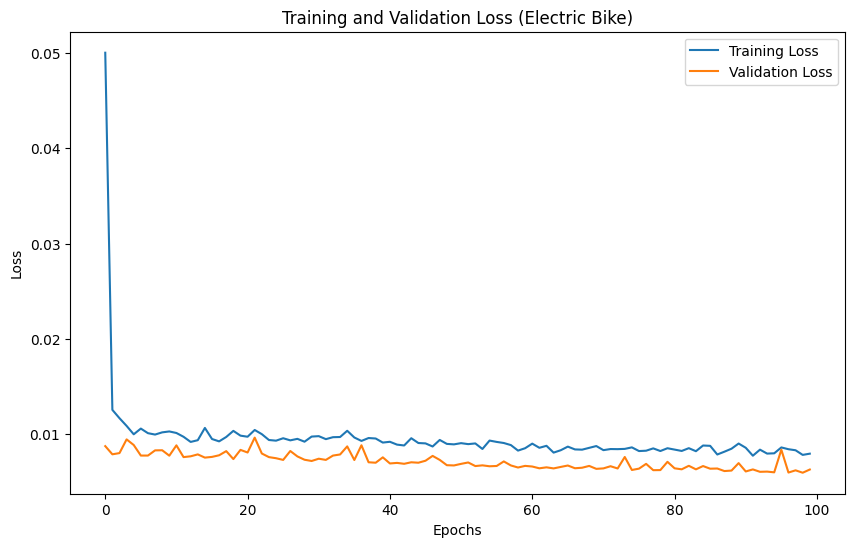

In [ ]:
# Get the training and validation loss histories
training_loss_elect = history_lstm_elect.history['loss']
validation_loss_elect = history_lstm_elect.history['val_loss']

# Create a plot for the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss_elect, label='Training Loss')
plt.plot(validation_loss_elect, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Electric Bike)')
plt.legend()
plt.show()

##### Evaluation Metrics (Electric Bike LSTM Model)

In [ ]:
# Make predictions
y_pred_elect = model_lstm_elect.predict(X_validation_elect)

# Invert scaling to compare with original prices
y_pred_rescaled_elect = sc.inverse_transform(y_pred_elect)
y_validation_rescaled_elect = sc.inverse_transform(y_validation_elect.reshape(-1, 1))

# Calculate the errors
mse_elect = mean_squared_error(y_validation_rescaled_elect, y_pred_rescaled_elect)
rmse_elect = np.sqrt(mean_squared_error(y_validation_rescaled_elect, y_pred_rescaled_elect))
mae_elect = mean_absolute_error(y_validation_rescaled_elect, y_pred_rescaled_elect)
mpe_elect = np.mean((y_validation_rescaled_elect - y_pred_rescaled_elect) / y_validation_rescaled_elect) * 100
mape_elect = np.mean(np.abs((y_validation_rescaled_elect - y_pred_rescaled_elect) / y_validation_rescaled_elect)) * 100


# Create a dataframe for the metrics
metrics_df_elect = pd.DataFrame({
    'MSE': [mse_elect],
    'RMSE': [rmse_elect],
    'MAE': [mae_elect],
    'MPE': [mpe_elect],
    'MAPE': [mape_elect]
})

print("\nLSTM Model of Evaluation (Electric Bike)\n")
metrics_df_elect

7/7 [==============================] - 2s 166ms/step

LSTM Model of Evaluation (Electric Bike)



MSE         RMSE          MAE         MPE        MAPE
0  2.159479e+06  1469.516619  1091.884264 -164.466885  177.775752

##### Residual plot (Electric Bike)

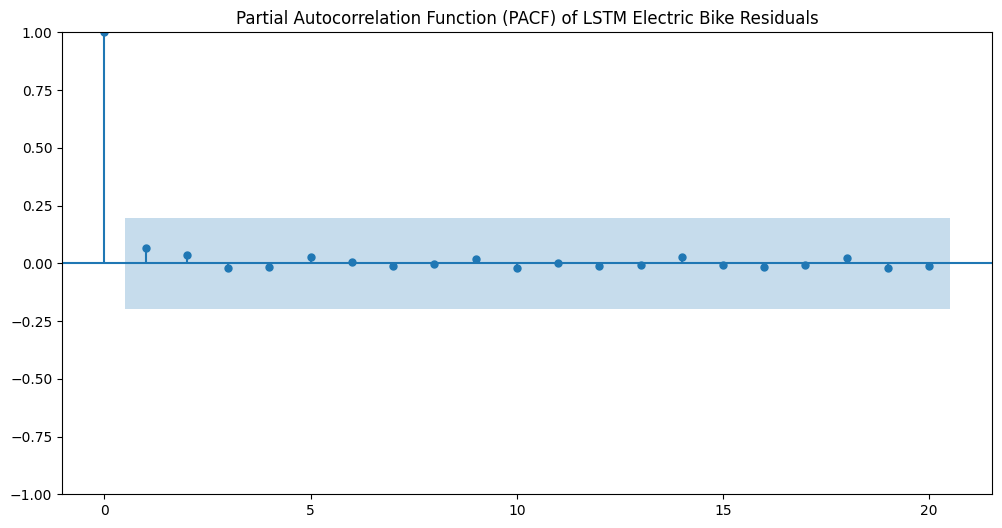

In [ ]:
# Get the model residuals
val_loss_elect = np.array(history_lstm_elect.history['val_loss'])
loss_elect = np.array(history_lstm_elect.history['loss'])
residuals_elect = val_loss_elect - loss_elect

# Plot the PACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(residuals_elect, lags=20, ax=ax)
plt.title('Partial Autocorrelation Function (PACF) of LSTM Electric Bike Residuals')
plt.show()

##### Ljung-Box test (Electric Bike)

In [ ]:
# Perform Ljung-Box test
lb_elect_results = acorr_ljungbox(residuals_elect, lags=[5, 10, 15, 20], return_df=True)
lb_elect_results

lb_stat  lb_pvalue
5   0.727194   0.981443
10  0.800631   0.999939
15  0.906831   1.000000
20  1.042905   1.000000

##### Prediction Electric Bike

In [ ]:
# Scale the test data
elect_test_df_scaled = sc.transform(elect_test_df['elect_bike_rentals'].values.reshape(-1, 1))
X_test_elect, y_test_elect = create_sequences_class(elect_test_df_scaled)
X_test_elect = np.reshape(X_test_elect, (X_test_elect.shape[0], X_test_elect.shape[1], 1))

y_pred_elect = model_lstm_elect.predict(X_test_elect)

y_pred_elect = sc.inverse_transform(y_pred_elect)
y_test_elect = sc.inverse_transform(y_test_elect.reshape(-1, 1))

# Create a datetime index for the test data
test_dates_elect = pd.date_range(start=elect_test_df.index.min(), end=elect_test_df.index.max(), freq='D')

# Get the length of y_test_class
y_test_len_elect = y_test_elect.shape[0]

# Slice test_dates to match y_test_class length
test_dates_elect  = test_dates_elect[-y_test_len_elect:]


# Calculate the 95% confidence intervals
confidence_level_test_elect = 0.95
residuals_elect = y_test_elect - y_pred_elect
residual_std_elect = np.std(residuals_elect)
z_score_elect = norm.ppf((1 + confidence_level_test_elect) / 2)
lower_ci_elect = y_pred_elect - z_score_elect * residual_std_elect
upper_ci_elect = y_pred_elect + z_score_elect * residual_std_elect

# Flatten the confidence intervals to 1-dimensional arrays
lower_ci_elect = lower_ci_elect.ravel()
upper_ci_elect = upper_ci_elect.ravel()

# Create a datetime index for the training data
train_dates_elect = pd.date_range(start=elect_train_df.index.min(), end=elect_train_df.index.max(), freq='D')

predicted_df_elect = pd.DataFrame({
    'Start_Test_Date': test_dates_elect,
    'Electric_Actual_Value': y_test_elect.ravel(),
    'Electric_Predicted_Value': y_pred_elect.ravel(),
    'Lower CI': lower_ci_elect,
    'Upper CI': upper_ci_elect
})

# Display the DataFrame
predicted_df_elect.head()

8/8 [==============================] - 2s 147ms/step


Start_Test_Date  Electric_Actual_Value  Electric_Predicted_Value  \
0      2023-08-04                14987.0              13596.238281   
1      2023-08-05                 8680.0              13770.071289   
2      2023-08-06                 9101.0              10825.515625   
3      2023-08-07                10676.0              10683.356445   
4      2023-08-08                11941.0              11529.010742   

       Lower CI      Upper CI  
0  10636.766602  16555.710938  
1  10810.599609  16729.542969  
2   7866.043945  13784.987305  
3   7723.884766  13642.828125  
4   8569.539062  14488.482422

In [ ]:
# Save LSTMs Model prediction of electric bike result

predicted_df_elect.to_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/predicted_df_electric_lstms.csv", index=True)

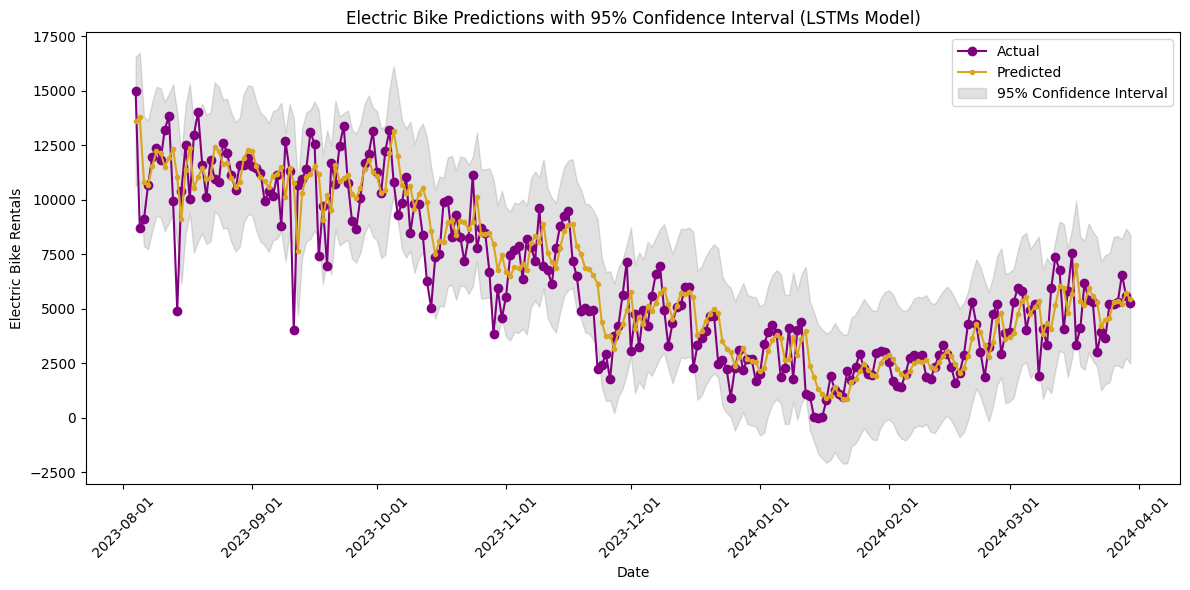

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_dates_elect, y_test_elect, label='Actual', marker='o', color = 'purple')
ax.plot(test_dates_elect, y_pred_elect, label='Predicted', marker = '.', color='orange')
ax.fill_between(test_dates_elect, lower_ci_elect, upper_ci_elect, alpha=0.2, label='95% Confidence Interval', color='dimgray')
ax.set_xlabel('Date')
ax.set_ylabel('Electric Bike Rentals')
ax.set_title('Electric Bike Predictions with 95% Confidence Interval (LSTMs Model)')
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.legend()
plt.tight_layout()
plt.show()

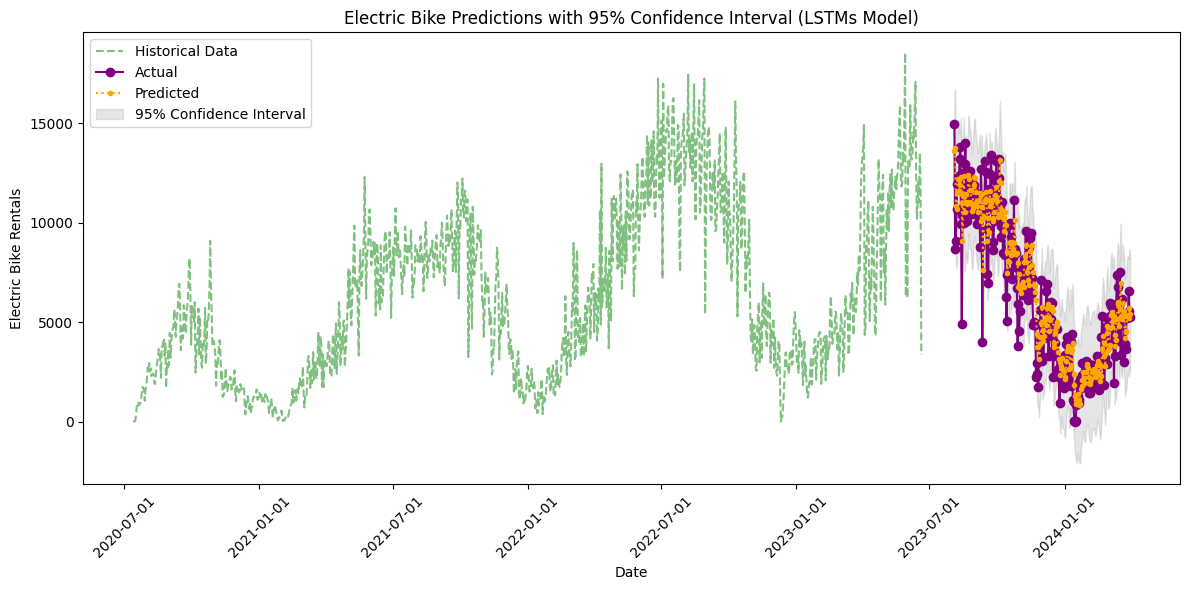

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
shorter_length = len(elect_train_df['elect_bike_rentals'])
train_dates_elect = train_dates_elect[:shorter_length]

ax.plot(train_dates_elect, elect_train_df['elect_bike_rentals'], label='Historical Data', alpha=0.5, color='green', linestyle='--')
ax.plot(test_dates_elect, y_test_elect, label='Actual', marker='o', color = 'purple', linestyle='-')
ax.plot(test_dates_elect, y_pred_elect, label='Predicted', marker='.', color='orange', linestyle=':')
ax.fill_between(test_dates_elect, lower_ci_elect, upper_ci_elect, alpha=0.2, label='95% Confidence Interval', color='gray')
ax.set_xlabel('Date')
ax.set_ylabel('Electric Bike Rentals')
ax.set_title('Electric Bike Predictions with 95% Confidence Interval (LSTMs Model)')
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.legend()
plt.tight_layout()
plt.show()

<a name="SARIMA-&-ARIMA"></a>
### 6.4 SARIMA & ARIMA

<a name="SARIMA-&-ARIMA-Classic-Bike"></a>
#### (a) SARIMA & ARIMA Classic Bike

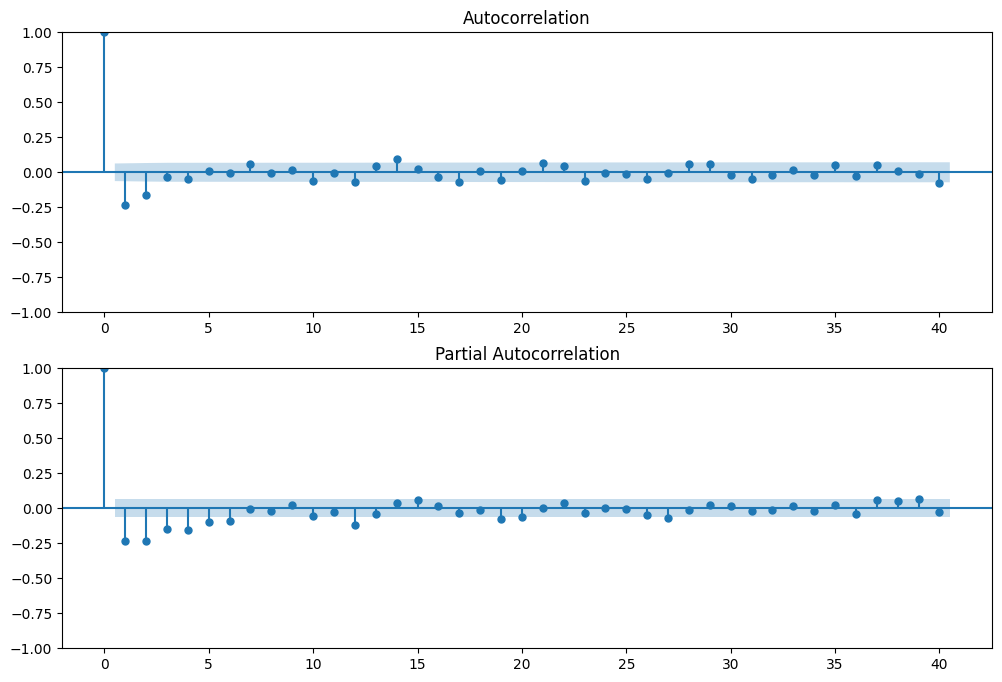

In [ ]:
# identify potential parameters by trying ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the Autocorrelation Function (ACF)
plot_acf(class_train_df['Differenced'].dropna(), lags=40, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(class_train_df['Differenced'].dropna(), lags=40, ax=ax2)

plt.show()

Indicate weekly seasonality

In [ ]:
model = auto_arima(class_train_df[class_train_df.columns[-1]], start_p=1, start_q=1,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=3, max_q=3, # maximum p and q
                   m=1,              # frequency of series
                   d=0,           # we already difference the data
                   seasonal=False,   # No Seasonality
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=823.559, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=998.278, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=946.927, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=891.630, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=822.298, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=893.406, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=824.204, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=821.903, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=822.128, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=821.853, Time=0.93 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=823.840, Time=1.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=821.899, Time=1.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=823.413, Time=3.07 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 8.196 seconds
                               SARI

In [ ]:
model_selected_AIC = ARIMA(class_train_df[class_train_df.columns[-1]], order=(3, 0, 2))
fitted_model_AIC = model_selected_AIC.fit()

# Print out the summary of the model
print(fitted_model_AIC.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                  971
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -404.686
Date:                Mon, 13 May 2024   AIC                            823.371
Time:                        22:25:00   BIC                            857.519
Sample:                    12-03-2020   HQIC                           836.368
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.637      0.524      -0.005       0.010
ar.L1         -0.5520      0.043    -12.918      0.000      -0.636      -0.468
ar.L2          0.3453      0.054      6.342      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_selected_BIC = ARIMA(class_train_df[class_train_df.columns[-1]], order=(1, 0, 1))
fitted_model_bic = model_selected_BIC.fit()

# Print out the summary of the model
print(fitted_model_bic.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                  971
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -408.515
Date:                Mon, 13 May 2024   AIC                            825.031
Time:                        22:25:01   BIC                            844.544
Sample:                    12-03-2020   HQIC                           832.458
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.003      0.672      0.502      -0.004       0.009
ar.L1          0.4388      0.036     12.045      0.000       0.367       0.510
ma.L1         -0.8500      0.023    -37.237      0.0

model ARIMA(1,0,1) is best according to low AIC BIC and also ljung-box pvalue indicate residuals are not white noise. since ARIMA(3,0,2) did not converge, we will not choose.

In [ ]:
# Try to add seasonality
# First try weekly sedasonality
# Fitting a SARIMA model with suspected weekly seasonality
s = 7  # Weekly seasonality
model_sarima_week = SARIMAX(class_train_df['Differenced'],
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, s))

fitted_model_sarima_week = model_sarima_week.fit()

# Summary of the fitted SARIMA model
print(fitted_model_sarima_week.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       Differenced   No. Observations:                  971
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -396.977
Date:                           Mon, 13 May 2024   AIC                            803.955
Time:                                   22:25:02   BIC                            828.346
Sample:                               12-03-2020   HQIC                           813.238
                                    - 07-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4582      0.035     13.122      0.000       0.390       0.527
ma.L1         -0.8663      0.022    -39.660

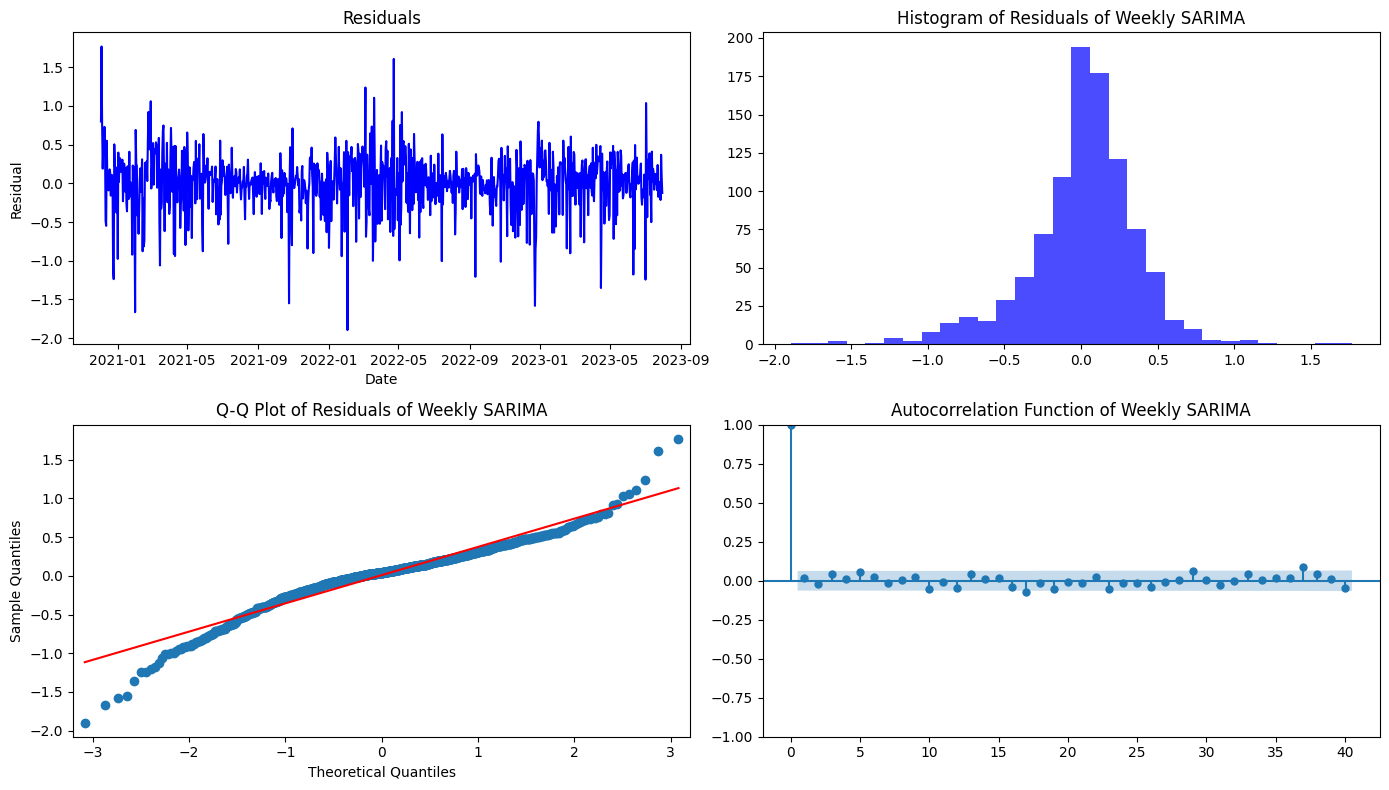

In [ ]:
residuals = fitted_model_sarima_week.resid
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Time series plot of residuals
ax[0, 0].plot(residuals, color='blue')
ax[0, 0].set_title('Residuals')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Residual')

# Histogram of residuals
ax[0, 1].hist(residuals, bins=30, color='blue', alpha=0.7)
ax[0, 1].set_title('Histogram of Residuals of Weekly SARIMA')

# Q-Q plot of residuals to check normality
sm.qqplot(residuals, line='s', ax=ax[1, 0])
ax[1, 0].set_title('Q-Q Plot of Residuals of Weekly SARIMA')

# ACF plot of residuals to check autocorrelations
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[1, 1])
ax[1, 1].set_title('Autocorrelation Function of Weekly SARIMA')

plt.tight_layout()
plt.show()

In [ ]:
forecast = fitted_model_sarima_week.get_forecast(steps=len(class_test_df))
forecast_mean = forecast.predicted_mean

# Retrieve the last log value from the training set
last_log_value = class_train_df['log_classic_bike_rentals'].iloc[-1]

# Cumulative sum of the forecasted differenced values added to the last known log value
cumulative_forecast = last_log_value + forecast_mean.cumsum()

# Exponentiate to reverse the log transformation
original_scale_forecast = np.exp(cumulative_forecast)

# Actual values in original scale for comparison
actual_values = np.exp(class_test_df['log_classic_bike_rentals'])

# Calculate RMSE and MAE on the original scale
rmse_original = np.sqrt(mean_squared_error(actual_values, original_scale_forecast))
mae_original = mean_absolute_error(actual_values, original_scale_forecast)

original_scale_forecast.head(), rmse_original, mae_original

(2023-08-01    12440.132406
 2023-08-02    12147.910183
 2023-08-03    12921.383570
 2023-08-04    12845.423973
 2023-08-05    13715.486584
 Freq: D, Name: predicted_mean, dtype: float64,
 9031.539660169708,
 7949.9743306453565)

In [ ]:
# Create a dataframe for the metrics
sarima_metrics_df_class = pd.DataFrame({
    'RMSE': [rmse_original],
    'MAE': [mae_original]
})

print("\nSARIMA Model of Evaluation (Classic Bike)\n")
sarima_metrics_df_class


SARIMA Model of Evaluation (Classic Bike)



RMSE          MAE
0  9031.53966  7949.974331

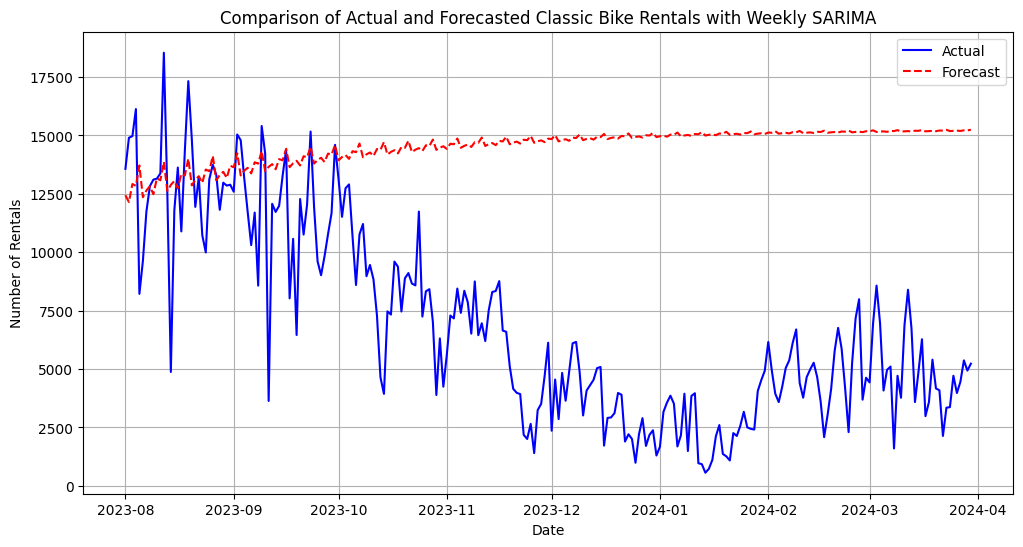

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values.index, actual_values, label='Actual', color='blue')
plt.plot(original_scale_forecast.index, original_scale_forecast, label='Forecast', color='red', linestyle='--')
plt.title('Comparison of Actual and Forecasted Classic Bike Rentals with Weekly SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Try to add seasonality
# Then try monthly sedasonality
s = 30
model_sarima_mo = SARIMAX(class_train_df['Differenced'],
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, s))

fitted_model_sarima_mo = model_sarima_week.fit()

# Summary of the fitted SARIMA model
fitted_model_sarima_mo.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Differenced   No. Observations:                  971
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -396.977
Date:                           Mon, 13 May 2024   AIC                            803.955
Time:                                   22:25:04   BIC                            828.346
Sample:                               12-03-2020   HQIC                           813.238
                                    - 07-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4582      0.035     13.122      0.000       0.390       0.527
ma.L1         -0.8663      0.022    -39.660      0.000      -0.909      -0.824
ar.S.L7        0.9015      0.054     16.647      0.000       0.795       1.008
ma.S.L7       -0.8333      0.068    -12.306      0.000      -0.966      -0.701
sigma2         0.1325      0.004     35.223      0.000       0.125       0.140
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               497.85
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.72
Prob(H) (two-sided):                  0.51   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

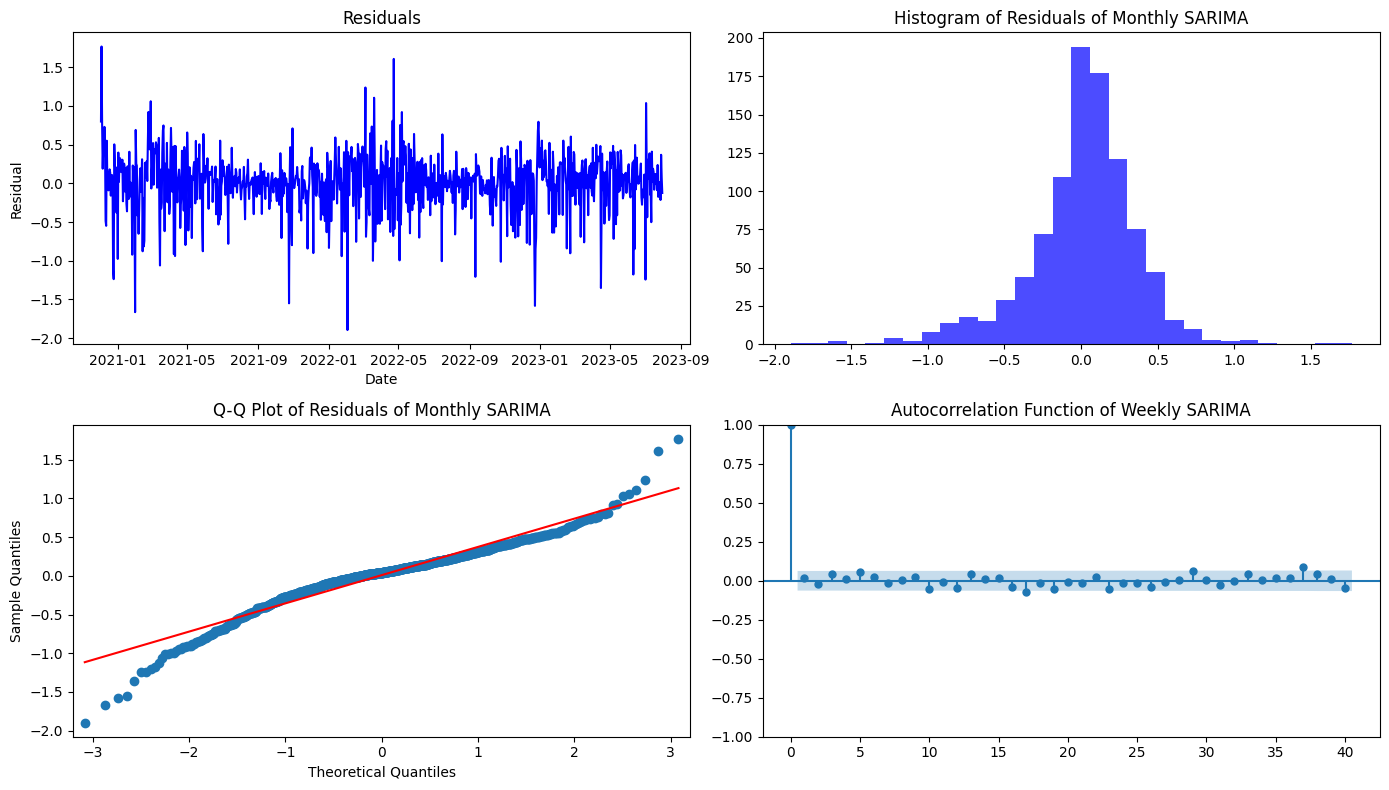

In [ ]:
residuals = fitted_model_sarima_mo.resid

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Time series plot of residuals
ax[0, 0].plot(residuals, color='blue')
ax[0, 0].set_title('Residuals')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Residual')

# Histogram of residuals
ax[0, 1].hist(residuals, bins=30, color='blue', alpha=0.7)
ax[0, 1].set_title('Histogram of Residuals of Monthly SARIMA')

# Q-Q plot of residuals to check normality
sm.qqplot(residuals, line='s', ax=ax[1, 0])
ax[1, 0].set_title('Q-Q Plot of Residuals of Monthly SARIMA')

# ACF plot of residuals to check autocorrelations
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[1, 1])
ax[1, 1].set_title('Autocorrelation Function of Weekly SARIMA')

plt.tight_layout()
plt.show()

In [ ]:
forecast = fitted_model_sarima_mo.get_forecast(steps=len(class_test_df))
forecast_mean = forecast.predicted_mean

# Retrieve the last log value from the training set
last_log_value = class_train_df['log_classic_bike_rentals'].iloc[-1]

# Cumulative sum of the forecasted differenced values added to the last known log value
cumulative_forecast = last_log_value + forecast_mean.cumsum()

# Exponentiate to reverse the log transformation
original_scale_forecast = np.exp(cumulative_forecast)

# Actual values in original scale for comparison

actual_values=class_test_df['classic_bike_rentals']
# Calculate RMSE and MAE on the original scale
rmse_original = np.sqrt(mean_squared_error(actual_values, original_scale_forecast))
mae_original = mean_absolute_error(actual_values, original_scale_forecast)

original_scale_forecast.head(), rmse_original, mae_original

(2023-08-01    12440.132406
 2023-08-02    12147.910183
 2023-08-03    12921.383570
 2023-08-04    12845.423973
 2023-08-05    13715.486584
 Freq: D, Name: predicted_mean, dtype: float64,
 9031.539660169708,
 7949.9743306453565)

In [ ]:
# Create a dataframe for the metrics
sarima_metrics_df_class_monthly = pd.DataFrame({
    'RMSE': [rmse_original],
    'MAE': [mae_original]
})

print("\nSARIMA Model Monthly of Evaluation (Classic Bike)\n")
sarima_metrics_df_class_monthly


SARIMA Model Monthly of Evaluation (Classic Bike)



RMSE          MAE
0  9031.53966  7949.974331

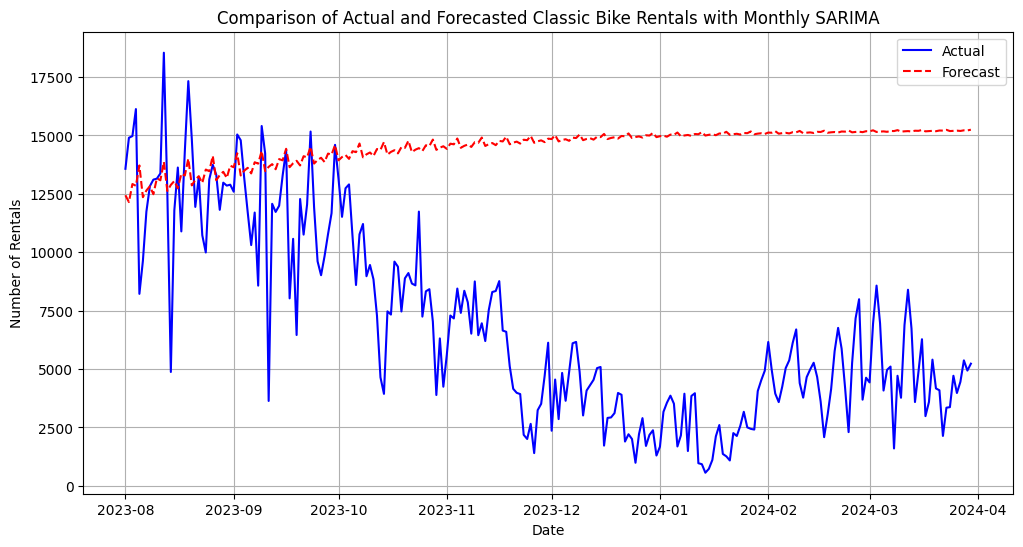

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values.index, actual_values, label='Actual', color='blue')
plt.plot(original_scale_forecast.index, original_scale_forecast, label='Forecast', color='red', linestyle='--')
plt.title('Comparison of Actual and Forecasted Classic Bike Rentals with Monthly SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()

**SARIMA with Monthly Seasonality has lower RMSE and MAE, and also relative low AIC and BIC value -> selected**

In [ ]:
original_scale_forecast

2023-08-01    12440.132406
2023-08-02    12147.910183
2023-08-03    12921.383570
2023-08-04    12845.423973
2023-08-05    13715.486584
                  ...     
2024-03-26    15206.839224
2024-03-27    15193.463426
2024-03-28    15219.850350
2024-03-29    15216.632967
2024-03-30    15245.764490
Freq: D, Name: predicted_mean, Length: 243, dtype: float64

In [ ]:
residuals = class_test_df['classic_bike_rentals'] - original_scale_forecast
residual_std = np.std(residuals)
# Calculate the 95% confidence intervals
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
lower_ci = original_scale_forecast - z_score * residual_std
upper_ci = original_scale_forecast + z_score * residual_std

# Create a DataFrame with the predicted values and confidence intervals
predicted_df_class_SARIMA = pd.DataFrame({'classic_bike_rentals_predict_value': original_scale_forecast,
                             'Lower_CI': lower_ci,
                             'Upper_CI': upper_ci},
                            index=class_test_df.index)

In [ ]:
predicted_df_class_SARIMA

classic_bike_rentals_predict_value     Lower_CI      Upper_CI
started_at                                                               
2023-08-01                        12440.132406  3276.022227  21604.242585
2023-08-02                        12147.910183  2983.800004  21312.020362
2023-08-03                        12921.383570  3757.273391  22085.493749
2023-08-04                        12845.423973  3681.313794  22009.534152
2023-08-05                        13715.486584  4551.376405  22879.596763
...                                        ...          ...           ...
2024-03-26                        15206.839224  6042.729045  24370.949403
2024-03-27                        15193.463426  6029.353247  24357.573605
2024-03-28                        15219.850350  6055.740171  24383.960530
2024-03-29                        15216.632967  6052.522788  24380.743146
2024-03-30                        15245.764490  6081.654310  24409.874669

[243 rows x 3 columns]

In [ ]:
predicted_df_class_SARIMA.to_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/SARIMA_Classic_Prediction.csv', index = True)

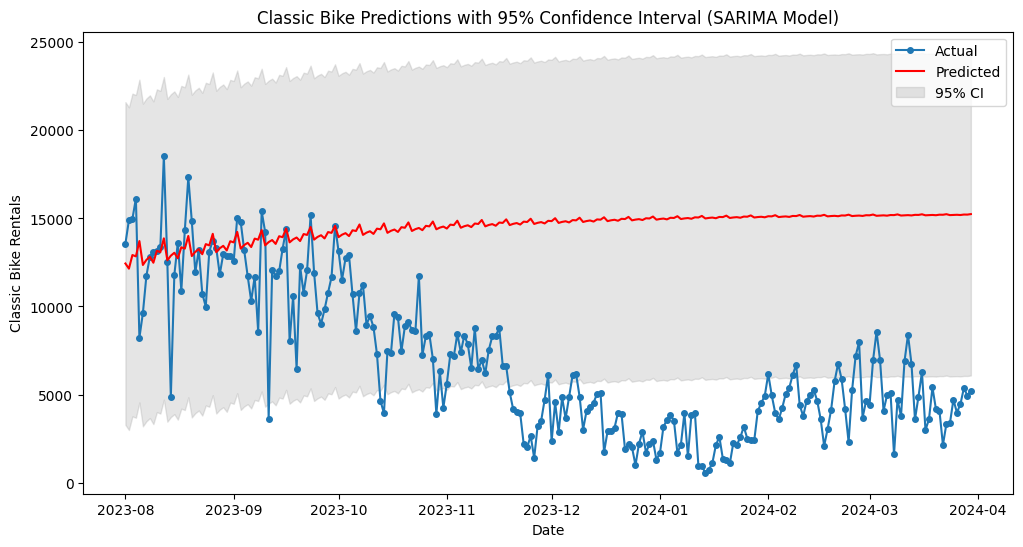

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(class_test_df.index, class_test_df['classic_bike_rentals'], label='Actual', marker='o', markersize=4)
plt.plot(predicted_df_class_SARIMA.index, predicted_df_class_SARIMA['classic_bike_rentals_predict_value'], label='Predicted', color = "red")
plt.fill_between(predicted_df_class_SARIMA.index, predicted_df_class_SARIMA['Lower_CI'],
                 predicted_df_class_SARIMA['Upper_CI'], alpha=0.2, label='95% CI', color = "gray")
plt.xlabel('Date')
plt.ylabel('Classic Bike Rentals')
plt.title('Classic Bike Predictions with 95% Confidence Interval (SARIMA Model)')
plt.legend()
plt.show()

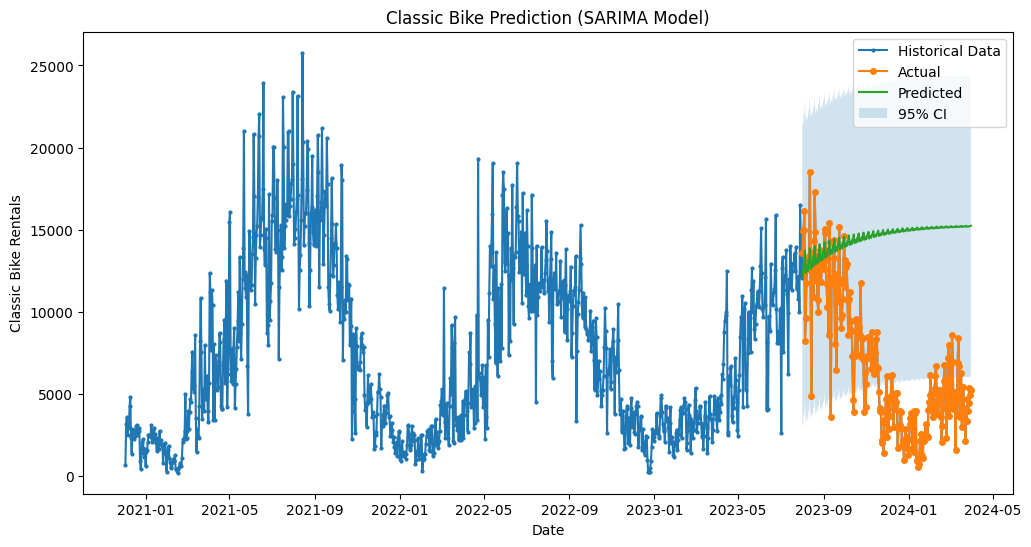

In [ ]:
# Plot the predictions, confidence intervals, actual values, and historical data
plt.figure(figsize=(12, 6))
plt.plot(class_df.index, class_df['classic_bike_rentals'], label='Historical Data', marker='.', markersize=4)
plt.plot(class_test_df.index, class_test_df['classic_bike_rentals'], label='Actual', marker='o', markersize=4)
plt.plot(predicted_df_class_SARIMA.index, predicted_df_class_SARIMA['classic_bike_rentals_predict_value'], label='Predicted')
plt.fill_between(predicted_df_class_SARIMA.index, predicted_df_class_SARIMA['Lower_CI'],
                 predicted_df_class_SARIMA['Upper_CI'], alpha=0.2, label='95% CI')
plt.xlabel('Date')
plt.ylabel('Classic Bike Rentals')
plt.title('Classic Bike Prediction (SARIMA Model)')
plt.legend()
plt.show()

<a name="SARIMA-&-ARIMA-Electric-Bike"></a>
#### (b) SARIMA & ARIMA Electric Bike

In [ ]:
elect_train_df=elect_train_df.dropna()

In [ ]:
elect_train_df

elect_bike_rentals        day  log_elect_bike_rentals  \
started_at                                                          
2020-07-14                  14    Tuesday                2.639057   
2020-07-15                  13  Wednesday                2.564949   
2020-07-28                  31    Tuesday                3.433987   
2020-07-29                 287  Wednesday                5.659482   
2020-07-30                 745   Thursday                6.613384   
...                        ...        ...                     ...   
2023-06-28               12073  Wednesday                9.398727   
2023-06-29               11045   Thursday                9.309733   
2023-06-30               13507     Friday                9.510963   
2023-07-01               11817   Saturday                9.377294   
2023-07-02                3351     Sunday                8.117014   

            Differenced  diff_elect_bike_rentals  
started_at                                        
2020-07-14     0.559616                      6.0  
2020-07-15    -0.074108                     -1.0  
2020-07-28     0.869038                     18.0  
2020-07-29     2.225495                    256.0  
2020-07-30     0.953902                    458.0  
...                 ...                      ...  
2023-06-28     0.100650                   1156.0  
2023-06-29    -0.088994                  -1028.0  
2023-06-30     0.201230                   2462.0  
2023-07-01    -0.133669                  -1690.0  
2023-07-02    -1.260280                  -8466.0  

[1072 rows x 5 columns]

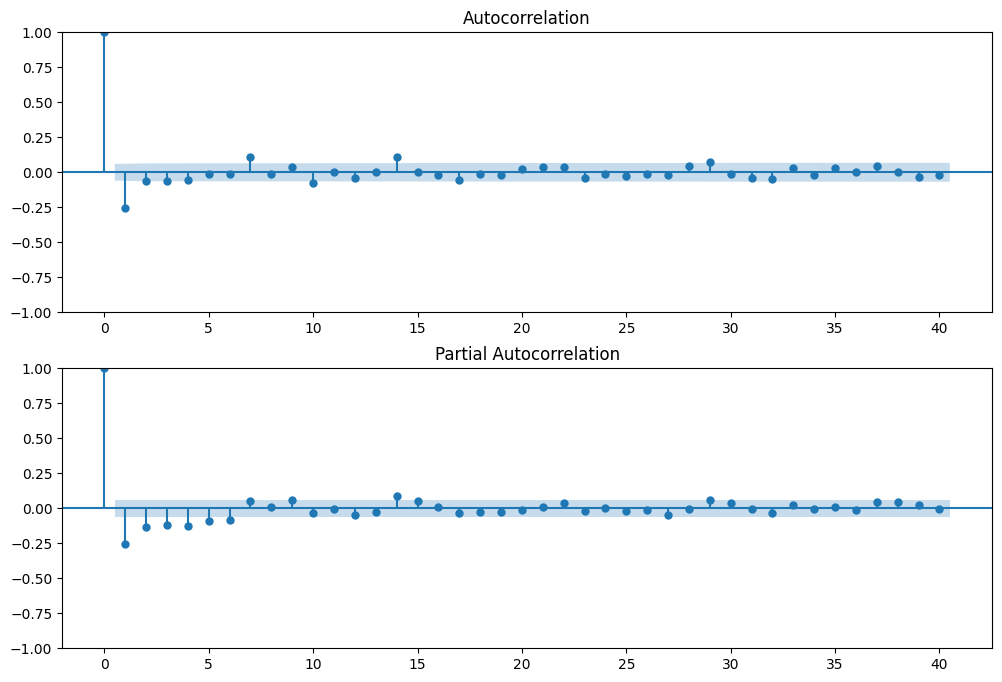

In [ ]:
# identify potential parameters by trying ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the Autocorrelation Function (ACF)
plot_acf(elect_train_df['Differenced'].dropna(), lags=40, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(elect_train_df['Differenced'].dropna(), lags=40, ax=ax2)

plt.show()

In [ ]:
model = auto_arima(elect_train_df[elect_train_df.columns[-1]], start_p=1, start_q=1,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=3, max_q=3, # maximum p and q
                   m=1,              # frequency of series
                   d=0,           # we already difference the data
                   seasonal=False,   # No Seasonality
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18829.086, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19086.253, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19008.601, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18903.274, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18829.285, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18827.335, Time=0.45 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=18828.968, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=18830.138, Time=0.98 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=18826.976, Time=0.84 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=18826.094, Time=0.27 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=18827.325, Time=1.39 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0]          
Total fit time: 4.984 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

In [ ]:
# add seasonality
s = 7  # Weekly seasonality
model_sarima_week = SARIMAX(elect_train_df['Differenced'],
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, s))

fitted_model_sarima_week = model_sarima_week.fit()

# Summary of the fitted SARIMA model
fitted_model_sarima_week.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Differenced   No. Observations:                 1072
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -548.100
Date:                           Mon, 13 May 2024   AIC                           1106.200
Time:                                   22:25:15   BIC                           1131.087
Sample:                                        0   HQIC                          1115.627
                                          - 1072                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4072      0.036     11.393      0.000       0.337       0.477
ma.L1         -0.7536      0.033    -22.665      0.000      -0.819      -0.688
ar.S.L7        0.8881      0.062     14.425      0.000       0.767       1.009
ma.S.L7       -0.8045      0.068    -11.781      0.000      -0.938      -0.671
sigma2         0.1626      0.001    163.482      0.000       0.161       0.165
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            652162.49
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -6.02
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Residual Check

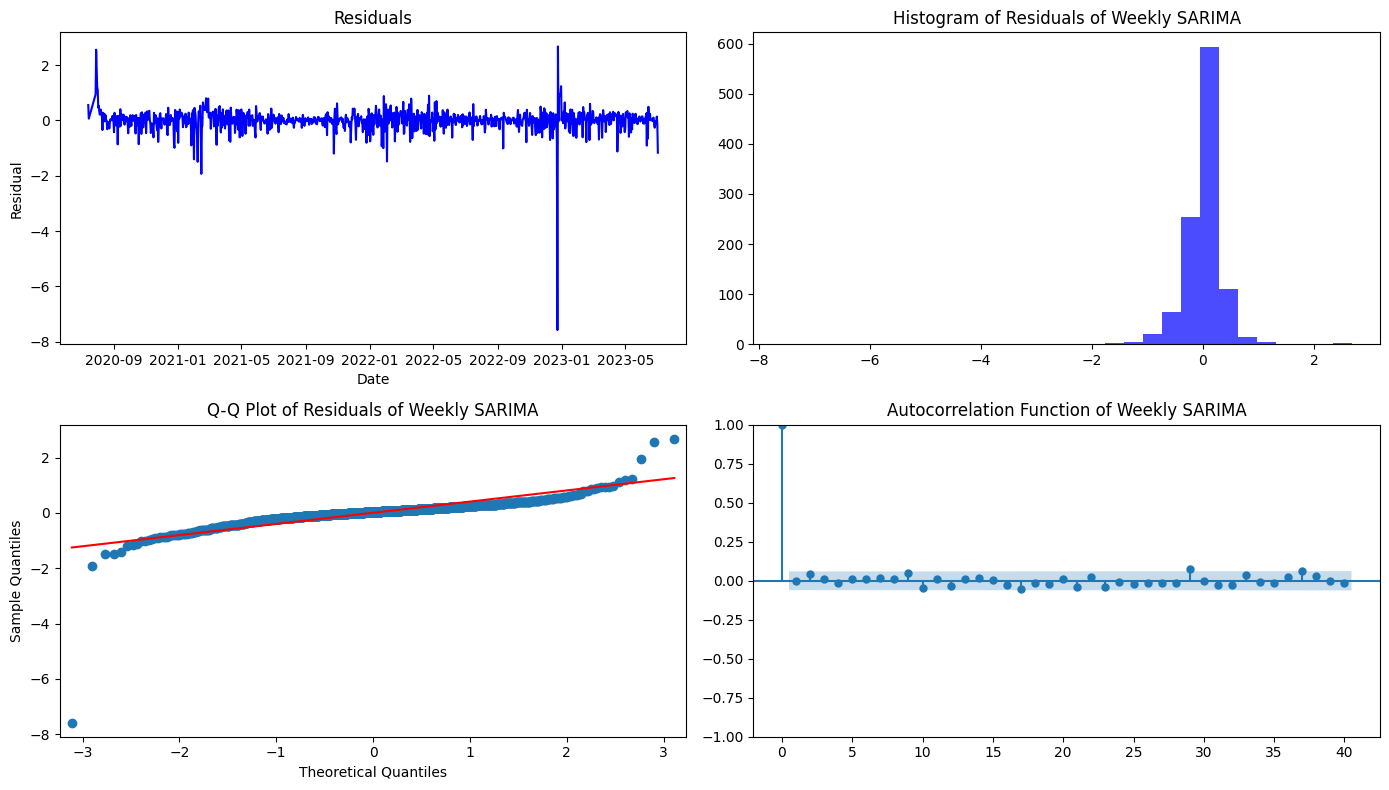

In [ ]:
residuals = fitted_model_sarima_week.resid

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Time series plot of residuals
ax[0, 0].plot(residuals, color='blue')
ax[0, 0].set_title('Residuals')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Residual')

# Histogram of residuals
ax[0, 1].hist(residuals, bins=30, color='blue', alpha=0.7)
ax[0, 1].set_title('Histogram of Residuals of Weekly SARIMA')

# Q-Q plot of residuals to check normality
sm.qqplot(residuals, line='s', ax=ax[1, 0])
ax[1, 0].set_title('Q-Q Plot of Residuals of Weekly SARIMA')

# ACF plot of residuals to check autocorrelations
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[1, 1])
ax[1, 1].set_title('Autocorrelation Function of Weekly SARIMA')

plt.tight_layout()
plt.show()

- Standardized Residual Plot: The residuals fluctuate around zero without any obvious patterns or trends, which is a good sign that the model does not have systematic errors.
- Histogram plus Estimated Density: The density plot of the residuals shows a distribution that is somewhat skewed, indicating potential deviations from normality, but this is common in practical scenarios.
- Normal Q-Q Plot: The points in the Q-Q plot follow the line closely in the middle but deviate in the tails. This indicates heavier tails than the normal distribution, which is typical for many real-world datasets.
- Correlogram (ACF Plot): The autocorrelation plot shows that there are no significant spikes outside the confidence band for the residuals.

In [ ]:
# Create a date range for the forecast period
forecast_start_date = elect_test_df.index.min()
forecast_end_date = elect_test_df.index.max()
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date)

# Forecast
forecast = fitted_model_sarima_week.get_forecast(steps=len(forecast_dates))
forecast_mean = forecast.predicted_mean

# Since forecast_mean is a series, set its index to the forecast_dates
forecast_mean.index = forecast_dates

# Retrieve the last log value from the training set
last_log_value = elect_train_df['log_elect_bike_rentals'].iloc[-1]

# Cumulative sum of the forecasted differenced values added to the last known log value
cumulative_forecast = last_log_value + forecast_mean.cumsum()

# Exponentiate to reverse the log transformation
original_scale_forecast = np.exp(cumulative_forecast)

# Ensure elect_test_df['log_elect_bike_rentals'] exists and is correctly populated
actual_values = np.exp(elect_test_df['log_elect_bike_rentals'])

# Calculate RMSE and MAE on the original scale
rmse_original = np.sqrt(mean_squared_error(actual_values, original_scale_forecast))
mae_original = mean_absolute_error(actual_values, original_scale_forecast)

# Display the first few forecasted values, RMSE, and MAE
original_scale_forecast.head(), rmse_original, mae_original

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(2023-07-03    5166.718810
 2023-07-04    6246.044169
 2023-07-05    7117.164546
 2023-07-06    7351.101903
 2023-07-07    7563.064900
 Freq: D, Name: predicted_mean, dtype: float64,
 3970.6662236146376,
 3350.1903935452237)

In [ ]:
residuals = elect_test_df['elect_bike_rentals'] - original_scale_forecast
residual_std = np.std(residuals)
# Calculate the 95% confidence intervals
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
lower_ci = original_scale_forecast - z_score * residual_std
upper_ci = original_scale_forecast + z_score * residual_std

# Create a DataFrame with the predicted values and confidence intervals
predicted_df_elect_SARIMA = pd.DataFrame({'electric_bike_rentals_predict_value': original_scale_forecast,
                             'Lower_CI': lower_ci,
                             'Upper_CI': upper_ci},
                            index=elect_test_df.index)

predicted_df_elect_SARIMA.head()

electric_bike_rentals_predict_value     Lower_CI      Upper_CI
started_at                                                                
2023-07-03                          5166.718810 -2194.837327  12528.274946
2023-07-04                          6246.044169 -1115.511968  13607.600305
2023-07-05                          7117.164546  -244.391590  14478.720683
2023-07-06                          7351.101903   -10.454233  14712.658040
2023-07-07                          7563.064900   201.508764  14924.621037

In [ ]:
predicted_df_elect_SARIMA.to_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/SARIMA_Electric_Prediction.csv', index = True)

In [ ]:
# Create a dataframe for the metrics
sarima_metrics_df_elect = pd.DataFrame({
    'RMSE': [rmse_original],
    'MAE': [mae_original]
})

print("\nSARIMA Model of Evaluation (Electric Bike)\n")
sarima_metrics_df_elect


SARIMA Model of Evaluation (Electric Bike)



RMSE          MAE
0  3970.666224  3350.190394

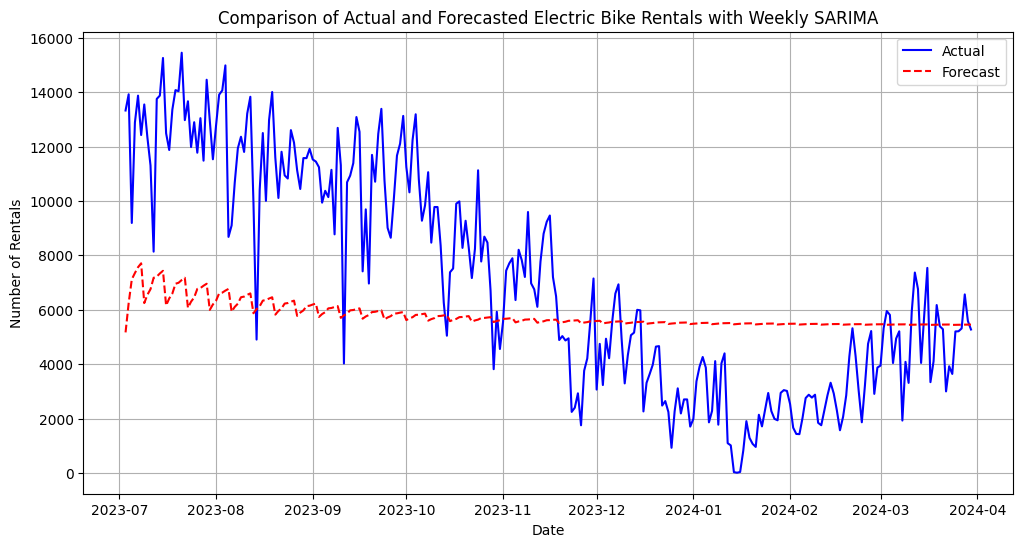

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values.index, actual_values, label='Actual', color='blue')
plt.plot(original_scale_forecast.index, original_scale_forecast, label='Forecast', color='red', linestyle='--')
plt.title('Comparison of Actual and Forecasted Electric Bike Rentals with Weekly SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predicted_df_elect_SARIMA

electric_bike_rentals_predict_value     Lower_CI      Upper_CI
started_at                                                                
2023-07-03                          5166.718810 -2194.837327  12528.274946
2023-07-04                          6246.044169 -1115.511968  13607.600305
2023-07-05                          7117.164546  -244.391590  14478.720683
2023-07-06                          7351.101903   -10.454233  14712.658040
2023-07-07                          7563.064900   201.508764  14924.621037
...                                         ...          ...           ...
2024-03-26                          5447.672377 -1913.883760  12809.228513
2024-03-27                          5451.720614 -1909.835522  12813.276751
2024-03-28                          5452.120277 -1909.435859  12813.676414
2024-03-29                          5453.198495 -1908.357642  12814.754631
2024-03-30                          5454.083268 -1907.472869  12815.639404

[272 rows x 3 columns]

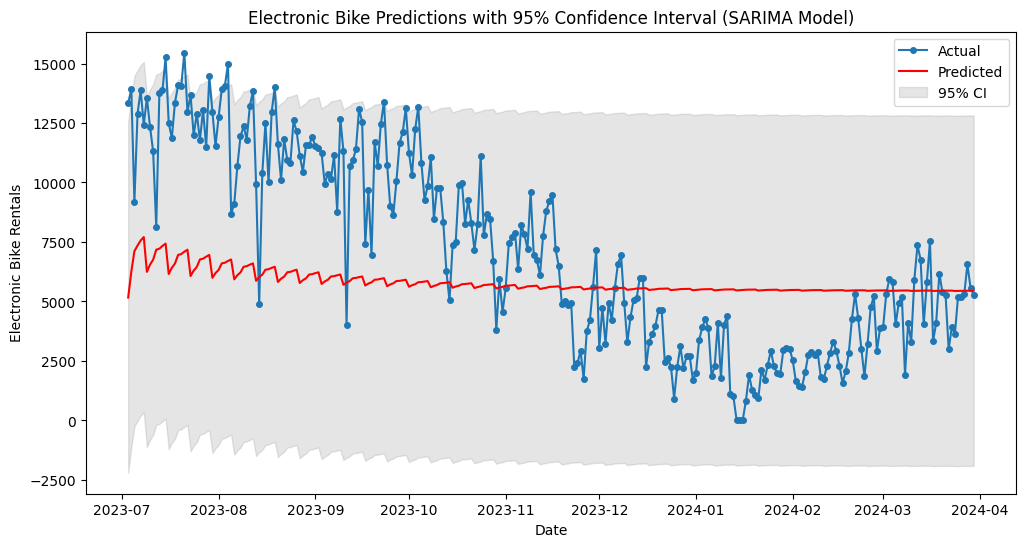

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(elect_test_df.index, elect_test_df['elect_bike_rentals'], label='Actual', marker='o', markersize=4)
plt.plot(predicted_df_elect_SARIMA.index, predicted_df_elect_SARIMA['electric_bike_rentals_predict_value'], label='Predicted', color = "red")
plt.fill_between(predicted_df_elect_SARIMA.index, predicted_df_elect_SARIMA['Lower_CI'],
                 predicted_df_elect_SARIMA['Upper_CI'], alpha=0.2, label='95% CI', color = "gray")
plt.xlabel('Date')
plt.ylabel('Electronic Bike Rentals')
plt.title('Electronic Bike Predictions with 95% Confidence Interval (SARIMA Model)')
plt.legend()
plt.show()

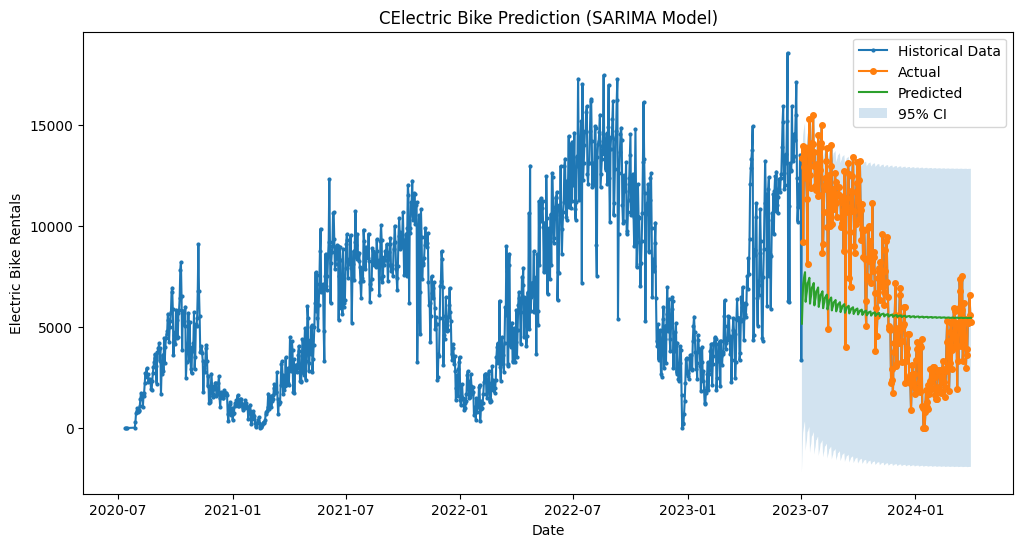

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(elect_df.index, elect_df['elect_bike_rentals'], label='Historical Data', marker='.', markersize=4)
plt.plot(elect_test_df.index, elect_test_df['elect_bike_rentals'], label='Actual', marker='o', markersize=4)
plt.plot(predicted_df_elect_SARIMA.index, predicted_df_elect_SARIMA['electric_bike_rentals_predict_value'], label='Predicted')
plt.fill_between(predicted_df_elect_SARIMA.index, predicted_df_elect_SARIMA['Lower_CI'],
                 predicted_df_elect_SARIMA['Upper_CI'], alpha=0.2, label='95% CI')
plt.xlabel('Date')
plt.ylabel('Electric Bike Rentals')
plt.title('CElectric Bike Prediction (SARIMA Model)')
plt.legend()
plt.show()

<a name="Uber-Orbit-Damped-Local-Trend"></a>
### 6.5 Uber Orbit Damped Local Trend

* Orbit is a Python package that provides Bayesian forecasting techniques, which are powerful for capturing uncertainty in predictions

* The DLT model is designed to handle non-stationary data directly. This includes data with trends and seasonal patterns, which are common in many real-world scenarios like bike-sharing demand. Therefore, differencing, which is often used to make a series stationary, is not a necessity for DLT.


<a name="Orbit-Damped-Local-Trend-Classic-Bike"></a>
#### (a) Orbit Damped Local Trend Classic Bike

In [ ]:
class_df = class_df.reset_index()
class_df

started_at  classic_bike_rentals        day  log_classic_bike_rentals  \
0    2020-12-03                   669   Thursday                  6.505784   
1    2020-12-04                  3190     Friday                  8.067776   
2    2020-12-05                  3586   Saturday                  8.184793   
3    2020-12-06                  2485     Sunday                  7.818028   
4    2020-12-07                  2915     Monday                  7.977625   
...         ...                   ...        ...                       ...   
1209 2024-03-26                  3973    Tuesday                  8.287277   
1210 2024-03-27                  4451  Wednesday                  8.400884   
1211 2024-03-28                  5370   Thursday                  8.588583   
1212 2024-03-29                  4933     Friday                  8.503703   
1213 2024-03-30                  5228   Saturday                  8.561784   

      Differenced  
0        0.798674  
1        1.561992  
2        0.117016  
3       -0.366765  
4        0.159597  
...           ...  
1209    -0.170166  
1210     0.113607  
1211     0.187699  
1212    -0.084881  
1213     0.058081  

[1214 rows x 5 columns]

In [ ]:
split_point = pd.Timestamp('2023-08-01')
#elect_df['started_at'] = elect_df.index

train_df = class_df[class_df['started_at'] < split_point]
validation_df = class_df[class_df['started_at'] >= split_point]


print(f"Shape of elect_train_df: {train_df.shape}")
print(f"Shape of celect_test_df: {validation_df.shape}")

Shape of elect_train_df: (971, 5)
Shape of celect_test_df: (243, 5)


In [ ]:
data=class_df[['started_at','classic_bike_rentals']]

# Generate Fourier series components
data, fs_cols = make_fourier_series_df(data, 365.25, order=5)

# Split the data
test_size = 243
train_df = data[:-test_size]
validation_df = data[-test_size:]

In [ ]:
# Initialize MinMaxScaler
scaler_target = MinMaxScaler()


# Scale the target variable for both training and validation sets
train_df['scaled_classic_bike_rentals'] = scaler_target.fit_transform(train_df[['classic_bike_rentals']])
validation_df['scaled_classic_bike_rentals'] = scaler_target.transform(validation_df[['classic_bike_rentals']])


<ipython-input-167-94ac18fb13ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['scaled_classic_bike_rentals'] = scaler_target.fit_transform(train_df[['classic_bike_rentals']])
<ipython-input-167-94ac18fb13ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['scaled_classic_bike_rentals'] = scaler_target.transform(validation_df[['classic_bike_rentals']])


In [ ]:
%%time

# Define the objective function
def scaled_objective(global_cap, global_floor, damped_factor):
    model = DLT(
        response_col='scaled_classic_bike_rentals',
        date_col='started_at',
        estimator='stan-map',
        regressor_col=fs_cols,
        seasonality=365,
        seed=8888,
        global_trend_option='logistic',
        global_cap=global_cap,
        global_floor=global_floor,
        damped_factor=damped_factor,
        n_bootstrap_draws=1000,
        verbose=False
    )
    model.fit(df=train_df)
    predictions = model.predict(df=validation_df)
    predictions_in_original_scale = scaler_target.inverse_transform(predictions[['prediction']])


    rmse = mean_squared_error(validation_df['classic_bike_rentals'], predictions_in_original_scale, squared=False)
    return -rmse

# Parameter bounds
param_bounds = {
    'global_cap': (5000, 20000),
    'global_floor': (0, 50),
    'damped_factor': (0.01, 0.8)
}

# Setup Bayesian Optimization
optimizer = BayesianOptimization(f=scaled_objective, pbounds=param_bounds, random_state=1, verbose=2)

# Run the optimizer
optimizer.maximize(init_points=5, n_iter=15)

# Print the best parameters found
print(optimizer.max)

|   iter    |  target   | damped... | global... | global... |
-------------------------------------------------------------
| 1         | -2.226e+0 | 0.3394    | 1.58e+04  | 0.005719  |
| 2         | -2.845e+0 | 0.2488    | 7.201e+03 | 4.617     |
| 3         | -2.18e+04 | 0.1571    | 1.018e+04 | 19.84     |
| 4         | -2.074e+0 | 0.4357    | 1.129e+04 | 34.26     |
| 5         | -2.014e+0 | 0.1715    | 1.817e+04 | 1.369     |
| 6         | -1.877e+0 | 0.1532    | 1.795e+04 | 12.35     |
| 7         | -1.731e+0 | 0.7301    | 1.795e+04 | 14.91     |
| 8         | -2.548e+0 | 0.3965    | 1.795e+04 | 21.56     |
| 9         | -4.907e+0 | 0.1642    | 1.817e+04 | 5.567     |
| 10        | -2.825e+0 | 0.661     | 1.128e+04 | 29.78     |
| 11        | -1.926e+0 | 0.2036    | 1.794e+04 | 16.76     |
| 12        | -2.789e+0 | 0.1362    | 1.818e+04 | 0.3019    |
| 13        | -2.089e+0 | 0.1685    | 1.019e+04 | 13.7      |
| 14        | -1.524e+0 | 0.02061   | 1.019e+04 | 21.37     |
| 15    

In [ ]:
optimizer.max['params']

{'damped_factor': 0.13620265239288523,
 'global_cap': 18178.158551829154,
 'global_floor': 0.3018856249946189}

In [ ]:
%%time

# Initialize and fit the model using the best parameters
model = DLT(
    response_col='scaled_classic_bike_rentals',
    date_col='started_at',
    regressor_col=fs_cols,
    estimator='stan-map',
    seasonality=365,
    seed=8888,
    global_trend_option='logistic',
    global_cap=optimizer.max['params']['global_cap'],
    global_floor=optimizer.max['params']['global_floor'],
    damped_factor=optimizer.max['params']['damped_factor'],
    n_bootstrap_draws=1000,
    verbose=False
)

model.fit(df=train_df)

# Make predictions on the validation set
# outcomes data frame
predictions = model.predict(df=validation_df)

# Inverse transform the predictions to get them back to the original scale
predictions['predictions_in_original_scale'] = scaler_target.inverse_transform(predictions[['prediction']])


# Display the predictions in the original scale
predictions


started_at  prediction_5  prediction  prediction_95  \
0   2023-08-01      0.175782    0.475162       0.787967   
1   2023-08-02      0.150073    0.449196       0.756565   
2   2023-08-03      0.059904    0.379138       0.697189   
3   2023-08-04      0.161112    0.454362       0.787037   
4   2023-08-05      0.171512    0.500230       0.777777   
..         ...           ...         ...            ...   
238 2024-03-26     -0.289310    0.102959       0.509105   
239 2024-03-27     -0.299329    0.126157       0.529326   
240 2024-03-28     -0.315916    0.105382       0.505502   
241 2024-03-29     -0.284755    0.111501       0.529302   
242 2024-03-30     -0.348671    0.078053       0.470930   

     predictions_in_original_scale  
0                     12359.100699  
1                     11695.348159  
2                      9904.524350  
3                     11827.405121  
4                     12999.873125  
..                             ...  
238                    2844.847180  
239                    3437.817481  
240                    2906.787308  
241                    3063.189961  
242                    2208.191865  

[243 rows x 5 columns]

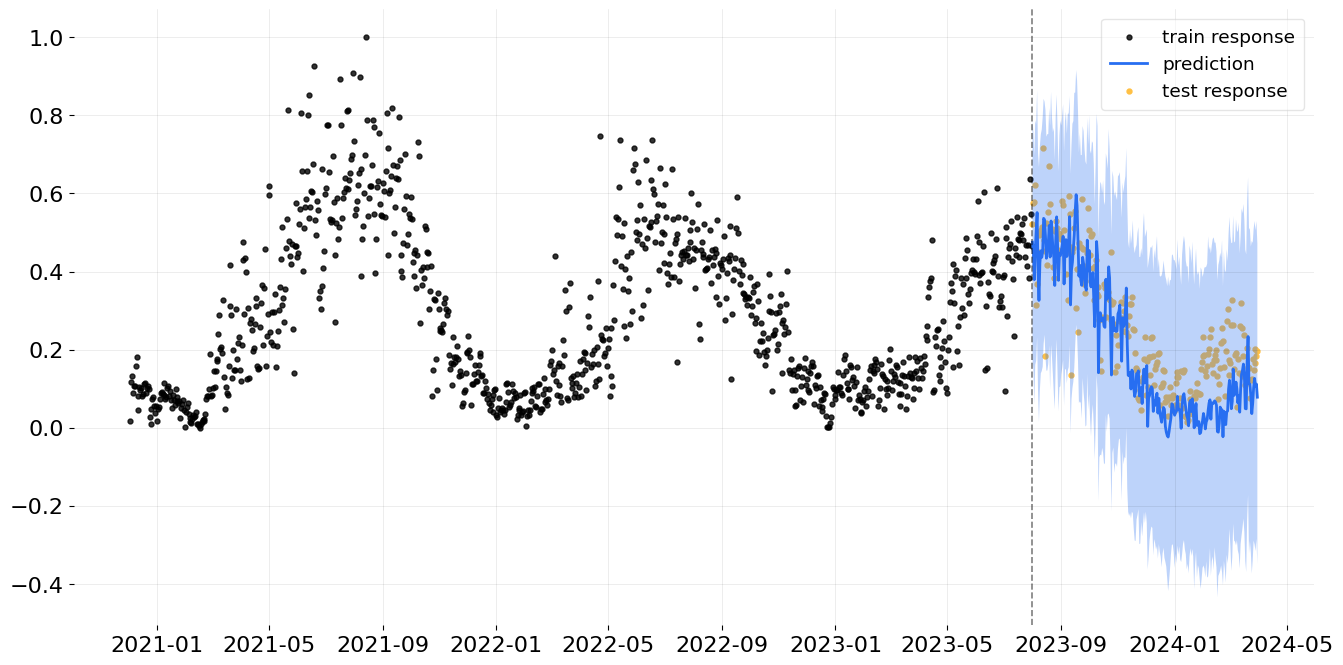

<Axes: >

In [ ]:
plot_predicted_data(
  training_actual_df=train_df, predicted_df=predictions,
  date_col=model.date_col, actual_col=model.response_col,
  test_actual_df=validation_df
)


2024-05-11 04:18:37 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.


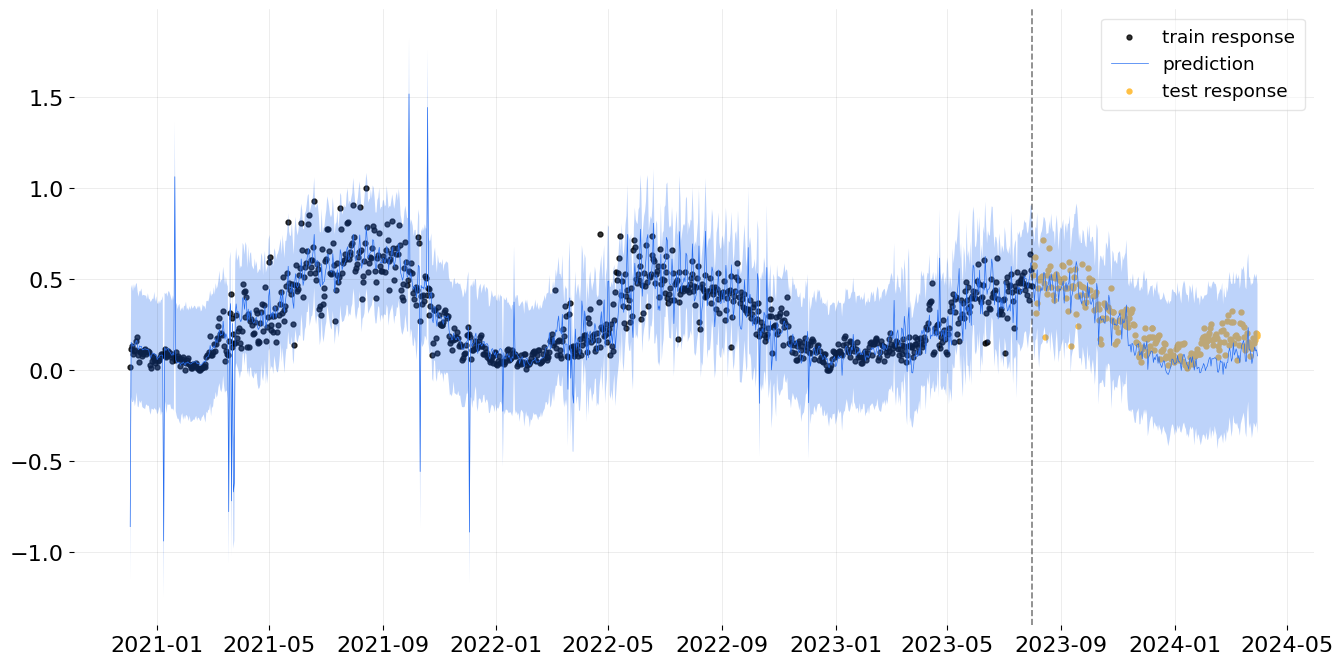

In [ ]:
%%time

# Initialize and fit the model using the best parameters
model = DLT(
    response_col='scaled_classic_bike_rentals',
    date_col='started_at',
    regressor_col=fs_cols,
    estimator='stan-map',
    seasonality=365,
    seed=8888,
    global_trend_option='logistic',
    global_cap=optimizer.max['params']['global_cap'],
    global_floor=optimizer.max['params']['global_floor'],
    damped_factor=optimizer.max['params']['damped_factor'],
    n_bootstrap_draws=1000,
)

model.fit(df=train_df)

pred_df = model.predict(data)

plot_predicted_data(training_actual_df=train_df, predicted_df=pred_df,
  date_col=model.date_col, actual_col=model.response_col, test_actual_df=validation_df, lw=0.5);

In [ ]:
# If you prefer a left join to keep all rows from elect_test_df and add predictions where available
predicted_df_class_orbit = validation_df.merge(predictions[['prediction','started_at', 'predictions_in_original_scale']],
                                on='started_at', how='left')
predicted_df_class_orbit

started_at  classic_bike_rentals   fs_cos1   fs_sin1   fs_cos2   fs_sin2  \
0   2023-08-01                 13573 -0.529494 -0.848314 -0.439273  0.898354   
1   2023-08-02                 14901 -0.514823 -0.857296 -0.469915  0.882712   
2   2023-08-03                 14974 -0.500000 -0.866025 -0.500000  0.866025   
3   2023-08-04                 16130 -0.485029 -0.874498 -0.529494  0.848314   
4   2023-08-05                  8218 -0.469915 -0.882712 -0.558361  0.829598   
..         ...                   ...       ...       ...       ...       ...   
238 2024-03-26                  3973 -0.384421  0.923158 -0.704441 -0.709763   
239 2024-03-27                  4451 -0.400244  0.916409 -0.679610 -0.733574   
240 2024-03-28                  5370 -0.415948  0.909388 -0.653974 -0.756517   
241 2024-03-29                  4933 -0.431530  0.902099 -0.627564 -0.778565   
242 2024-03-30                  5228 -0.446983  0.894542 -0.600412 -0.799691   

      fs_cos3       fs_sin3   fs_cos4   fs_sin4   fs_cos5   fs_sin5  \
0    0.994678 -1.030314e-01 -0.614079 -0.789245 -0.344376  0.938832   
1    0.998669 -5.158437e-02 -0.558361 -0.829598 -0.423755  0.905777   
2    1.000000 -1.959435e-15 -0.500000 -0.866025 -0.500000  0.866025   
3    0.998669  5.158437e-02 -0.439273 -0.898354 -0.572548  0.819871   
4    0.994678  1.030314e-01 -0.376467 -0.926430 -0.640864  0.767655   
..        ...           ...       ...       ...       ...       ...   
238  0.926025 -3.774625e-01 -0.007526  0.999972 -0.920239 -0.391358   
239  0.944263 -3.291915e-01 -0.076262  0.997088 -0.883217 -0.468965   
240  0.959987 -2.800440e-01 -0.144636  0.989485 -0.839665 -0.543105   
241  0.973155 -2.301509e-01 -0.212327  0.977199 -0.789905 -0.613230   
242  0.983732 -1.796449e-01 -0.279012  0.960288 -0.734304 -0.678820   

     scaled_classic_bike_rentals  prediction  predictions_in_original_scale  
0                       0.522651    0.475162                   12359.100699  
1                       0.574603    0.449196                   11695.348159  
2                       0.577459    0.379138                    9904.524350  
3                       0.622682    0.454362                   11827.405121  
4                       0.313160    0.500230                   12999.873125  
..                           ...         ...                            ...  
238                     0.147093    0.102959                    2844.847180  
239                     0.165793    0.126157                    3437.817481  
240                     0.201745    0.105382                    2906.787308  
241                     0.184649    0.111501                    3063.189961  
242                     0.196190    0.078053                    2208.191865  

[243 rows x 15 columns]

In [ ]:
actual = predicted_df_class_orbit['classic_bike_rentals']
predicted = predicted_df_class_orbit['predictions_in_original_scale']

# Calculating RMSE
rmse = sqrt(mean_squared_error(actual, predicted))

# Calculating MAE
mae = mean_absolute_error(actual, predicted)

# Calculating MPE
mpe = np.mean((actual - predicted) / actual) * 100

# Calculating MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("RMSE:", rmse)
print("MAE:", mae)
print("MPE:", mpe)
print("MAPE:", mape)

RMSE: 2789.0292110316964
MAE: 2247.962273477329
MPE: 25.454942608801858
MAPE: 42.80424705456897


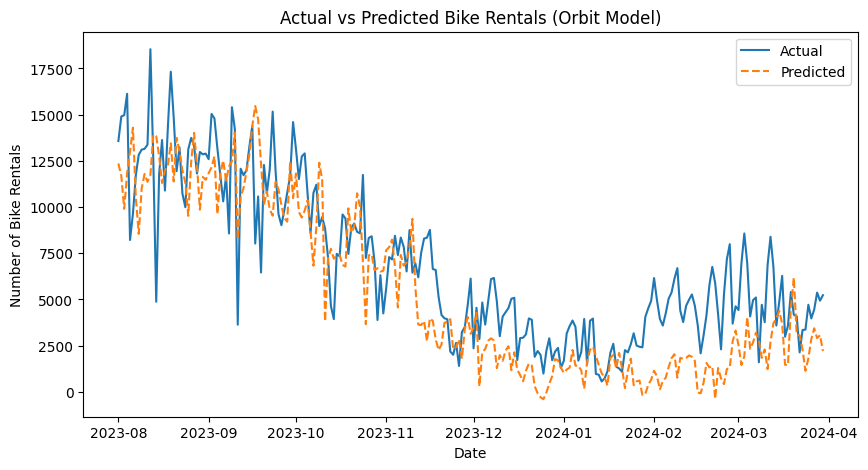

In [ ]:
# Plotting actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(predicted_df_class_orbit['started_at'], predicted_df_class_orbit['classic_bike_rentals'] , label='Actual')
plt.plot(predicted_df_class_orbit['started_at'], predicted_df_class_orbit['predictions_in_original_scale']
, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Bike Rentals (Orbit Model)')
plt.xlabel('Date')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()


In [ ]:
# Sample data for demonstration
actuals = predicted_df_class_orbit['classic_bike_rentals']  # Replace 'actual_column_name' with the name of your actual data column
#predictions = dlt_refined.predict(df=test_df)  # This assumes predictions are already made

# Calculate residuals
predicted_df_class_orbit['residuals'] = actuals - predicted_df_class_orbit['predictions_in_original_scale']

# Manually compute CI if not available directly from model outputs
# Calculate the standard deviation of the residuals
std_residuals = np.std(predicted_df_class_orbit['residuals'])

# Calculate 95% confidence interval using the standard error
z_value = stats.norm.ppf(0.975)  # Z-score for 95% confidence

# Margin of error based on the standard deviation of residuals
margin_error = z_value * std_residuals

# Calculate lower and upper bounds of the 95% confidence interval
predicted_df_class_orbit['ci_lower'] = predicted_df_class_orbit['predictions_in_original_scale'] - margin_error
predicted_df_class_orbit['ci_upper'] = predicted_df_class_orbit['predictions_in_original_scale'] + margin_error

# Optional: Display the DataFrame to verify results
predicted_df_class_orbit[['classic_bike_rentals','predictions_in_original_scale', 'residuals', 'ci_lower', 'ci_upper']]


classic_bike_rentals  predictions_in_original_scale    residuals  \
0                   13573                   12359.100699  1213.899301   
1                   14901                   11695.348159  3205.651841   
2                   14974                    9904.524350  5069.475650   
3                   16130                   11827.405121  4302.594879   
4                    8218                   12999.873125 -4781.873125   
..                    ...                            ...          ...   
238                  3973                    2844.847180  1128.152820   
239                  4451                    3437.817481  1013.182519   
240                  5370                    2906.787308  2463.212692   
241                  4933                    3063.189961  1869.810039   
242                  5228                    2208.191865  3019.808135   

        ci_lower      ci_upper  
0    7647.044897  17071.156500  
1    6983.292358  16407.403961  
2    5192.468548  14616.580152  
3    7115.349319  16539.460922  
4    8287.817323  17711.928927  
..           ...           ...  
238 -1867.208621   7556.902982  
239 -1274.238321   8149.873283  
240 -1805.268493   7618.843110  
241 -1648.865840   7775.245763  
242 -2503.863937   6920.247666  

[243 rows x 5 columns]

In [ ]:
predicted_df_class_orbit_1 = predicted_df_class_orbit[['started_at','classic_bike_rentals','predictions_in_original_scale', 'ci_lower', 'ci_upper']]

predicted_df_class_orbit_1.head()


started_at  classic_bike_rentals  predictions_in_original_scale  \
0 2023-08-01                 13573                   12359.100699   
1 2023-08-02                 14901                   11695.348159   
2 2023-08-03                 14974                    9904.524350   
3 2023-08-04                 16130                   11827.405121   
4 2023-08-05                  8218                   12999.873125   

      ci_lower      ci_upper  
0  7647.044897  17071.156500  
1  6983.292358  16407.403961  
2  5192.468548  14616.580152  
3  7115.349319  16539.460922  
4  8287.817323  17711.928927

In [ ]:
predicted_df_class_orbit_1.to_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Orbit_Classic_Prediction.csv', index = False)

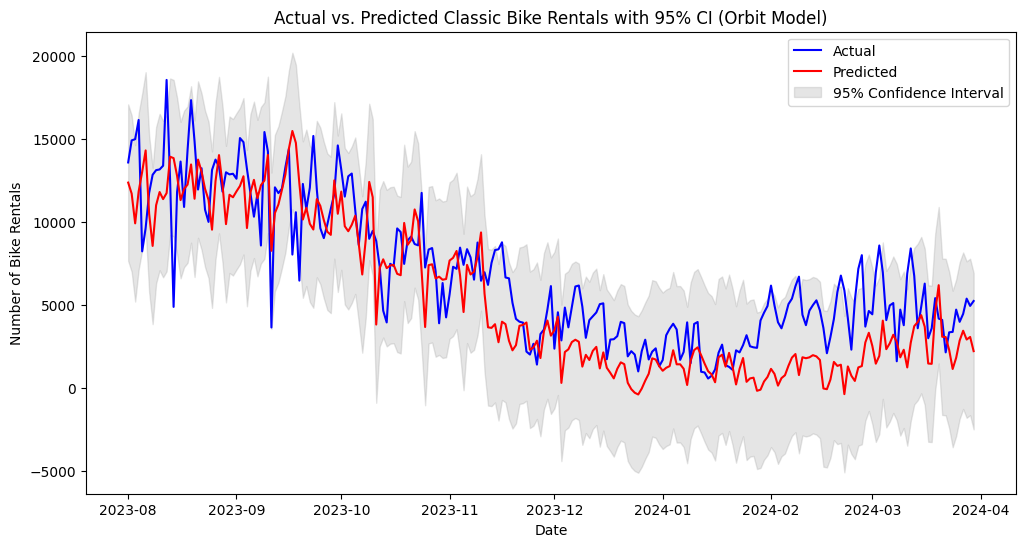

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(predicted_df_class_orbit['started_at'], predicted_df_class_orbit['classic_bike_rentals'], label='Actual', color='blue')
plt.plot(predicted_df_class_orbit['started_at'], predicted_df_class_orbit['predictions_in_original_scale'], label='Predicted', color='red')
plt.fill_between(predicted_df_class_orbit['started_at'], predicted_df_class_orbit['ci_lower'],predicted_df_class_orbit['ci_upper'] , color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs. Predicted Classic Bike Rentals with 95% CI (Orbit Model)')
plt.xlabel('Date')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()


<a name="Orbit-Damped-Local-Trend-Electric-Bike"></a>
#### (b) Orbit Damped Local Trend Electric Bike

In [ ]:
elect_df = elect_df.reset_index()
elect_df

started_at  elect_bike_rentals        day  log_elect_bike_rentals  \
0    2020-07-13                   8     Monday                2.079442   
1    2020-07-14                  14    Tuesday                2.639057   
2    2020-07-15                  13  Wednesday                2.564949   
3    2020-07-28                  31    Tuesday                3.433987   
4    2020-07-29                 287  Wednesday                5.659482   
...         ...                 ...        ...                     ...   
1340 2024-03-26                5208    Tuesday                8.557951   
1341 2024-03-27                5312  Wednesday                8.577724   
1342 2024-03-28                6564   Thursday                8.789355   
1343 2024-03-29                5585     Friday                8.627840   
1344 2024-03-30                5273   Saturday                8.570355   

      Differenced  diff_elect_bike_rentals  
0             NaN                      NaN  
1        0.559616                      6.0  
2       -0.074108                     -1.0  
3        0.869038                     18.0  
4        2.225495                    256.0  
...           ...                      ...  
1340     0.001153                      6.0  
1341     0.019773                    104.0  
1342     0.211632                   1252.0  
1343    -0.161516                   -979.0  
1344    -0.057485                   -312.0  

[1345 rows x 6 columns]

In [ ]:
split_point = pd.Timestamp('2023-07-03')
#elect_df['started_at'] = elect_df.index

elect_train_df = elect_df[elect_df['started_at'] < split_point]
elect_test_df = elect_df[elect_df['started_at'] >= split_point]


print(f"Shape of elect_train_df: {elect_train_df.shape}")
print(f"Shape of celect_test_df: {elect_test_df.shape}")

Shape of elect_train_df: (1073, 6)
Shape of celect_test_df: (272, 6)


In [ ]:
data=elect_df[['started_at','elect_bike_rentals']]

# Generate Fourier series components
data, fs_cols = make_fourier_series_df(data, 365.25, order=5)

# Split the data
test_size = 272
train_df = data[:-test_size]
validation_df = data[-test_size:]

In [ ]:
# Initialize MinMaxScaler
scaler_target = MinMaxScaler()


# Scale the target variable for both training and validation sets
train_df['scaled_elect_bike_rentals'] = scaler_target.fit_transform(train_df[['elect_bike_rentals']])
validation_df['scaled_elect_bike_rentals'] = scaler_target.transform(validation_df[['elect_bike_rentals']])

<ipython-input-191-357c25e9efde>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['scaled_elect_bike_rentals'] = scaler_target.fit_transform(train_df[['elect_bike_rentals']])
<ipython-input-191-357c25e9efde>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['scaled_elect_bike_rentals'] = scaler_target.transform(validation_df[['elect_bike_rentals']])


In [ ]:
%%time
# Define the objective function
def scaled_objective(global_cap, global_floor, damped_factor):
    model = DLT(
        response_col='scaled_elect_bike_rentals',
        date_col='started_at',
        estimator='stan-map',
        regressor_col=fs_cols,
        seasonality=365,
        seed=8888,
        global_trend_option='logistic',
        global_cap=global_cap,
        global_floor=global_floor,
        damped_factor=damped_factor,
        n_bootstrap_draws=1000,
        verbose=False
    )
    model.fit(df=train_df)
    predictions = model.predict(df=validation_df)
    predictions_in_original_scale = scaler_target.inverse_transform(predictions[['prediction']])


    rmse = mean_squared_error(validation_df['elect_bike_rentals'], predictions_in_original_scale, squared=False)
    return -rmse

# Parameter bounds
param_bounds = {
    'global_cap': (5000, 20000),
    'global_floor': (0, 50),
    'damped_factor': (0.01, 0.8)
}

# Setup Bayesian Optimization
optimizer = BayesianOptimization(f=scaled_objective, pbounds=param_bounds, random_state=1, verbose=2)

# Run the optimizer
optimizer.maximize(init_points=5, n_iter=15)

# Print the best parameters found
print(optimizer.max)

|   iter    |  target   | damped... | global... | global... |
-------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 1         | -1.387e+0 | 0.3394    | 1.58e+04  | 0.005719  |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 2         | -8.74e+03 | 0.2488    | 7.201e+03 | 4.617     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 3         | -7.646e+0 | 0.1571    | 1.018e+04 | 19.84     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 4         | -9.716e+0 | 0.4357    | 1.129e+04 | 34.26     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 5         | -1.526e+0 | 0.1715    | 1.817e+04 | 1.369     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 6         | -3.31e+04 | 0.01      | 5e+03     | 50.0      |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 7         | -9.332e+0 | 0.2362    | 1.129e+04 | 30.79     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 8         | -7.814e+0 | 0.01      | 1.115e+04 | 0.0       |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 9         | -1.363e+0 | 0.5778    | 1.036e+04 | 45.9      |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 10        | -8.397e+0 | 0.2854    | 1.001e+04 | 13.33     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 11        | -6.429e+0 | 0.1589    | 6.994e+03 | 8.866     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 12        | -1.548e+0 | 0.5193    | 6.804e+03 | 30.46     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 13        | -9.843e+0 | 0.2348    | 9.806e+03 | 40.89     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 14        | -1.235e+0 | 0.4606    | 1.095e+04 | 0.1601    |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 15        | -1.875e+0 | 0.615     | 7.401e+03 | 47.32     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 16        | -8.471e+0 | 0.1164    | 7.096e+03 | 38.13     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 17        | -1.29e+04 | 0.426     | 9.566e+03 | 3.031     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 18        | -8.88e+03 | 0.1635    | 1.151e+04 | 1.834     |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 19        | -9.191e+0 | 0.4578    | 1.171e+04 | 8.42      |


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


| 20        | -3.238e+0 | 0.4839    | 1.192e+04 | 46.93     |
{'target': -6428.848968091197, 'params': {'damped_factor': 0.1588582927313985, 'global_cap': 6993.568718733896, 'global_floor': 8.86597973211151}}
CPU times: user 19.7 s, sys: 2.54 s, total: 22.3 s
Wall time: 12min 42s


In [ ]:
optimizer.max['params']

{'damped_factor': 0.1588582927313985,
 'global_cap': 6993.568718733896,
 'global_floor': 8.86597973211151}

In [ ]:
%%time

# Initialize and fit the model using the best parameters
model = DLT(
    response_col='scaled_elect_bike_rentals',
    date_col='started_at',
    regressor_col=fs_cols,
    estimator='stan-map',
    seasonality=365,
    seed=8888,
    global_trend_option='logistic',
    global_cap=optimizer.max['params']['global_cap'],
    global_floor=optimizer.max['params']['global_floor'],
    damped_factor=optimizer.max['params']['damped_factor'],
    n_bootstrap_draws=1000,
    verbose=False
)

model.fit(df=train_df)

# Make predictions on the validation set
# outcomes data frame
predictions = model.predict(df=validation_df)

# Inverse transform the predictions to get them back to the original scale
predictions['predictions_in_original_scale'] = scaler_target.inverse_transform(predictions[['prediction']])


# Display the predictions in the original scale
predictions


/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


CPU times: user 896 ms, sys: 10 ms, total: 906 ms
Wall time: 4.9 s


started_at  prediction_5  prediction  prediction_95  \
0   2023-07-03      0.063104    0.160729       0.264910   
1   2023-07-04     -0.108034    0.048356       0.208856   
2   2023-07-05     -0.216313   -0.017359       0.181017   
3   2023-07-06     -0.203877    0.026604       0.266109   
4   2023-07-07     -0.199672    0.068781       0.333747   
..         ...           ...         ...            ...   
267 2024-03-26     -1.908108    0.143813       2.253588   
268 2024-03-27     -1.889099    0.168156       2.268470   
269 2024-03-28     -1.845816    0.180898       2.275473   
270 2024-03-29     -1.840256    0.184381       2.274342   
271 2024-03-30     -1.952993    0.145655       2.240005   

     predictions_in_original_scale  
0                      2981.881679  
1                       897.813674  
2                      -320.943308  
3                       494.406513  
4                      1276.615190  
..                             ...  
267                    2668.161057  
268                    3119.614864  
269                    3355.940463  
270                    3420.523764  
271                    2702.312149  

[272 rows x 5 columns]

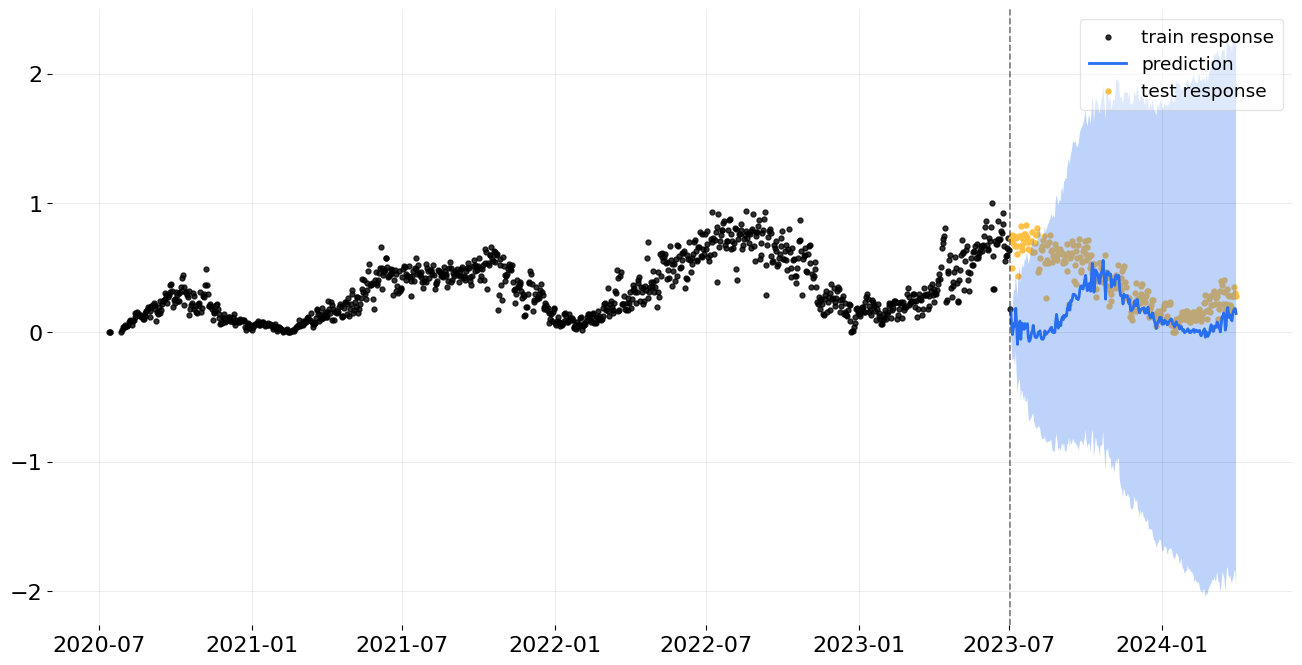

<Axes: >

In [ ]:
plot_predicted_data(
  training_actual_df=train_df, predicted_df=predictions,
  date_col=model.date_col, actual_col=model.response_col,
  test_actual_df=validation_df
)

/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:335: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


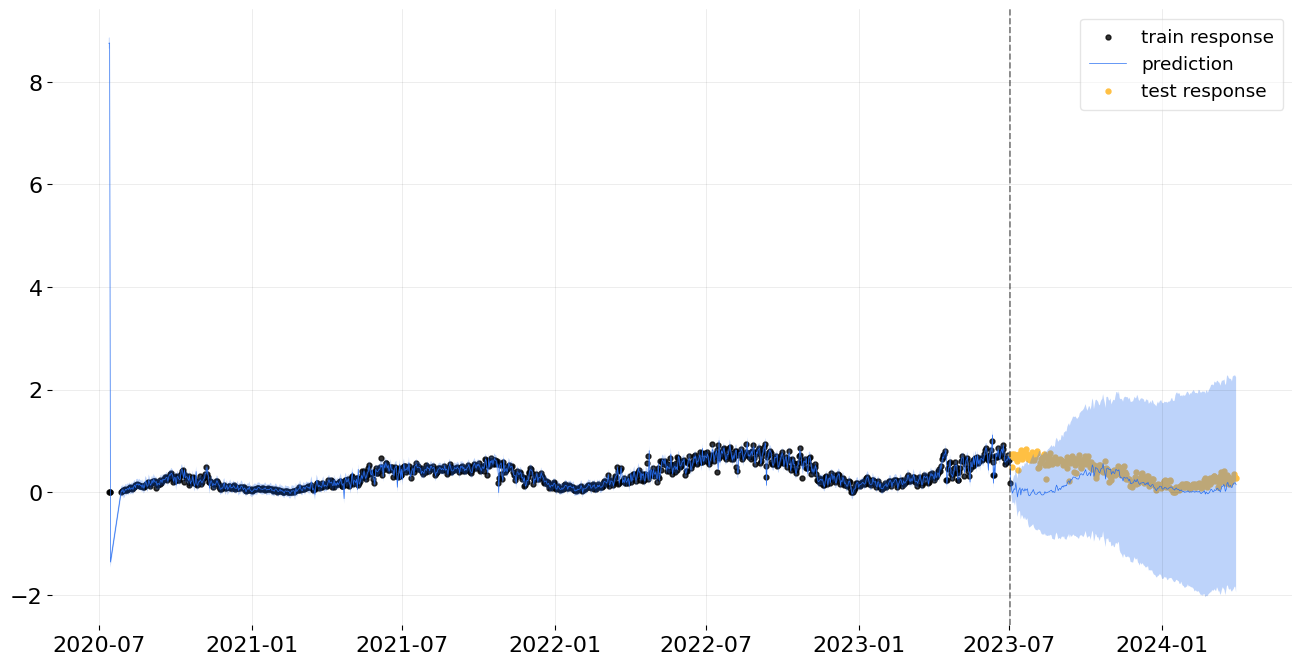

In [ ]:
# Initialize and fit the model using the best parameters
model = DLT(
    response_col='scaled_elect_bike_rentals',
    date_col='started_at',
    regressor_col=fs_cols,
    estimator='stan-map',
    seasonality=365,
    seed=8888,
    global_trend_option='logistic',
    global_cap=optimizer.max['params']['global_cap'],
    global_floor=optimizer.max['params']['global_floor'],
    damped_factor=optimizer.max['params']['damped_factor'],
    n_bootstrap_draws=1000,
    verbose=False
)

model.fit(df=train_df)

pred_df = model.predict(data)

plot_predicted_data(training_actual_df=train_df, predicted_df=pred_df,
  date_col=model.date_col, actual_col=model.response_col, test_actual_df=validation_df, lw=0.5);

In [ ]:
# If you prefer a left join to keep all rows from elect_test_df and add predictions where available
predicted_df_elect_orbit = validation_df.merge(predictions[['prediction','started_at', 'predictions_in_original_scale']],
                                on='started_at', how='left')
predicted_df_elect_orbit

started_at  elect_bike_rentals   fs_cos1   fs_sin1   fs_cos2   fs_sin2  \
0   2023-07-03               13328  0.930818 -0.365484  0.732843 -0.680398   
1   2023-07-04               13924  0.936967 -0.349418  0.755814 -0.654787   
2   2023-07-05                9192  0.942839 -0.333249  0.777890 -0.628401   
3   2023-07-06               12886  0.948432 -0.316982  0.799045 -0.601271   
4   2023-07-07               13875  0.953744 -0.300620  0.819255 -0.573430   
..         ...                 ...       ...       ...       ...       ...   
267 2024-03-26                5208 -0.473706 -0.880683 -0.551205  0.834370   
268 2024-03-27                5312 -0.458487 -0.888701 -0.579579  0.814916   
269 2024-03-28                6564 -0.443132 -0.896456 -0.607268  0.794497   
270 2024-03-29                5585 -0.427646 -0.903946 -0.634237  0.773138   
271 2024-03-30                5273 -0.412034 -0.911169 -0.660457  0.750864   

      fs_cos3   fs_sin3   fs_cos4   fs_sin4   fs_cos5   fs_sin5  \
0    0.433469 -0.901169  0.074117 -0.997250 -0.295489 -0.955346   
1    0.479378 -0.877609  0.142508 -0.989794 -0.212327 -0.977199   
2    0.524010 -0.851712  0.210225 -0.977653 -0.127594 -0.991826   
3    0.567248 -0.823547  0.276946 -0.960885 -0.041919 -0.999121   
4    0.608975 -0.793190  0.342357 -0.939570  0.044067 -0.999029   
..        ...       ...       ...       ...       ...       ...   
267  0.995925  0.090190 -0.392347 -0.919817 -0.624210  0.781257   
268  0.989946  0.141444 -0.328176 -0.944617 -0.689017  0.724745   
269  0.981332  0.192322 -0.262452 -0.964945 -0.748730  0.662875   
270  0.970105  0.242687 -0.195486 -0.980707 -0.802907  0.596104   
271  0.956294  0.292406 -0.127594 -0.991826 -0.851148  0.524926   

     scaled_elect_bike_rentals  prediction  predictions_in_original_scale  
0                     0.718592    0.160729                    2981.881679  
1                     0.750728    0.048356                     897.813674  
2                     0.495579   -0.017359                    -320.943308  
3                     0.694759    0.026604                     494.406513  
4                     0.748086    0.068781                    1276.615190  
..                         ...         ...                            ...  
267                   0.280761    0.143813                    2668.161057  
268                   0.286369    0.168156                    3119.614864  
269                   0.353877    0.180898                    3355.940463  
270                   0.301089    0.184381                    3420.523764  
271                   0.284266    0.145655                    2702.312149  

[272 rows x 15 columns]

In [ ]:
actual = predicted_df_elect_orbit['elect_bike_rentals']
predicted = predicted_df_elect_orbit['predictions_in_original_scale']

# Calculating RMSE
rmse = sqrt(mean_squared_error(actual, predicted))

# Calculating MAE
mae = mean_absolute_error(actual, predicted)

# Calculating MPE
mpe = np.mean((actual - predicted) / actual) * 100

# Calculating MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("RMSE:", rmse)
print("MAE:", mae)
print("MPE:", mpe)
print("MAPE:", mape)

RMSE: 6428.848968091197
MAE: 4714.146791080093
MPE: -37.331486984296454
MAPE: 151.78190001413603


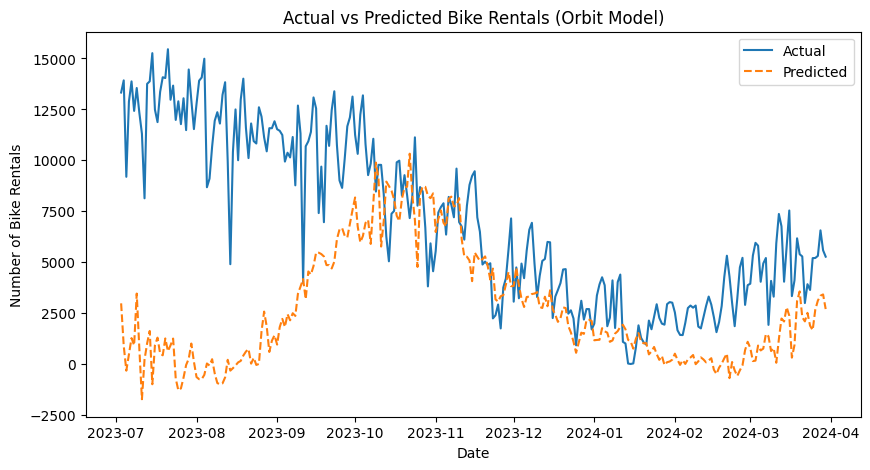

In [ ]:
# Plotting actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(predicted_df_elect_orbit['started_at'], predicted_df_elect_orbit['elect_bike_rentals'] , label='Actual')
plt.plot(predicted_df_elect_orbit['started_at'], predicted_df_elect_orbit['predictions_in_original_scale']
, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Bike Rentals (Orbit Model)')
plt.xlabel('Date')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()


In [ ]:

# Sample data for demonstration
actuals = predicted_df_elect_orbit['elect_bike_rentals']  # Replace 'actual_column_name' with the name of your actual data column
#predictions = dlt_refined.predict(df=test_df)  # This assumes predictions are already made

# Calculate residuals
predicted_df_elect_orbit['residuals'] = actuals - predicted_df_elect_orbit['predictions_in_original_scale']

# Manually compute CI if not available directly from model outputs
# Calculate the standard deviation of the residuals
std_residuals = np.std(predicted_df_elect_orbit['residuals'])

# Calculate 95% confidence interval using the standard error
z_value = stats.norm.ppf(0.975)  # Z-score for 95% confidence

# Margin of error based on the standard deviation of residuals
margin_error = z_value * std_residuals

# Calculate lower and upper bounds of the 95% confidence interval
predicted_df_elect_orbit['ci_lower'] = predicted_df_elect_orbit['predictions_in_original_scale'] - margin_error
predicted_df_elect_orbit['ci_upper'] = predicted_df_elect_orbit['predictions_in_original_scale'] + margin_error

# Optional: Display the DataFrame to verify results
predicted_df_elect_orbit[['elect_bike_rentals','predictions_in_original_scale', 'residuals', 'ci_lower', 'ci_upper']]


elect_bike_rentals  predictions_in_original_scale     residuals  \
0                 13328                    2981.881679  10346.118321   
1                 13924                     897.813674  13026.186326   
2                  9192                    -320.943308   9512.943308   
3                 12886                     494.406513  12391.593487   
4                 13875                    1276.615190  12598.384810   
..                  ...                            ...           ...   
267                5208                    2668.161057   2539.838943   
268                5312                    3119.614864   2192.385136   
269                6564                    3355.940463   3208.059537   
270                5585                    3420.523764   2164.476236   
271                5273                    2702.312149   2570.687851   

        ci_lower      ci_upper  
0   -6201.070764  12164.834122  
1   -8285.138769  10080.766116  
2   -9503.895751   8862.009135  
3   -8688.545930   9677.358956  
4   -7906.337253  10459.567633  
..           ...           ...  
267 -6514.791385  11851.113500  
268 -6063.337579  12302.567307  
269 -5827.011979  12538.892906  
270 -5762.428679  12603.476207  
271 -6480.640294  11885.264592  

[272 rows x 5 columns]

In [ ]:
predicted_df_elect_orbit_1 = predicted_df_elect_orbit[['started_at','elect_bike_rentals','predictions_in_original_scale', 'ci_lower', 'ci_upper']]
predicted_df_elect_orbit_1.head()

started_at  elect_bike_rentals  predictions_in_original_scale     ci_lower  \
0 2023-07-03               13328                    2981.881679 -6201.070764   
1 2023-07-04               13924                     897.813674 -8285.138769   
2 2023-07-05                9192                    -320.943308 -9503.895751   
3 2023-07-06               12886                     494.406513 -8688.545930   
4 2023-07-07               13875                    1276.615190 -7906.337253   

       ci_upper  
0  12164.834122  
1  10080.766116  
2   8862.009135  
3   9677.358956  
4  10459.567633

In [ ]:
predicted_df_elect_orbit_1.to_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Orbit_Electric_Prediction.csv', index = False)

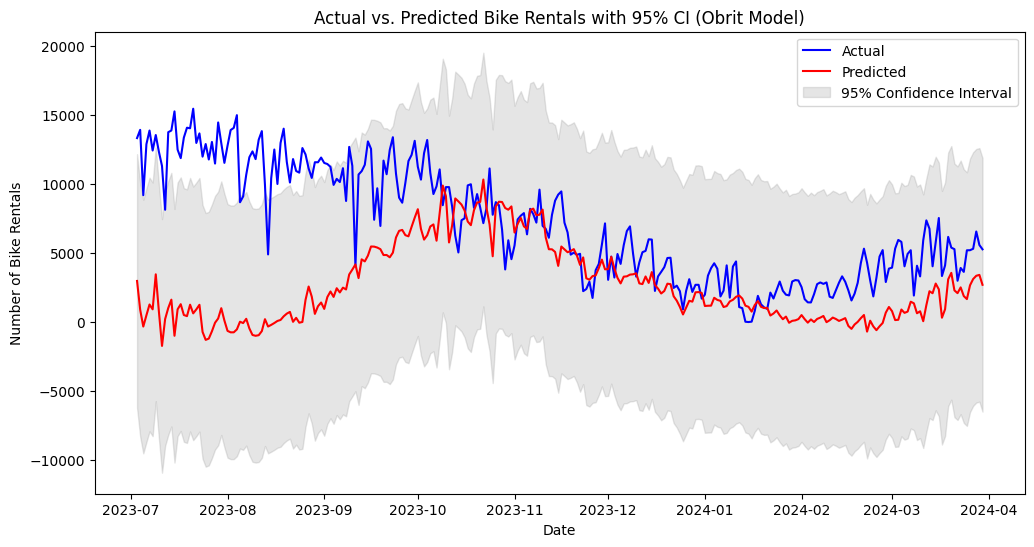

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(predicted_df_elect_orbit['started_at'], predicted_df_elect_orbit['elect_bike_rentals'], label='Actual', color='blue')
plt.plot(predicted_df_elect_orbit['started_at'], predicted_df_elect_orbit['predictions_in_original_scale'], label='Predicted', color='red')
plt.fill_between(predicted_df_elect_orbit['started_at'], predicted_df_elect_orbit['ci_lower'],predicted_df_elect_orbit['ci_upper'] , color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs. Predicted Bike Rentals with 95% CI (Obrit Model)')
plt.xlabel('Date')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()


<a name="Facebook-Prophet"></a>
### 6.6 Facebook Prophet

<a name="Prophet-Classic-Bike"></a>
#### (a) Prophet Classic Bike

In [ ]:
df_reset = class_train_df.reset_index()
df_prophet = df_reset.rename(columns={'started_at': 'ds', 'classic_bike_rentals': 'y'})

# Instantiate and fit the model with Prophet
model = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=True)
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpibf8dki5/mp0vxa6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpibf8dki5/ojhd96mj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31891', 'data', 'file=/tmp/tmpibf8dki5/mp0vxa6p.json', 'init=/tmp/tmpibf8dki5/ojhd96mj.json', 'output', 'file=/tmp/tmpibf8dki5/prophet_model280hwhno/prophet_model-20240513044929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:49:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


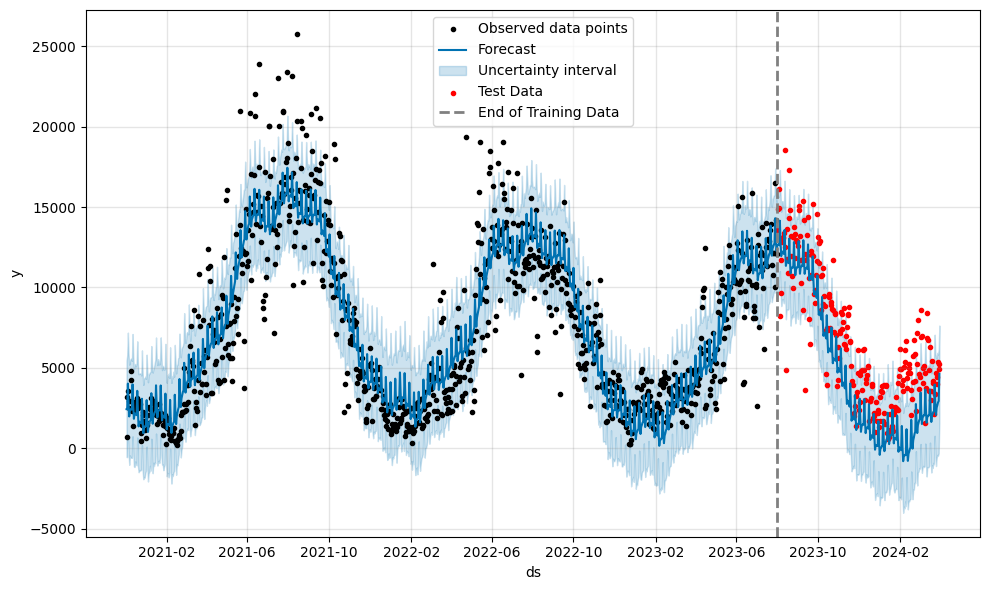

In [ ]:
# Extend the future DataFrame with necessary regressors
future = model.make_future_dataframe(periods=len(class_test_df), freq='D')

# Assuming last available y value is the last observation in the training set
last_known_y = df_prophet['y'].iloc[-1]

# We simulate future 'y' values by carrying forward the last known value
# This is a placeholder; you might want to use a better method in practice
future['y_lag1'] = last_known_y

# Predicting the future with the model
forecast = model.predict(future)

# Correct calculation for confidence intervals using 'yhat' and the z-score
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
forecast['Lower_CI'] = forecast['yhat'] - z_score * forecast['yhat_lower']
forecast['Upper_CI'] = forecast['yhat'] + z_score * forecast['yhat_upper']

# Save the results into a new DataFrame
results_df_prophet = forecast[['ds', 'yhat', 'Lower_CI', 'Upper_CI']].rename(columns={'ds': 'started_at', 'yhat': 'predicted_classic_bike_rentals_prophet'})

# Plotting
fig1 = model.plot(forecast)
test_data_for_plotting = class_test_df.copy()
test_data_for_plotting['started_at'] = pd.to_datetime(test_data_for_plotting.index)

plt.scatter(test_data_for_plotting['started_at'], test_data_for_plotting['classic_bike_rentals'], color='red', marker='.', label='Test Data')
last_train_date = df_prophet['ds'].max()
plt.axvline(x=last_train_date, color='gray', linestyle='--', linewidth=2, label='End of Training Data')
plt.legend()
plt.show()

In [ ]:
results_df_prophet.to_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Prophet Classic.csv')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Align the forecasted data with the test dataset dates
forecast_test_period = forecast.set_index('ds')['yhat'].loc[class_test_df.index]

# Calculate the errors
mae = mean_absolute_error(class_test_df['classic_bike_rentals'], forecast_test_period)
rmse = np.sqrt(mean_squared_error(class_test_df['classic_bike_rentals'], forecast_test_period))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2517.2092464621983
Root Mean Square Error (RMSE): 3030.3381626993587


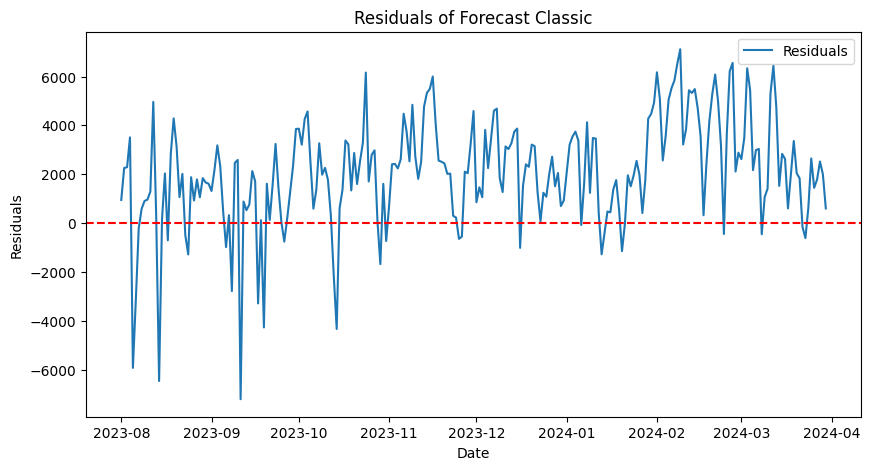

In [ ]:
residuals_class = class_test_df['classic_bike_rentals'] - forecast_test_period
# Plot residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals_class.index, residuals_class, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast Classic')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

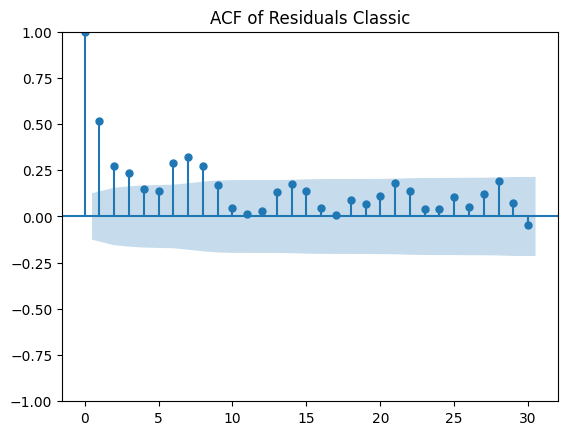

In [ ]:
plot_acf(residuals_class, lags=30, alpha=0.05)
plt.title('ACF of Residuals Classic')
plt.show()

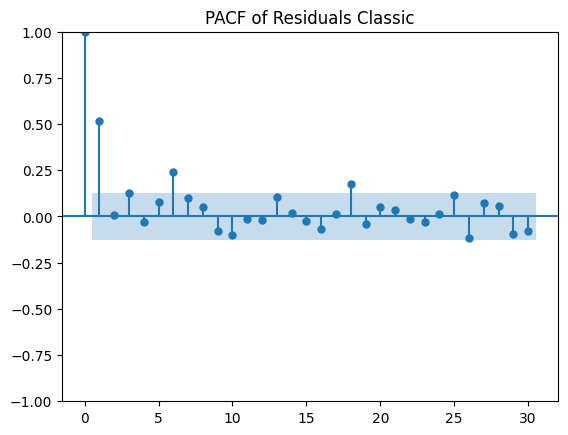

In [ ]:
plot_pacf(residuals_class, lags=30, alpha=0.05)
plt.title('PACF of Residuals Classic')
plt.show()

<a name="Prophet-Electric-Bike"></a>
#### (b) Prophet Electric Bike

In [ ]:
df_reset_elect = elect_train_df.reset_index()
df_prophet_elect = df_reset_elect.rename(columns={'started_at': 'ds', 'elect_bike_rentals': 'y'})
model_elect = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=True)
model_elect.add_seasonality(name='weekly', period=7, fourier_order=3)
model_elect.fit(df_prophet_elect)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpibf8dki5/kiynq6wb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpibf8dki5/f1yd8hm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28619', 'data', 'file=/tmp/tmpibf8dki5/kiynq6wb.json', 'init=/tmp/tmpibf8dki5/f1yd8hm5.json', 'output', 'file=/tmp/tmpibf8dki5/prophet_model9bqlygx2/prophet_model-20240513044959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:49:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
num_periods_to_predict = len(elect_test_df)
future_elect = model_elect.make_future_dataframe(periods=num_periods_to_predict, freq='D')

forecast_elect = model_elect.predict(future_elect)
num_periods_to_predict = len(elect_test_df)
future_elect = model_elect.make_future_dataframe(periods=num_periods_to_predict, freq='D')

forecast_elect = model_elect.predict(future_elect)

# Calculate the 95% confidence intervals
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
forecast_elect['Lower_CI'] = forecast_elect['yhat'] - z_score * forecast_elect['yhat_lower']
forecast_elect['Upper_CI'] = forecast_elect['yhat'] + z_score * forecast_elect['yhat_upper']

# Save the results into a new DataFrame
results_df_prophet_elect = forecast_elect[['ds', 'yhat', 'Lower_CI', 'Upper_CI']].rename(columns={'ds': 'started_at', 'yhat': 'predicted_elect_bike_rentals_prophet'})


In [ ]:
results_df_prophet_elect.to_csv('/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Prophet Elect Results.csv')

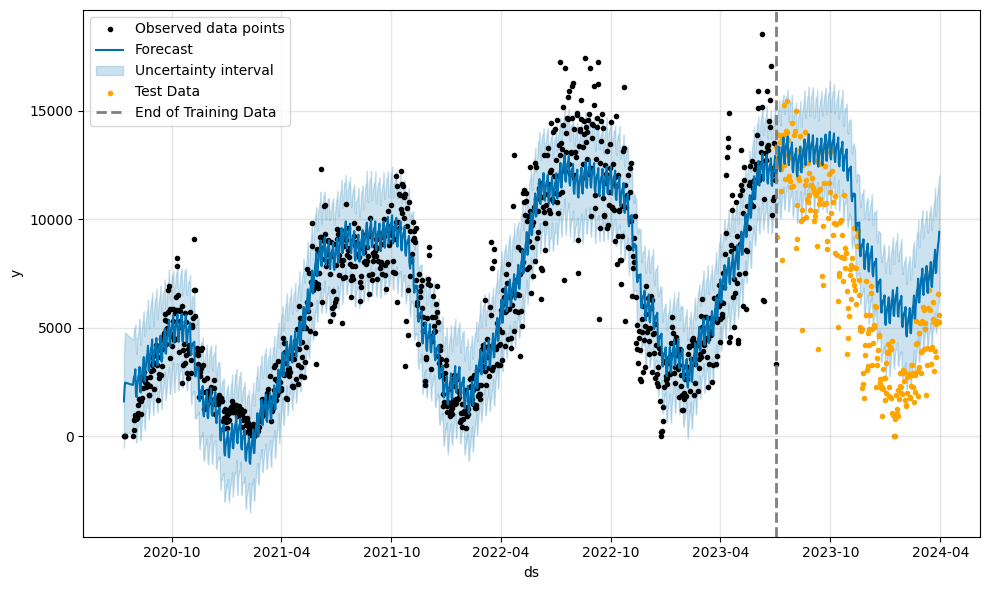

In [ ]:
fig2 = model_elect.plot(forecast_elect)

test_data_for_plotting_elect = elect_test_df.reset_index()

plt.scatter(test_data_for_plotting_elect['started_at'], test_data_for_plotting_elect['elect_bike_rentals'], color='orange', marker='.', label='Test Data')

last_train_date_elect = df_prophet_elect['ds'].max()
plt.axvline(x=last_train_date_elect, color='gray', linestyle='--', linewidth=2, label='End of Training Data')

plt.legend()
plt.show()

In [ ]:
forecast_elect['ds'] = pd.to_datetime(forecast_elect['ds'])

# Align the forecasted data with the test dataset dates
forecast_test_period_elect = forecast_elect.set_index('ds')['yhat'].loc[elect_test_df.index]

# Calculate the errors using the 'Differenced' data column from the test set
mae_elect = mean_absolute_error(elect_test_df['elect_bike_rentals'], forecast_test_period_elect)
rmse_elect = np.sqrt(mean_squared_error(elect_test_df['elect_bike_rentals'], forecast_test_period_elect))

# MAE and RMSE values
print(f"Mean Absolute Error (MAE) on Elect Data: {mae_elect}")
print(f"Root Mean Square Error (RMSE) on Elect Data: {rmse_elect}")

Mean Absolute Error (MAE) on Elect Data: 2931.6149396636956
Root Mean Square Error (RMSE) on Elect Data: 3415.465331171118


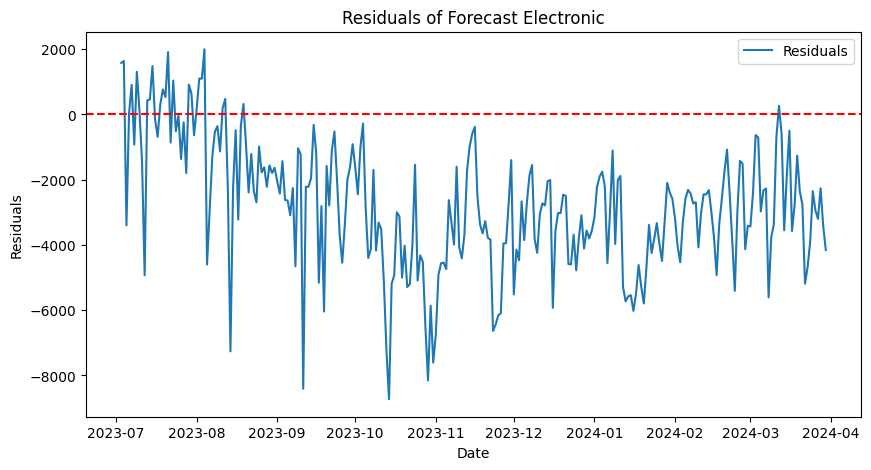

In [ ]:
residuals_elect = elect_test_df['elect_bike_rentals'] - forecast_test_period_elect

plt.figure(figsize=(10, 5))
plt.plot(residuals_elect.index, residuals_elect, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals of Forecast Electronic')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

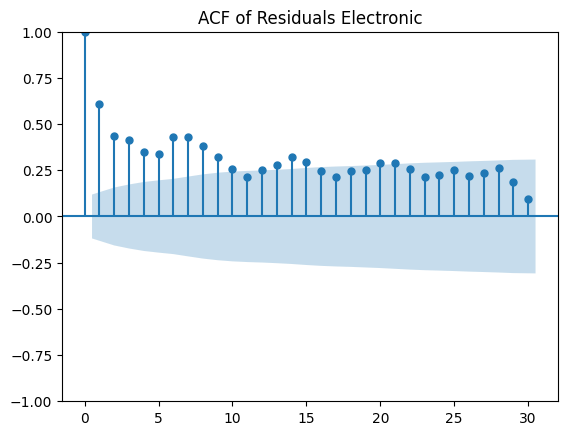

In [ ]:

# ACF plot of residuals
plot_acf(residuals_elect, lags=30, alpha=0.05)
plt.title('ACF of Residuals Electronic')
plt.show()

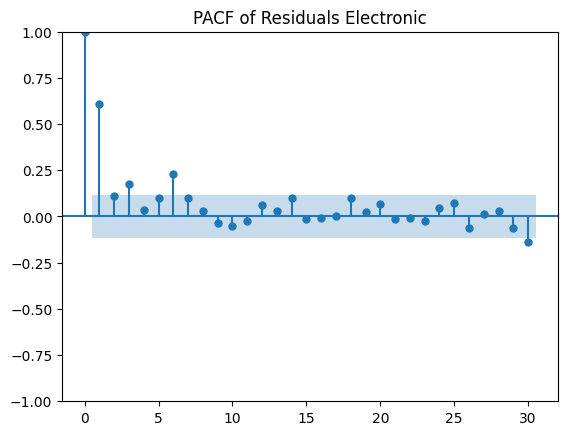

In [ ]:
# PACF plot of residuals
plot_pacf(residuals_elect, lags=30, alpha=0.05)
plt.title('PACF of Residuals Electronic')
plt.show()

<a name="Prediction-Result-Comparison"></a>
## 7. Prediction Result Comparison

- [Prediction Models Comparison of Classic Bike Demand](#Prediction-Models-Comparison-of-Classic-Bike-Demand)

- [Prediction Models Comparison of Electric Bike Demand](#Prediction-Models-Comparison-of-Electric-Bike-Demand)

<a name="Prediction-Models-Comparison-of-Classic-Bike-Demand"></a>
### (a) Prediction Models Comparison of Classic Bike Demand

In [ ]:
sarima_class_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/SARIMA_Classic_Prediction.csv", index_col = False)
sarima_elect_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/SARIMA_Electric_Prediction.csv", index_col = False)
lstm_class_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/predicted_df_classic_lstms.csv", index_col = False)
lstm_elect_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/predicted_df_electric_lstms.csv")
lstm_elect_df = lstm_elect_df.drop(columns=['Unnamed: 0'])
orbit_class_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Orbit_Classic_Prediction.csv")
orbit_elect_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Orbit_Electric_Prediction.csv")
fb_class_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Prophet Classic.csv")
fb_class_df = fb_class_df.drop(columns=['Unnamed: 0'])
fb_elect_df = pd.read_csv("/content/drive/Shareddrives/time series/(Team) ADSP 31006 Time Series Analysis and Forecasting/Prediction Result/Prophet Elect Results.csv")
fb_elect_df = fb_elect_df.drop(columns=['Unnamed: 0'])

<a name="Prediction-Models-Comparison-of-Electric-Bike-Demand"></a>
### (b) Prediction Models Comparison of Electric Bike Demand

<ipython-input-69-9117bee6b0a7>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


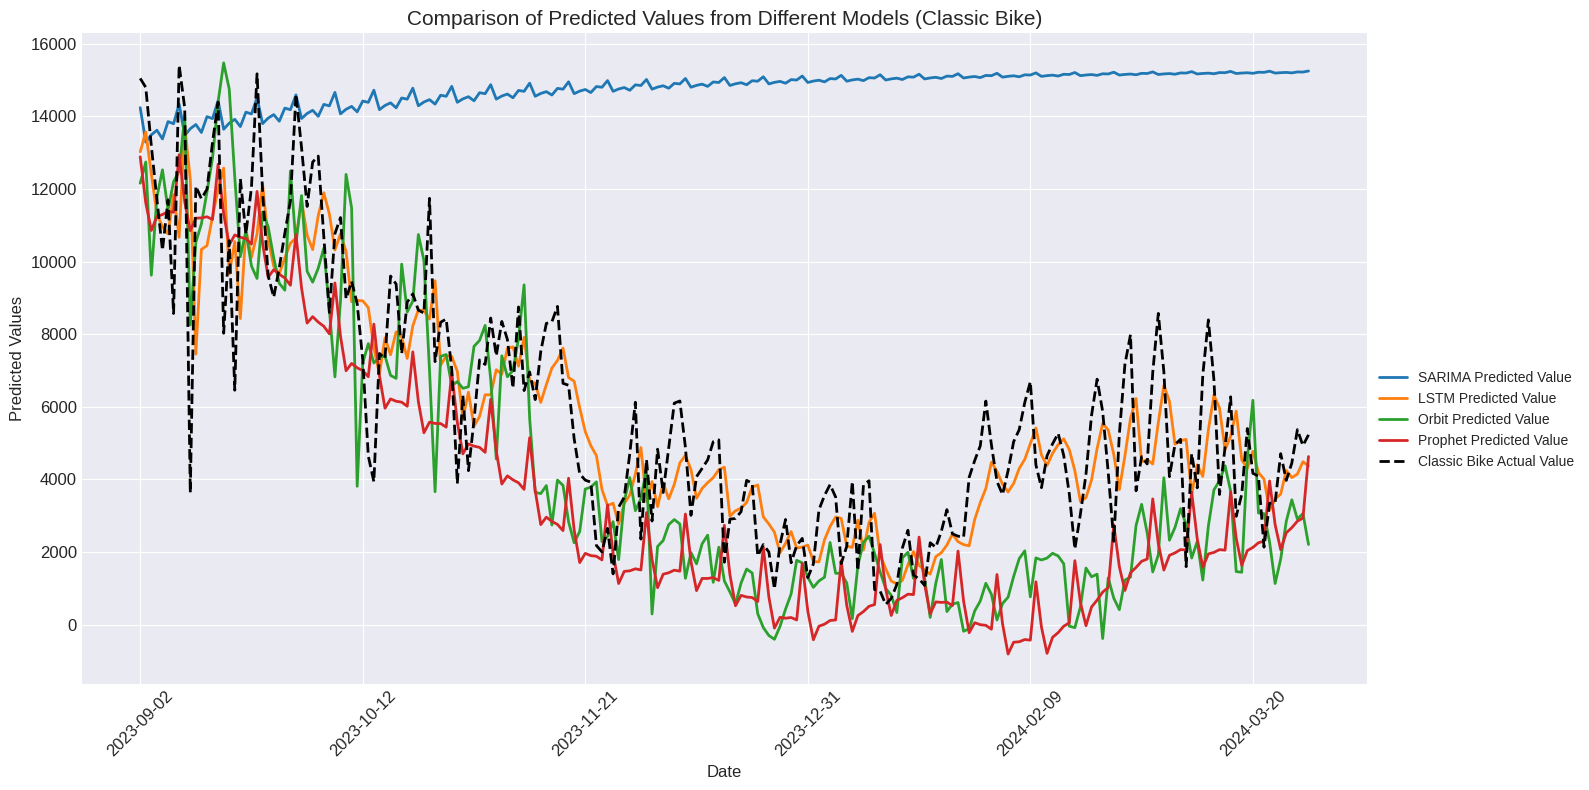

In [ ]:
lstm_class_df.rename(columns={'Start_Test_Date': 'started_at'}, inplace=True)

merged_df_class = sarima_class_df.merge(lstm_class_df, on='started_at', how='inner')
merged_df_class = merged_df_class.merge(orbit_class_df, on='started_at', how='inner')
merged_df_class = merged_df_class.merge(fb_class_df, on='started_at', how='inner')

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(merged_df_class['started_at'], merged_df_class['classic_bike_rentals_predict_value'], label='SARIMA Predicted Value', linewidth=2)
ax.plot(merged_df_class['started_at'], merged_df_class['Classic_Predicted_Value'], label='LSTM Predicted Value', linewidth=2)
ax.plot(merged_df_class['started_at'], merged_df_class['predictions_in_original_scale'], label='Orbit Predicted Value', linewidth=2)
ax.plot(merged_df_class['started_at'], merged_df_class['predicted_classic_bike_rentals_prophet'], label='Prophet Predicted Value', linewidth=2)

ax.plot(merged_df_class['started_at'], merged_df_class['Classic_Actual_Value'], label='Classic Bike Actual Value', color='black', linestyle='--', linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.set_title('Comparison of Predicted Values from Different Models (Classic Bike)', fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))
plt.xticks(rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-71-1a1516e298a3>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


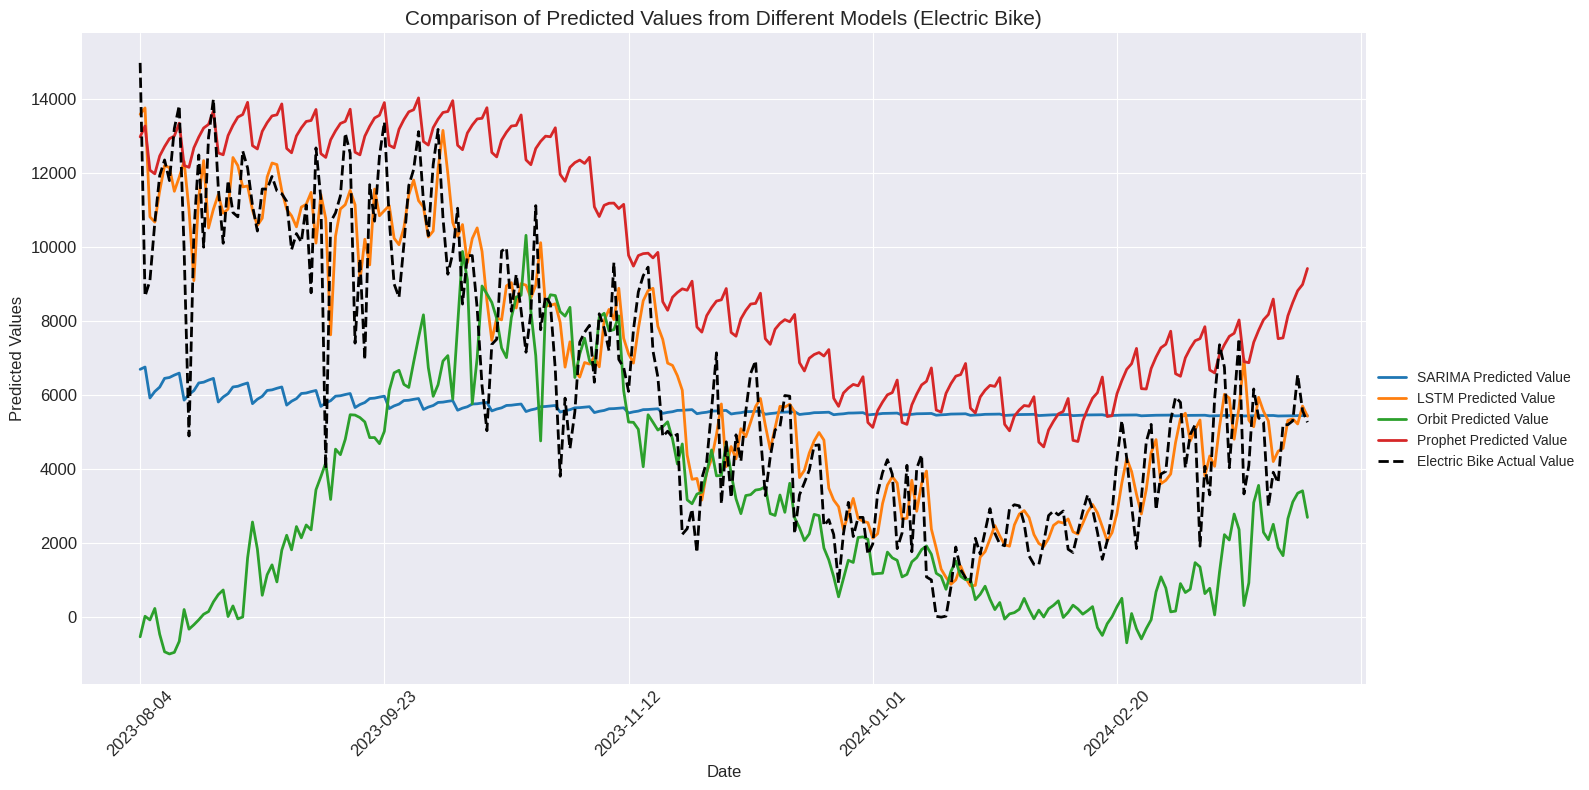

In [ ]:
lstm_elect_df.rename(columns={'Start_Test_Date': 'started_at'}, inplace=True)
merged_df_elect = sarima_elect_df.merge(lstm_elect_df, on='started_at', how='inner')
merged_df_elect = merged_df_elect.merge(orbit_elect_df, on='started_at', how='inner')
merged_df_elect = merged_df_elect.merge(fb_elect_df, on='started_at', how='inner')

plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(merged_df_elect['started_at'], merged_df_elect['electric_bike_rentals_predict_value'], label='SARIMA Predicted Value', linewidth=2)
ax.plot(merged_df_elect['started_at'], merged_df_elect['Electric_Predicted_Value'], label='LSTM Predicted Value', linewidth=2)
ax.plot(merged_df_elect['started_at'], merged_df_elect['predictions_in_original_scale'], label='Orbit Predicted Value', linewidth=2)
ax.plot(merged_df_elect['started_at'], merged_df_elect['predicted_elect_bike_rentals_prophet'], label='Prophet Predicted Value', linewidth=2)

ax.plot(merged_df_elect['started_at'], merged_df_elect['Electric_Actual_Value'], label='Electric Bike Actual Value', color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.set_title('Comparison of Predicted Values from Different Models (Electric Bike)', fontsize=15)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))
plt.xticks(rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
plt.tight_layout()
plt.show()